<a href="https://colab.research.google.com/github/JakubFilipek0/application-of-selected-machine-learning-models-in-leaf-based-plant-health-assessment/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import bibliotek

In [ ]:
# Importowanie potrzebnych bibliotek i modułów
import torch  # PyTorch - biblioteka do uczenia maszynowego
from torch import nn  # Podmoduł w PyTorch do definiowania sieci neuronowych
import requests  # Moduł do obsługi HTTP, używany do pobierania plików z internetu
import zipfile  # Moduł do obsługi plików zip
from pathlib import Path  # Moduł do obsługi ścieżek plików
import os  # Moduł do operacji na systemie operacyjnym
import random  # Moduł do generowania losowych liczb
from PIL import Image  # Pillow - biblioteka do operacji na obrazach
import numpy as np  # NumPy - biblioteka do obliczeń numerycznych
import matplotlib.pyplot as plt  # Matplotlib - biblioteka do tworzenia wykresów
from torch.utils.data import DataLoader  # Moduł do ładowania danych w PyTorch
from torchvision import datasets, transforms, models  # Moduł do obsługi zbiorów danych, transformacji i modeli w PyTorch
from tqdm.auto import tqdm  # TQDM - narzędzie do tworzenia paska postępu
from timeit import default_timer as timer  # Moduł do mierzenia czasu wykonania kodu
from typing import Dict, List  # Moduł do obsługi typów danych
import pandas as pd  # Pandas - biblioteka do analizy danych
import psutil  # Moduł do monitorowania zasobów systemowych
from google.colab import drive  # Moduł do obsługi Google Drive w Google Colab


# 2. Połączenie z dyskie Google

In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
train_dir = "/content/drive/MyDrive/Studia/Studia_moje_prace/Praca_magisterska/plant_village_divided/train"
test_dir = "/content/drive/MyDrive/Studia/Studia_moje_prace/Praca_magisterska/plant_village_divided/test"

In [ ]:
from pathlib import Path

In [ ]:
train_path = Path(train_dir)
test_path = Path(test_dir)

# 3. Sprawdzenie dostępności GPU

In [ ]:
# Sprawdzenie dostępności GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Ustawienie urządzenia na GPU, jeśli jest dostępne, w przeciwnym razie na CPU
print(f'Using device: {device}')  # Wyświetlenie używanego urządzenia (GPU lub CPU)

if device.type == 'cuda':  # Sprawdzenie, czy używane jest GPU
    print(torch.cuda.get_device_name(0))  # Wyświetlenie nazwy pierwszego dostępnego GPU
    print(f'Number of GPU devices: {torch.cuda.device_count()}')  # Wyświetlenie liczby dostępnych GPU w systemie

Using device: cuda
NVIDIA L4
Number of GPU devices: 1


# 4. Transformacja obrazów (w kolorze i w skali szarości

In [ ]:
# Definicja transformacji dla obrazów kolorowych
transform_color = transforms.Compose([
    transforms.Resize((224, 224)),  # Zmiana rozmiaru obrazu na 224x224 pikseli
    transforms.ToTensor(),  # Konwersja obrazu PIL lub numpy do tensora
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizacja obrazu
])

# Definicja transformacji dla obrazów w skali szarości
transform_gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Konwersja obrazu do skali szarości (3 kanały)
    transforms.Resize((224, 224)),  # Zmiana rozmiaru obrazu na 224x224 pikseli
    transforms.ToTensor(),  # Konwersja obrazu PIL lub numpy do tensora
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Normalizacja obrazu
])


# 5. Załdowanie danych

In [ ]:
# Ładowanie podzielonych zestawów danych
train_dataset_color = datasets.ImageFolder(root=train_path, transform=transform_color)
train_dataset_gray = datasets.ImageFolder(root=train_path, transform=transform_gray)

test_dataset_color = datasets.ImageFolder(root=test_path, transform=transform_color)
test_dataset_gray = datasets.ImageFolder(root=test_path, transform=transform_gray)

In [ ]:
# Definicja ładowaczy danych dla różnych rozmiarów batchy dla treningowego i testowego zestawu
train_batch_sizes = [32, 64]
test_batch_size = 64

train_data_loaders = {
    batch_size: {
        'color': DataLoader(train_dataset_color, batch_size=batch_size, shuffle=True, num_workers=psutil.cpu_count(logical=True)),
        'gray': DataLoader(train_dataset_gray, batch_size=batch_size, shuffle=True, num_workers=psutil.cpu_count(logical=True))
    }
    for batch_size in train_batch_sizes
}

test_data_loader_color = DataLoader(test_dataset_color, batch_size=test_batch_size, shuffle=False, num_workers=psutil.cpu_count(logical=True))
test_data_loader_gray = DataLoader(test_dataset_gray, batch_size=test_batch_size, shuffle=False, num_workers=psutil.cpu_count(logical=True))

# 6. Załadowanie modeli i zmiana ostatniej warstwy do liczby klas

In [ ]:
# Definicja modeli
models_dict = {
    'alexnet': models.alexnet(pretrained=True),
    'googlenet': models.googlenet(pretrained=True),
    'vgg16': models.vgg16(pretrained=True),
    'vit': models.vit_b_16(pretrained=True)
}

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 222MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed

In [ ]:
# Dostosowanie ostatniej warstwy każdego modelu do liczby klas w Twoim zbiorze danych
num_classes = len(train_dataset_color.classes)
for model in models_dict.values():
    if hasattr(model, 'fc'):
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif hasattr(model, 'classifier'):
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)

# 7. Konfiguracja optymalizatorów

In [ ]:
# Konfiguracja optymalizatorów
optimizers = {
    'adam': torch.optim.Adam,
    'sgd': torch.optim.SGD
}

# 8. Funkcja do treningu i testowania

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, f1_score, recall_score, classification_report, precision_score

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    model.train()
    train_loss, train_acc = 0, 0
    y_true, y_pred = [], []

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred_logits = model(X)
        loss = loss_fn(y_pred_logits, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred_class)

        # Collect true and predicted labels for metrics calculation
        y_true.extend(y.cpu().numpy())
        y_pred.extend(y_pred_class.cpu().numpy())

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    # Calculate additional metrics
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, output_dict=True)
    #precision = precision_score(y_true, y_pred)

    return train_loss, train_acc, recall, f1, cm, cr


In [ ]:
import torch
from sklearn.metrics import confusion_matrix, f1_score, recall_score, classification_report, precision_score

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    model.eval()
    test_loss, test_acc = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

            # Collect true and predicted labels for metrics calculation
            y_true.extend(y.cpu().numpy())
            y_pred.extend(test_pred_labels.cpu().numpy())

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    # Calculate additional metrics
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, output_dict=True)
    #precision = precision_score(y_true, y_pred)

    return test_loss, test_acc, recall, f1, cm, cr


In [ ]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

    # Initialize milestones and scheduler if needed
    # milestones = [1125]
    # gamma = 0.1
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

    results = {
        "train_loss": [],
        "train_acc": [],
        "train_recall": [],
        "train_f1": [],
        "train_cm": [],
        "train_cr": [],
        #"train_precision": [],
        "test_loss": [],
        "test_acc": [],
        "test_recall": [],
        "test_f1": [],
        "test_cm": [],
        "test_cr": []
        #"test_precision": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, train_recall, train_f1, train_cm, train_cr = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )
        test_loss, test_acc, test_recall, test_f1, test_cm, test_cr = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {100*train_acc:.2f}% | Test loss: {test_loss:.4f} | Test acc: {100*test_acc:.2f}%")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_recall"].append(train_recall)
        results["train_f1"].append(train_f1)
        results["train_cm"].append(train_cm)
        results["train_cr"].append(train_cr)
        #results["train_precision"].append(train_precision)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["test_recall"].append(test_recall)
        results["test_f1"].append(test_f1)
        results["test_cm"].append(test_cm)
        results["test_cr"].append(test_cr)
        #results["test_precision"].append(test_precision)

        # scheduler.step()

    return results


# 9. Trening modeli

In [ ]:
def convert_to_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [convert_to_serializable(i) for i in obj]
    return obj

def save_dict_to_json(data_dict, file_name):
    # Konwersja danych na serializowalny format
    serializable_data = convert_to_serializable(data_dict)

    # Przygotuj nazwę pliku wynikowego
    json_file_name = file_name.rsplit('.', 1)[0] + '.json'

    # Zapisz dane do pliku JSON
    with open(json_file_name, 'w') as json_file:
        json.dump(serializable_data, json_file)

    # Pobierz plik
    files.download(json_file_name)

In [ ]:
from google.colab import files
import json

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
class_names = train_dataset_color.classes
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

## 9.1 AlexNet

In [ ]:
from torchvision.models import AlexNet_Weights

### 9.1.1 AlexNet | batch = 64 | optymalizator = Adam | barwa = w kolorze

In [ ]:
model_alex_64_adam_color = models.alexnet(weights=AlexNet_Weights.DEFAULT).to(device)
model_alex_64_adam_color.classifier[-1] = nn.Linear(in_features=model_alex_64_adam_color.classifier[-1].in_features, out_features=len(class_names)).to(device)

In [ ]:
model_alex_64_adam_color = alexnet_model

optimizer = torch.optim.Adam(model_alex_64_adam_color.parameters(), lr=0.001)

start_time = timer()

alex_64_adam_color_results = train(model=model_alex_64_adam_color,
                                   train_dataloader=train_data_loaders[64]['color'],
                                   test_dataloader=test_data_loader_color,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=15,
                                   device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0 | Train loss: 0.3034 | Train acc: 92.19% | Test loss: 0.2415 | Test acc: 93.31%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | Train loss: 0.3119 | Train acc: 91.16% | Test loss: 0.1601 | Test acc: 94.93%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 2 | Train loss: 0.1690 | Train acc: 95.03% | Test loss: 0.1696 | Test acc: 95.04%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 3 | Train loss: 0.2145 | Train acc: 93.81% | Test loss: 0.1638 | Test acc: 94.56%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 4 | Train loss: 0.2428 | Train acc: 93.12% | Test loss: 0.2035 | Test acc: 93.70%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 5 | Train loss: 0.1814 | Train acc: 94.82% | Test loss: 0.2945 | Test acc: 90.72%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 6 | Train loss: 1.0520 | Train acc: 65.21% | Test loss: 1.1481 | Test acc: 55.65%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 7 | Train loss: 0.7304 | Train acc: 75.51% | Test loss: 0.1973 | Test acc: 93.72%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 8 | Train loss: 0.2545 | Train acc: 92.36% | Test loss: 0.2282 | Test acc: 93.14%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 9 | Train loss: 0.1962 | Train acc: 93.81% | Test loss: 0.1343 | Test acc: 95.57%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 10 | Train loss: 0.1500 | Train acc: 95.40% | Test loss: 0.2641 | Test acc: 91.46%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 11 | Train loss: 0.2257 | Train acc: 93.30% | Test loss: 0.1403 | Test acc: 95.55%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 12 | Train loss: 0.1072 | Train acc: 96.79% | Test loss: 0.1188 | Test acc: 96.07%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 13 | Train loss: 0.1480 | Train acc: 95.77% | Test loss: 0.2726 | Test acc: 92.59%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 14 | Train loss: 0.2143 | Train acc: 93.84% | Test loss: 0.1354 | Test acc: 95.72%
Total training time: 450.122 seconds


In [ ]:
# Funkcja do konwersji ndarray na listy
def convert_to_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [convert_to_serializable(i) for i in obj]
    return obj

# Konwersja słownika
serializable_dict = convert_to_serializable(alex_32_adam_color_results)

# Zamiana słownika na JSON
json_data = json.dumps(serializable_dict)

# Zapisz JSON do pliku
with open("alex_32_adam_color_results.json", "w") as json_file:
    json_file.write(json_data)



In [ ]:
files.download("alex_32_adam_color_results.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.1.2 AlexNet | batch = 64 | optymalizator = SGD | barwa = w kolorze

In [ ]:
model_alex_64_sgd_color = models.alexnet(weights=AlexNet_Weights.DEFAULT).to(device)
model_alex_64_sgd_color.classifier[-1] = nn.Linear(in_features=model_alex_64_sgd_color.classifier[-1].in_features, out_features=len(class_names)).to(device)

In [ ]:
#model_alex_64_sgd_color = alexnet_model

optimizer = torch.optim.SGD(model_alex_64_sgd_color.parameters(), lr=0.001)

start_time = timer()

alex_64_sgd_color_results = train(model=model_alex_64_sgd_color,
                                   train_dataloader=train_data_loaders[64]['color'],
                                   test_dataloader=test_data_loader_color,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=15,
                                   device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0 | Train loss: 0.8999 | Train acc: 71.44% | Test loss: 0.3986 | Test acc: 87.31%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | Train loss: 0.4014 | Train acc: 86.62% | Test loss: 0.2362 | Test acc: 92.12%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 2 | Train loss: 0.3030 | Train acc: 89.91% | Test loss: 0.1754 | Test acc: 94.45%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 3 | Train loss: 0.2408 | Train acc: 91.66% | Test loss: 0.1532 | Test acc: 95.00%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 4 | Train loss: 0.2027 | Train acc: 93.10% | Test loss: 0.1313 | Test acc: 95.82%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 5 | Train loss: 0.1786 | Train acc: 93.98% | Test loss: 0.1104 | Test acc: 96.45%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 6 | Train loss: 0.1512 | Train acc: 94.84% | Test loss: 0.1016 | Test acc: 96.73%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 7 | Train loss: 0.1370 | Train acc: 95.38% | Test loss: 0.1001 | Test acc: 96.74%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 8 | Train loss: 0.1233 | Train acc: 95.76% | Test loss: 0.0849 | Test acc: 97.17%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 9 | Train loss: 0.1068 | Train acc: 96.13% | Test loss: 0.0771 | Test acc: 97.53%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 10 | Train loss: 0.0995 | Train acc: 96.82% | Test loss: 0.0752 | Test acc: 97.48%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 11 | Train loss: 0.0958 | Train acc: 96.85% | Test loss: 0.0672 | Test acc: 97.86%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 12 | Train loss: 0.0823 | Train acc: 97.16% | Test loss: 0.0630 | Test acc: 98.05%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 13 | Train loss: 0.0817 | Train acc: 97.18% | Test loss: 0.0622 | Test acc: 98.02%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 14 | Train loss: 0.0743 | Train acc: 97.53% | Test loss: 0.0584 | Test acc: 97.94%
Total training time: 446.239 seconds


### 9.1.3 AlexNet | batch = 64 | optymalizator = Adam | barwa = w skali szarości

In [ ]:
model_alex_64_adam_gray = models.alexnet(weights=AlexNet_Weights.DEFAULT).to(device)
model_alex_64_adam_gray.classifier[-1] = nn.Linear(in_features=model_alex_64_adam_gray.classifier[-1].in_features, out_features=len(class_names)).to(device)

In [ ]:
#model_alex_64_sgd_color = alexnet_model

optimizer = torch.optim.SGD(model_alex_64_adam_gray.parameters(), lr=0.001)

start_time = timer()

alex_64_adam_gray_results = train(model=model_alex_64_adam_gray,
                                   train_dataloader=train_data_loaders[64]['gray'],
                                   test_dataloader=test_data_loader_gray,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=15,
                                   device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0 | Train loss: 0.3491 | Train acc: 87.85% | Test loss: 0.2778 | Test acc: 90.79%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | Train loss: 0.3235 | Train acc: 88.56% | Test loss: 0.2730 | Test acc: 91.01%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 2 | Train loss: 0.2982 | Train acc: 89.48% | Test loss: 0.2308 | Test acc: 92.59%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 3 | Train loss: 0.2897 | Train acc: 89.38% | Test loss: 0.2310 | Test acc: 92.60%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 4 | Train loss: 0.2631 | Train acc: 90.66% | Test loss: 0.2225 | Test acc: 92.57%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 5 | Train loss: 0.2533 | Train acc: 91.17% | Test loss: 0.2050 | Test acc: 92.89%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 6 | Train loss: 0.2338 | Train acc: 91.72% | Test loss: 0.2039 | Test acc: 93.17%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 7 | Train loss: 0.2306 | Train acc: 91.75% | Test loss: 0.2034 | Test acc: 93.03%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 8 | Train loss: 0.2172 | Train acc: 92.06% | Test loss: 0.1988 | Test acc: 93.28%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 9 | Train loss: 0.2081 | Train acc: 92.62% | Test loss: 0.1951 | Test acc: 93.33%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 10 | Train loss: 0.1923 | Train acc: 93.27% | Test loss: 0.1989 | Test acc: 92.87%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 11 | Train loss: 0.1821 | Train acc: 93.68% | Test loss: 0.1735 | Test acc: 93.78%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 12 | Train loss: 0.1825 | Train acc: 93.47% | Test loss: 0.1882 | Test acc: 92.95%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 13 | Train loss: 0.1726 | Train acc: 93.91% | Test loss: 0.1682 | Test acc: 94.33%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 14 | Train loss: 0.1635 | Train acc: 94.00% | Test loss: 0.1711 | Test acc: 94.07%
Total training time: 455.296 seconds


In [ ]:
save_dict_to_json(alex_64_adam_gray_results, "alex_64_adam_gray_results")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.1.4 AlexNet | batch = 64 | optymalizator = SGD | barwa = w skali szarości

In [ ]:
model_alex_64_sgd_gray = models.alexnet(weights=AlexNet_Weights.DEFAULT).to(device)
model_alex_64_sgd_gray.classifier[-1] = nn.Linear(in_features=model_alex_64_sgd_gray.classifier[-1].in_features, out_features=len(class_names)).to(device)

In [ ]:
optimizer = torch.optim.SGD(model_alex_64_sgd_gray.parameters(), lr=0.001)

start_time = timer()

alex_64_sgd_gray_results = train(model=model_alex_64_sgd_gray,
                                   train_dataloader=train_data_loaders[64]['gray'],
                                   test_dataloader=test_data_loader_gray,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=15,
                                   device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0 | Train loss: 1.0150 | Train acc: 66.59% | Test loss: 0.5771 | Test acc: 80.41%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | Train loss: 0.6249 | Train acc: 78.97% | Test loss: 0.4319 | Test acc: 85.85%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 2 | Train loss: 0.5158 | Train acc: 82.42% | Test loss: 0.3584 | Test acc: 88.10%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 3 | Train loss: 0.4517 | Train acc: 84.56% | Test loss: 0.3705 | Test acc: 86.97%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 4 | Train loss: 0.4142 | Train acc: 85.50% | Test loss: 0.3092 | Test acc: 89.63%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 5 | Train loss: 0.3705 | Train acc: 87.19% | Test loss: 0.2737 | Test acc: 90.35%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 6 | Train loss: 0.3459 | Train acc: 87.73% | Test loss: 0.2687 | Test acc: 90.89%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 7 | Train loss: 0.3176 | Train acc: 88.91% | Test loss: 0.2496 | Test acc: 91.39%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 8 | Train loss: 0.2950 | Train acc: 89.55% | Test loss: 0.2291 | Test acc: 92.13%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 9 | Train loss: 0.2768 | Train acc: 90.23% | Test loss: 0.2258 | Test acc: 92.54%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 10 | Train loss: 0.2594 | Train acc: 90.46% | Test loss: 0.2203 | Test acc: 92.21%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 11 | Train loss: 0.2505 | Train acc: 91.17% | Test loss: 0.2205 | Test acc: 92.35%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 12 | Train loss: 0.2348 | Train acc: 91.93% | Test loss: 0.1972 | Test acc: 93.15%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 13 | Train loss: 0.2212 | Train acc: 92.12% | Test loss: 0.2203 | Test acc: 92.35%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 14 | Train loss: 0.2114 | Train acc: 92.47% | Test loss: 0.1941 | Test acc: 92.97%
Total training time: 455.030 seconds


In [ ]:
save_dict_to_json(alex_64_sgd_gray_results, "alex_64_sgd_gray_results")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 9.2 GoogLeNet

In [ ]:
from torchvision.models import GoogLeNet_Weights

### 9.2.1 GoogLeNet | batch = 64 | optymalizator = Adam | barwa = w kolorze

In [ ]:
model_googlenet_64_adam_color = models.googlenet(weights=GoogLeNet_Weights.DEFAULT).to(device)
model_googlenet_64_adam_color.fc = nn.Linear(model_googlenet_64_adam_color.fc.in_features, len(class_names)).to(device)

In [ ]:
optimizer = torch.optim.Adam(model_googlenet_64_adam_color.parameters(), lr=0.001)

start_time = timer()

google_64_adam_color_results = train(model=model_googlenet_64_adam_color,
                                   train_dataloader=train_data_loaders[64]['color'],
                                   test_dataloader=test_data_loader_color,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=15,
                                   device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0 | Train loss: 0.2479 | Train acc: 92.07% | Test loss: 0.2134 | Test acc: 93.42%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | Train loss: 0.0929 | Train acc: 96.98% | Test loss: 0.1295 | Test acc: 95.97%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 2 | Train loss: 0.0734 | Train acc: 97.54% | Test loss: 0.0578 | Test acc: 98.16%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 3 | Train loss: 0.0549 | Train acc: 98.24% | Test loss: 0.0900 | Test acc: 97.20%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 4 | Train loss: 0.0300 | Train acc: 98.97% | Test loss: 0.0439 | Test acc: 98.57%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 5 | Train loss: 0.0275 | Train acc: 99.16% | Test loss: 0.0888 | Test acc: 97.35%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 6 | Train loss: 0.0379 | Train acc: 98.75% | Test loss: 0.0555 | Test acc: 98.16%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 7 | Train loss: 0.0405 | Train acc: 98.73% | Test loss: 0.1213 | Test acc: 96.15%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 8 | Train loss: 0.0247 | Train acc: 99.14% | Test loss: 0.0972 | Test acc: 96.90%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 9 | Train loss: 0.0333 | Train acc: 98.99% | Test loss: 0.0826 | Test acc: 97.72%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 10 | Train loss: 0.0386 | Train acc: 98.82% | Test loss: 0.0877 | Test acc: 97.18%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 11 | Train loss: 0.0178 | Train acc: 99.39% | Test loss: 0.1374 | Test acc: 96.38%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 12 | Train loss: 0.0264 | Train acc: 99.17% | Test loss: 0.0589 | Test acc: 98.33%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 13 | Train loss: 0.0308 | Train acc: 98.99% | Test loss: 0.0275 | Test acc: 99.21%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 14 | Train loss: 0.0203 | Train acc: 99.33% | Test loss: 0.0530 | Test acc: 98.56%
Total training time: 596.272 seconds


In [ ]:
save_dict_to_json(google_64_adam_color_results, "google_64_adam_color_results")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.2.2 GoogLeNet | batch = 64 | optymalizator = SGD | barwa = w kolorze

In [ ]:
model_googlenet_64_sgd_color = models.googlenet(weights=GoogLeNet_Weights.DEFAULT).to(device)
model_googlenet_64_sgd_color.fc = nn.Linear(model_googlenet_64_adam_color.fc.in_features, len(class_names)).to(device)

In [ ]:
optimizer = torch.optim.SGD(model_googlenet_64_sgd_color.parameters(), lr=0.001)

start_time = timer()

google_64_sgd_color_results = train(model=model_googlenet_64_sgd_color,
                                   train_dataloader=train_data_loaders[64]['color'],
                                   test_dataloader=test_data_loader_color,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=15,
                                   device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0 | Train loss: 1.9848 | Train acc: 29.79% | Test loss: 1.7967 | Test acc: 33.60%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 1 | Train loss: 1.6635 | Train acc: 44.39% | Test loss: 1.5201 | Test acc: 55.69%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 2 | Train loss: 1.4248 | Train acc: 61.58% | Test loss: 1.3062 | Test acc: 67.35%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 3 | Train loss: 1.2405 | Train acc: 69.50% | Test loss: 1.1399 | Test acc: 73.56%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 4 | Train loss: 1.0901 | Train acc: 73.85% | Test loss: 0.9981 | Test acc: 76.78%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 5 | Train loss: 0.9603 | Train acc: 77.32% | Test loss: 0.8795 | Test acc: 79.85%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 6 | Train loss: 0.8512 | Train acc: 79.94% | Test loss: 0.7753 | Test acc: 82.23%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 7 | Train loss: 0.7619 | Train acc: 81.62% | Test loss: 0.6884 | Test acc: 84.20%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 8 | Train loss: 0.6811 | Train acc: 83.31% | Test loss: 0.6153 | Test acc: 85.41%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 9 | Train loss: 0.6123 | Train acc: 84.84% | Test loss: 0.5508 | Test acc: 86.70%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 10 | Train loss: 0.5553 | Train acc: 86.29% | Test loss: 0.4975 | Test acc: 87.58%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 11 | Train loss: 0.5049 | Train acc: 87.33% | Test loss: 0.4490 | Test acc: 88.84%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 12 | Train loss: 0.4580 | Train acc: 88.36% | Test loss: 0.4096 | Test acc: 89.96%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 13 | Train loss: 0.4211 | Train acc: 89.38% | Test loss: 0.3727 | Test acc: 90.56%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 14 | Train loss: 0.3907 | Train acc: 90.11% | Test loss: 0.3429 | Test acc: 91.28%
Total training time: 593.585 seconds


In [ ]:
save_dict_to_json(google_64_sgd_color_results, "google_64_sgd_color_results")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.2.3 GoogLeNet | batch = 64 | optymalizator = Adam | barwa = w szarości

In [ ]:
model_googlenet_64_adam_gray = models.googlenet(weights=GoogLeNet_Weights.DEFAULT).to(device)
model_googlenet_64_adam_gray.fc = nn.Linear(model_googlenet_64_adam_gray.fc.in_features, len(class_names)).to(device)

In [ ]:
optimizer = torch.optim.Adam(model_googlenet_64_adam_gray.parameters(), lr=0.001)

start_time = timer()

google_64_adam_gray_results = train(model=model_googlenet_64_adam_gray,
                                   train_dataloader=train_data_loaders[64]['gray'],
                                   test_dataloader=test_data_loader_gray,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=15,
                                   device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0 | Train loss: 0.4261 | Train acc: 85.63% | Test loss: 0.4703 | Test acc: 83.74%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | Train loss: 0.1878 | Train acc: 93.60% | Test loss: 0.4407 | Test acc: 85.82%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 2 | Train loss: 0.1352 | Train acc: 95.60% | Test loss: 0.3059 | Test acc: 90.53%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 3 | Train loss: 0.0888 | Train acc: 97.10% | Test loss: 0.3054 | Test acc: 90.41%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 4 | Train loss: 0.0724 | Train acc: 97.49% | Test loss: 0.3126 | Test acc: 89.69%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 5 | Train loss: 0.0873 | Train acc: 97.18% | Test loss: 0.2402 | Test acc: 92.63%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 6 | Train loss: 0.0542 | Train acc: 98.16% | Test loss: 0.1981 | Test acc: 93.59%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 7 | Train loss: 0.0747 | Train acc: 97.41% | Test loss: 0.1358 | Test acc: 95.59%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 8 | Train loss: 0.0308 | Train acc: 99.02% | Test loss: 0.5528 | Test acc: 86.32%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 9 | Train loss: 0.0593 | Train acc: 97.91% | Test loss: 0.2702 | Test acc: 92.41%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 10 | Train loss: 0.0352 | Train acc: 98.76% | Test loss: 0.1286 | Test acc: 95.83%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 11 | Train loss: 0.0461 | Train acc: 98.46% | Test loss: 0.2432 | Test acc: 93.63%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 12 | Train loss: 0.0423 | Train acc: 98.64% | Test loss: 0.3917 | Test acc: 89.00%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 13 | Train loss: 0.0486 | Train acc: 98.35% | Test loss: 0.2030 | Test acc: 94.33%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 14 | Train loss: 0.0294 | Train acc: 99.06% | Test loss: 0.1783 | Test acc: 94.65%
Total training time: 599.010 seconds


In [ ]:
save_dict_to_json(google_64_adam_gray_results, "google_64_adam_gray_results")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.2.4 GoogLeNet | batch = 64 | optymalizator = SGD | barwa = w szarości

In [ ]:
model_googlenet_64_sgd_gray = models.googlenet(weights=GoogLeNet_Weights.DEFAULT).to(device)
model_googlenet_64_sgd_gray.fc = nn.Linear(model_googlenet_64_sgd_gray.fc.in_features, len(class_names)).to(device)

In [ ]:
optimizer = torch.optim.SGD(model_googlenet_64_sgd_gray.parameters(), lr=0.001)

start_time = timer()

google_64_sgd_gray_results = train(model=model_googlenet_64_sgd_gray,
                                   train_dataloader=train_data_loaders[64]['gray'],
                                   test_dataloader=test_data_loader_gray,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=15,
                                   device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0 | Train loss: 2.0527 | Train acc: 27.96% | Test loss: 1.8752 | Test acc: 29.88%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 1 | Train loss: 1.7564 | Train acc: 37.11% | Test loss: 1.6345 | Test acc: 46.38%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 2 | Train loss: 1.5462 | Train acc: 54.02% | Test loss: 1.4467 | Test acc: 62.13%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 3 | Train loss: 1.3767 | Train acc: 63.62% | Test loss: 1.2942 | Test acc: 67.33%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 4 | Train loss: 1.2421 | Train acc: 67.74% | Test loss: 1.1623 | Test acc: 70.16%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 5 | Train loss: 1.1250 | Train acc: 70.67% | Test loss: 1.0514 | Test acc: 72.71%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 6 | Train loss: 1.0210 | Train acc: 72.90% | Test loss: 0.9547 | Test acc: 74.54%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 7 | Train loss: 0.9351 | Train acc: 74.89% | Test loss: 0.8722 | Test acc: 76.65%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 8 | Train loss: 0.8617 | Train acc: 76.68% | Test loss: 0.8003 | Test acc: 78.73%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 9 | Train loss: 0.7934 | Train acc: 78.45% | Test loss: 0.7385 | Test acc: 79.97%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 10 | Train loss: 0.7340 | Train acc: 79.87% | Test loss: 0.6846 | Test acc: 81.34%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 11 | Train loss: 0.6868 | Train acc: 80.93% | Test loss: 0.6358 | Test acc: 82.13%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 12 | Train loss: 0.6405 | Train acc: 82.01% | Test loss: 0.5938 | Test acc: 83.26%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 13 | Train loss: 0.6008 | Train acc: 83.15% | Test loss: 0.5574 | Test acc: 84.11%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWar

Epoch: 14 | Train loss: 0.5673 | Train acc: 83.66% | Test loss: 0.5281 | Test acc: 84.53%
Total training time: 597.821 seconds


In [ ]:
save_dict_to_json(google_64_sgd_gray_results, "google_64_sgd_gray_results")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 9.3 VGG16

In [ ]:
from torchvision.models import VGG16_Weights

### 9.3.1 | batch = 64 | optymalizator = SGD | barwa = w kolorze

In [ ]:
model_vgg_64_adam_color = models.vgg16(weights=VGG16_Weights.DEFAULT).to(device)
model_vgg_64_adam_color.classifier[-1] = nn.Linear(model_vgg_64_adam_color.classifier[-1].in_features, len(class_names)).to(device)

In [ ]:
optimizer = torch.optim.SGD(model_vgg_64_adam_color.parameters(), lr=0.001)

start_time = timer()

vgg_64_adam_color_results = train(model=model_vgg_64_adam_color,
                                   train_dataloader=train_data_loaders[64]['color'],
                                   test_dataloader=test_data_loader_color,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=15,
                                   device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1908 | Train acc: 60.08% | Test loss: 0.4840 | Test acc: 84.60%
Epoch: 1 | Train loss: 0.4649 | Train acc: 84.52% | Test loss: 0.2546 | Test acc: 91.72%
Epoch: 2 | Train loss: 0.2880 | Train acc: 90.42% | Test loss: 0.1731 | Test acc: 94.10%
Epoch: 3 | Train loss: 0.2110 | Train acc: 92.79% | Test loss: 0.1279 | Test acc: 95.56%
Epoch: 4 | Train loss: 0.1624 | Train acc: 94.34% | Test loss: 0.1238 | Test acc: 95.89%
Epoch: 5 | Train loss: 0.1291 | Train acc: 95.80% | Test loss: 0.0985 | Test acc: 96.44%
Epoch: 6 | Train loss: 0.1015 | Train acc: 96.65% | Test loss: 0.0934 | Test acc: 97.09%
Epoch: 7 | Train loss: 0.0898 | Train acc: 96.85% | Test loss: 0.0710 | Test acc: 97.70%
Epoch: 8 | Train loss: 0.0750 | Train acc: 97.47% | Test loss: 0.0741 | Test acc: 97.53%
Epoch: 9 | Train loss: 0.0667 | Train acc: 97.73% | Test loss: 0.0652 | Test acc: 97.81%
Epoch: 10 | Train loss: 0.0589 | Train acc: 97.98% | Test loss: 0.0667 | Test acc: 97.72%
Epoch: 11 | Train lo

### 9.3.2 | batch = 64 | optymalizator = Adam | barwa = w kolorze

In [ ]:
model_vgg_64_sgd_color = models.vgg16(weights=VGG16_Weights.DEFAULT).to(device)
model_vgg_64_sgd_color.classifier[-1] = nn.Linear(model_vgg_64_sgd_color.classifier[-1].in_features, len(class_names)).to(device)

In [ ]:
optimizer = torch.optim.Adam(model_vgg_64_sgd_color.parameters(), lr=0.001)

start_time = timer()

vgg_64_sgd_color_results = train(model=model_vgg_64_sgd_color,
                                   train_dataloader=train_data_loaders[64]['color'],
                                   test_dataloader=test_data_loader_color,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=15,
                                   device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 0 | Train loss: 2.1869 | Train acc: 28.92% | Test loss: 2.1098 | Test acc: 29.39%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch: 1 | Train loss: 2.1094 | Train acc: 29.50% | Test loss: 2.1052 | Test acc: 29.39%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch: 2 | Train loss: 2.1083 | Train acc: 29.51% | Test loss: 2.1067 | Test acc: 29.39%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch: 3 | Train loss: 2.1077 | Train acc: 29.50% | Test loss: 2.1067 | Test acc: 29.39%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch: 4 | Train loss: 2.1052 | Train acc: 29.51% | Test loss: 2.1041 | Test acc: 29.39%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch: 5 | Train loss: 2.1055 | Train acc: 29.51% | Test loss: 2.1104 | Test acc: 29.39%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch: 6 | Train loss: 2.1060 | Train acc: 29.51% | Test loss: 2.1043 | Test acc: 29.39%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch: 7 | Train loss: 2.1053 | Train acc: 29.51% | Test loss: 2.1026 | Test acc: 29.39%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch: 8 | Train loss: 2.1045 | Train acc: 29.50% | Test loss: 2.1051 | Test acc: 29.39%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch: 9 | Train loss: 2.1040 | Train acc: 29.51% | Test loss: 2.1033 | Test acc: 29.39%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch: 10 | Train loss: 2.1041 | Train acc: 29.51% | Test loss: 2.1039 | Test acc: 29.39%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch: 11 | Train loss: 2.1039 | Train acc: 29.51% | Test loss: 2.1027 | Test acc: 29.39%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch: 12 | Train loss: 2.1050 | Train acc: 29.50% | Test loss: 2.1036 | Test acc: 29.39%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch: 13 | Train loss: 2.1041 | Train acc: 29.51% | Test loss: 2.1029 | Test acc: 29.39%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch: 14 | Train loss: 2.1037 | Train acc: 29.50% | Test loss: 2.1043 | Test acc: 29.39%
Total training time: 1944.060 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 9.3.3 | batch = 64 | optymalizator = Adam | barwa = w szarości

In [ ]:
model_vgg_64_adam_gray = models.vgg16(weights=VGG16_Weights.DEFAULT).to(device)
model_vgg_64_adam_gray.classifier[-1] = nn.Linear(model_vgg_64_adam_gray.classifier[-1].in_features, len(class_names)).to(device)

In [ ]:
optimizer = torch.optim.Adam(model_vgg_64_adam_gray.parameters(), lr=0.001)

start_time = timer()

vgg_64_adam_gray_results = train(model=model_vgg_64_adam_gray,
                                   train_dataloader=train_data_loaders[64]['gray'],
                                   test_dataloader=test_data_loader_gray,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=15,
                                   device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.8826 | Train acc: 36.72% | Test loss: 1.3918 | Test acc: 53.70%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 | Train loss: 1.1637 | Train acc: 59.76% | Test loss: 0.9839 | Test acc: 66.48%
Epoch: 2 | Train loss: 0.9191 | Train acc: 68.62% | Test loss: 0.8384 | Test acc: 69.99%
Epoch: 3 | Train loss: 0.7975 | Train acc: 72.71% | Test loss: 0.7208 | Test acc: 75.25%
Epoch: 4 | Train loss: 0.6639 | Train acc: 76.91% | Test loss: 0.5954 | Test acc: 80.37%
Epoch: 5 | Train loss: 0.6204 | Train acc: 78.90% | Test loss: 0.5369 | Test acc: 82.60%
Epoch: 6 | Train loss: 0.5523 | Train acc: 81.42% | Test loss: 0.4995 | Test acc: 83.20%
Epoch: 7 | Train loss: 0.4925 | Train acc: 83.04% | Test loss: 0.5565 | Test acc: 82.27%
Epoch: 8 | Train loss: 0.4404 | Train acc: 84.82% | Test loss: 0.5008 | Test acc: 83.11%
Epoch: 9 | Train loss: 0.3875 | Train acc: 86.94% | Test loss: 0.5252 | Test acc: 82.37%
Epoch: 10 | Train loss: 0.3632 | Train acc: 87.76% | Test loss: 0.4424 | Test acc: 85.37%
Epoch: 11 | Train loss: 0.3097 | Train acc: 89.15% | Test loss: 0.5378 | Test acc: 82.32%
Epoch: 12 | Train l

### 9.3.4 | batch = 64 | optymalizator = SGD | barwa = w szarości

In [ ]:
model_vgg_64_sgd_gray = models.vgg16(weights=VGG16_Weights.DEFAULT).to(device)
model_vgg_64_sgd_gray.classifier[-1] = nn.Linear(model_vgg_64_sgd_gray.classifier[-1].in_features, len(class_names)).to(device)

In [ ]:
optimizer = torch.optim.SGD(model_vgg_64_sgd_gray.parameters(), lr=0.001)

start_time = timer()

vgg_64_sgd_gray_results = train(model=model_vgg_64_sgd_gray,
                                   train_dataloader=train_data_loaders[64]['gray'],
                                   test_dataloader=test_data_loader_gray,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=15,
                                   device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.3390 | Train acc: 55.18% | Test loss: 0.6753 | Test acc: 78.40%
Epoch: 1 | Train loss: 0.6894 | Train acc: 76.41% | Test loss: 0.4312 | Test acc: 85.76%
Epoch: 2 | Train loss: 0.5147 | Train acc: 82.14% | Test loss: 0.3422 | Test acc: 88.15%
Epoch: 3 | Train loss: 0.4124 | Train acc: 85.57% | Test loss: 0.2868 | Test acc: 89.87%
Epoch: 4 | Train loss: 0.3458 | Train acc: 88.00% | Test loss: 0.2469 | Test acc: 91.96%
Epoch: 5 | Train loss: 0.2949 | Train acc: 89.99% | Test loss: 0.2179 | Test acc: 92.73%
Epoch: 6 | Train loss: 0.2644 | Train acc: 90.79% | Test loss: 0.2365 | Test acc: 91.22%
Epoch: 7 | Train loss: 0.2321 | Train acc: 91.92% | Test loss: 0.1857 | Test acc: 93.66%
Epoch: 8 | Train loss: 0.2092 | Train acc: 92.82% | Test loss: 0.2237 | Test acc: 92.87%
Epoch: 9 | Train loss: 0.1938 | Train acc: 93.44% | Test loss: 0.1656 | Test acc: 93.88%
Epoch: 10 | Train loss: 0.1671 | Train acc: 94.20% | Test loss: 0.1488 | Test acc: 95.16%
Epoch: 11 | Train lo

## 9.4 Vision Transformer

In [ ]:
import torchvision

### 9.4.1 | batch = 64 | optymalizator = Adam | barwa = w kolorze

In [ ]:
model_vit_64_adam_color = torchvision.models.vit_b_16(weights='IMAGENET1K_V1').to(device)
model_vit_64_adam_color.heads.head = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [ ]:
optimizer = torch.optim.Adam(model_vit_64_adam_color.parameters(), lr=0.001)

start_time = timer()

vit_64_adam_color_results = train(model=model_vit_64_adam_color,
                                   train_dataloader=train_data_loaders[64]['color'],
                                   test_dataloader=test_data_loader_color,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=15,
                                   device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.4436 | Train acc: 50.34% | Test loss: 0.8426 | Test acc: 71.51%
Epoch: 1 | Train loss: 0.6644 | Train acc: 77.05% | Test loss: 0.4065 | Test acc: 86.49%
Epoch: 2 | Train loss: 0.4087 | Train acc: 86.22% | Test loss: 0.3087 | Test acc: 90.03%
Epoch: 3 | Train loss: 0.3166 | Train acc: 89.02% | Test loss: 0.3163 | Test acc: 88.86%
Epoch: 4 | Train loss: 0.2553 | Train acc: 91.01% | Test loss: 0.2249 | Test acc: 92.57%
Epoch: 5 | Train loss: 0.2169 | Train acc: 92.54% | Test loss: 0.2550 | Test acc: 91.39%
Epoch: 6 | Train loss: 0.1932 | Train acc: 93.34% | Test loss: 0.2756 | Test acc: 91.57%
Epoch: 7 | Train loss: 0.1664 | Train acc: 94.19% | Test loss: 0.1643 | Test acc: 94.54%
Epoch: 8 | Train loss: 0.1751 | Train acc: 94.00% | Test loss: 0.1538 | Test acc: 94.90%
Epoch: 9 | Train loss: 0.1294 | Train acc: 95.59% | Test loss: 0.1453 | Test acc: 95.12%
Epoch: 10 | Train loss: 0.1418 | Train acc: 95.12% | Test loss: 0.2521 | Test acc: 92.35%
Epoch: 11 | Train lo

### 9.4.2 | batch = 64 | optymalizator = SGD | barwa = w kolorze

In [ ]:
model_vit_64_sgd_color = torchvision.models.vit_b_16(weights='IMAGENET1K_V1').to(device)
model_vit_64_sgd_color.heads.head = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [ ]:
optimizer = torch.optim.SGD(model_vit_64_sgd_color.parameters(), lr=0.001)

start_time = timer()

vit_64_sgd_color_results = train(model=model_vit_64_sgd_color,
                                   train_dataloader=train_data_loaders[64]['color'],
                                   test_dataloader=test_data_loader_color,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=15,
                                   device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.3451 | Train acc: 62.07% | Test loss: 0.8572 | Test acc: 82.53%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 | Train loss: 0.6249 | Train acc: 86.57% | Test loss: 0.4488 | Test acc: 90.78%
Epoch: 2 | Train loss: 0.3500 | Train acc: 93.03% | Test loss: 0.2742 | Test acc: 94.93%
Epoch: 3 | Train loss: 0.2243 | Train acc: 95.88% | Test loss: 0.1921 | Test acc: 96.41%
Epoch: 4 | Train loss: 0.1581 | Train acc: 97.08% | Test loss: 0.1429 | Test acc: 97.51%
Epoch: 5 | Train loss: 0.1181 | Train acc: 97.89% | Test loss: 0.1176 | Test acc: 97.62%
Epoch: 6 | Train loss: 0.0921 | Train acc: 98.44% | Test loss: 0.0961 | Test acc: 98.05%
Epoch: 7 | Train loss: 0.0738 | Train acc: 98.88% | Test loss: 0.0838 | Test acc: 98.22%
Epoch: 8 | Train loss: 0.0597 | Train acc: 99.21% | Test loss: 0.0718 | Test acc: 98.30%
Epoch: 9 | Train loss: 0.0494 | Train acc: 99.45% | Test loss: 0.0640 | Test acc: 98.49%
Epoch: 10 | Train loss: 0.0412 | Train acc: 99.57% | Test loss: 0.0628 | Test acc: 98.46%
Epoch: 11 | Train loss: 0.0350 | Train acc: 99.63% | Test loss: 0.0564 | Test acc: 98.57%
Epoch: 12 | Train l

### 9.4.3 | batch = 64 | optymalizator = Adam | barwa = w szarości

In [ ]:
model_vit_64_adam_gray = torchvision.models.vit_b_16(weights='IMAGENET1K_V1').to(device)
model_vit_64_adam_gray.heads.head = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [ ]:
optimizer = torch.optim.Adam(model_vit_64_adam_gray.parameters(), lr=0.001)

start_time = timer()

vit_64_adam_gray_results = train(model=model_vit_64_adam_gray,
                                   train_dataloader=train_data_loaders[64]['gray'],
                                   test_dataloader=test_data_loader_gray,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=15,
                                   device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 2.0487 | Train acc: 29.81% | Test loss: 1.8674 | Test acc: 32.57%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch: 1 | Train loss: 1.7994 | Train acc: 34.89% | Test loss: 1.7097 | Test acc: 37.93%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch: 2 | Train loss: 1.6436 | Train acc: 41.47% | Test loss: 1.4821 | Test acc: 47.51%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 | Train loss: 1.3772 | Train acc: 51.33% | Test loss: 1.3056 | Test acc: 55.02%
Epoch: 4 | Train loss: 1.2171 | Train acc: 57.35% | Test loss: 1.1237 | Test acc: 60.29%
Epoch: 5 | Train loss: 1.0932 | Train acc: 61.24% | Test loss: 0.9983 | Test acc: 64.72%
Epoch: 6 | Train loss: 0.9989 | Train acc: 64.85% | Test loss: 0.9441 | Test acc: 67.11%
Epoch: 7 | Train loss: 0.9092 | Train acc: 67.88% | Test loss: 0.9092 | Test acc: 68.01%
Epoch: 8 | Train loss: 0.8312 | Train acc: 70.58% | Test loss: 0.8213 | Test acc: 71.34%
Epoch: 9 | Train loss: 0.7746 | Train acc: 72.39% | Test loss: 0.8356 | Test acc: 70.77%
Epoch: 10 | Train loss: 0.7407 | Train acc: 73.55% | Test loss: 0.8273 | Test acc: 71.91%
Epoch: 11 | Train loss: 0.6662 | Train acc: 76.50% | Test loss: 0.7823 | Test acc: 72.59%
Epoch: 12 | Train loss: 0.6292 | Train acc: 77.48% | Test loss: 0.7616 | Test acc: 74.32%
Epoch: 13 | Train loss: 0.5835 | Train acc: 79.62% | Test loss: 0.7358 | Test acc: 74.76%
Epoch: 14 | Train

### 9.4.4 | batch = 64 | optymalizator = SGD | barwa = w szarości

In [ ]:
model_vit_64_sgd_gray = torchvision.models.vit_b_16(weights='IMAGENET1K_V1').to(device)
model_vit_64_sgd_gray.heads.head = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [ ]:
optimizer = torch.optim.SGD(model_vit_64_sgd_gray.parameters(), lr=0.001)

start_time = timer()

vit_64_sgd_gray_results = train(model=model_vit_64_sgd_gray,
                                   train_dataloader=train_data_loaders[64]['gray'],
                                   test_dataloader=test_data_loader_gray,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=15,
                                   device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.4742 | Train acc: 55.73% | Test loss: 1.0629 | Test acc: 71.87%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch: 1 | Train loss: 0.8499 | Train acc: 77.71% | Test loss: 0.6836 | Test acc: 82.68%
Epoch: 2 | Train loss: 0.5775 | Train acc: 84.66% | Test loss: 0.4982 | Test acc: 87.07%
Epoch: 3 | Train loss: 0.4351 | Train acc: 88.39% | Test loss: 0.3892 | Test acc: 89.55%
Epoch: 4 | Train loss: 0.3503 | Train acc: 90.49% | Test loss: 0.3209 | Test acc: 91.33%
Epoch: 5 | Train loss: 0.2906 | Train acc: 92.18% | Test loss: 0.2788 | Test acc: 92.35%
Epoch: 6 | Train loss: 0.2474 | Train acc: 93.60% | Test loss: 0.2623 | Test acc: 92.21%
Epoch: 7 | Train loss: 0.2113 | Train acc: 94.71% | Test loss: 0.2409 | Test acc: 93.11%
Epoch: 8 | Train loss: 0.1831 | Train acc: 95.35% | Test loss: 0.2415 | Test acc: 92.32%
Epoch: 9 | Train loss: 0.1591 | Train acc: 96.13% | Test loss: 0.2042 | Test acc: 93.53%
Epoch: 10 | Train loss: 0.1382 | Train acc: 96.60% | Test loss: 0.2240 | Test acc: 92.68%
Epoch: 11 | Train loss: 0.1198 | Train acc: 97.31% | Test loss: 0.1881 | Test acc: 93.85%
Epoch: 12 | Train l

# 0.10 Funkcje do wizualizacji wyników



In [ ]:
import pandas as pd

def display_metrics(results):
    # Get the last epoch's results
    last_epoch = len(results["train_loss"]) - 1
    train_loss = results["train_loss"][last_epoch]
    train_acc = results["train_acc"][last_epoch]
    train_recall = results["train_recall"][last_epoch]
    train_f1 = results["train_f1"][last_epoch]
    test_loss = results["test_loss"][last_epoch]
    test_acc = results["test_acc"][last_epoch]
    test_recall = results["test_recall"][last_epoch]
    test_f1 = results["test_f1"][last_epoch]


    # Create a DataFrame
    data = {
        "Metric": ["Loss", "Accuracy", "Recall", "F1-score"],
        "Train": [train_loss, train_acc, train_recall, train_f1],
        "Test": [test_loss, test_acc, test_recall, test_f1]
    }
    df = pd.DataFrame(data)

    # Print the table
    print(df)

In [ ]:
import matplotlib.pyplot as plt

def plot_curves(results):
    # Plot Loss and Accuracy curves
    plt.figure(figsize=(12, 5))

    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(results["train_loss"], label='Train Loss')
    plt.plot(results["test_loss"], label='Test Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(results["train_acc"], label='Train Accuracy')
    plt.plot(results["test_acc"], label='Test Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap=cmap, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def display_confusion_matrices(results, class_names):
    # Display confusion matrix for the last epoch
    train_cm = results["train_cm"][-1]
    test_cm = results["test_cm"][-1]

    plot_confusion_matrix(train_cm, classes=class_names, title='Train Confusion Matrix')
    plot_confusion_matrix(test_cm, classes=class_names, title='Test Confusion Matrix')


In [ ]:
def plot_classification_reports(results, class_names):
    # Extracting classification reports
    train_cr = results["train_cr"]
    test_cr = results["test_cr"]

    # Ensure that the last element in the list is used
    train_cr = train_cr[-1]
    test_cr = test_cr[-1]

    # Convert to DataFrames
    train_cr_df = pd.DataFrame(train_cr).transpose()
    test_cr_df = pd.DataFrame(test_cr).transpose()

    # Replace index numbers with class names
    train_cr_df.index = class_names + ['accuracy', 'macro avg', 'weighted avg']
    test_cr_df.index = class_names + ['accuracy', 'macro avg', 'weighted avg']

    # Plotting the classification report for training data
    plt.figure(figsize=(10, 6))
    sns.heatmap(train_cr_df.iloc[:-3, :-1], annot=True, cmap='viridis', xticklabels=['precision', 'recall', 'f1-score'])
    plt.title("Classification Report (Train Data)")
    plt.ylabel('Class')
    plt.xlabel('Metrics')
    plt.show()

    # Plotting the classification report for test data
    plt.figure(figsize=(10, 6))
    sns.heatmap(test_cr_df.iloc[:-3, :-1], annot=True, cmap='viridis', xticklabels=['precision', 'recall', 'f1-score'])
    plt.title("Classification Report (Test Data)")
    plt.ylabel('Class')
    plt.xlabel('Metrics')
    plt.show()

# 10. Wyniki model

## 10.1 AlexNet

### 10.1.1 AlexNet | batch=64 | optim=adam | zdjęcia=kolor

     Metric     Train      Test
0      Loss  0.214256  0.135388
1  Accuracy  0.938395  0.957180
2    Recall  0.920225  0.943818
3  F1-score  0.919470  0.945221


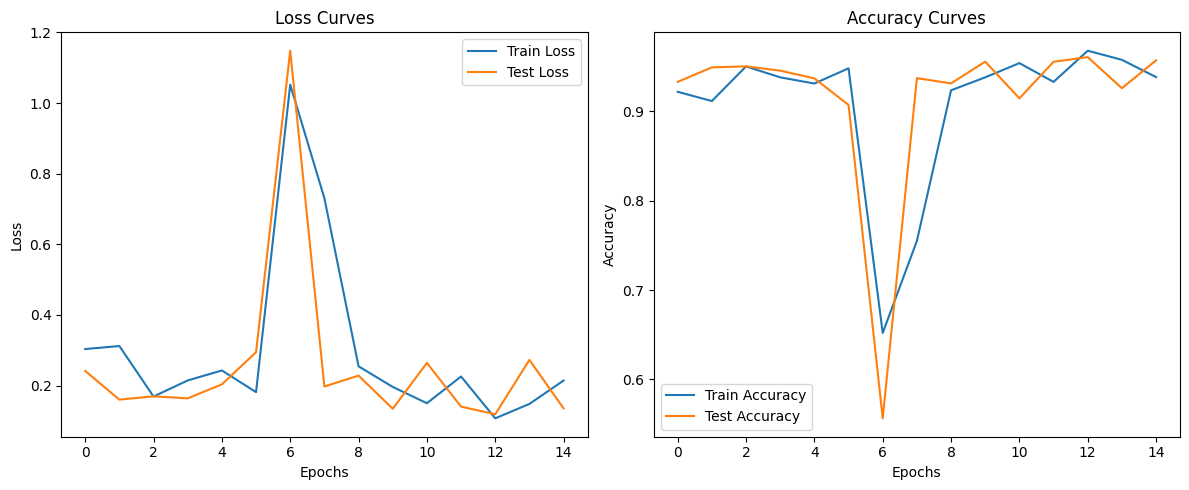

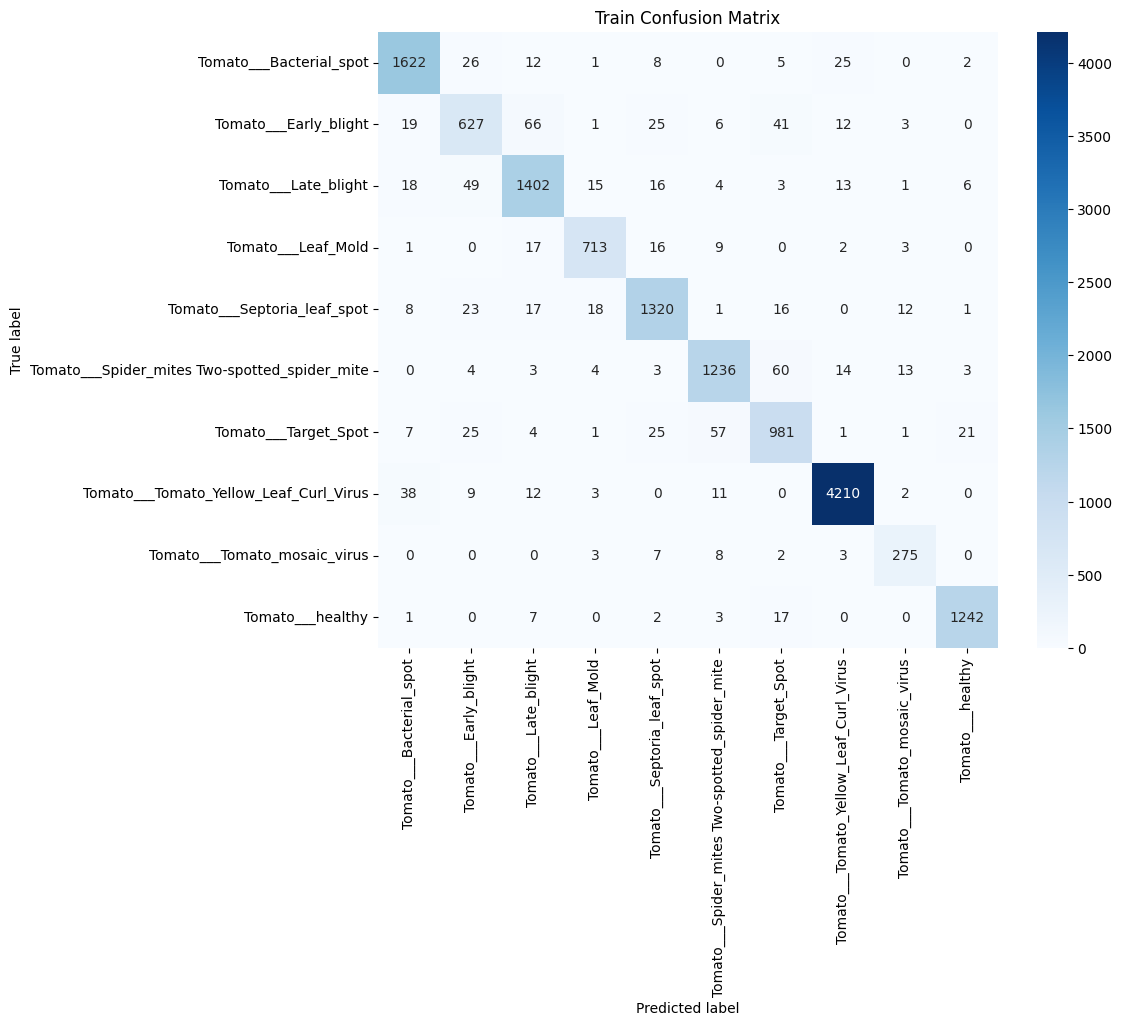

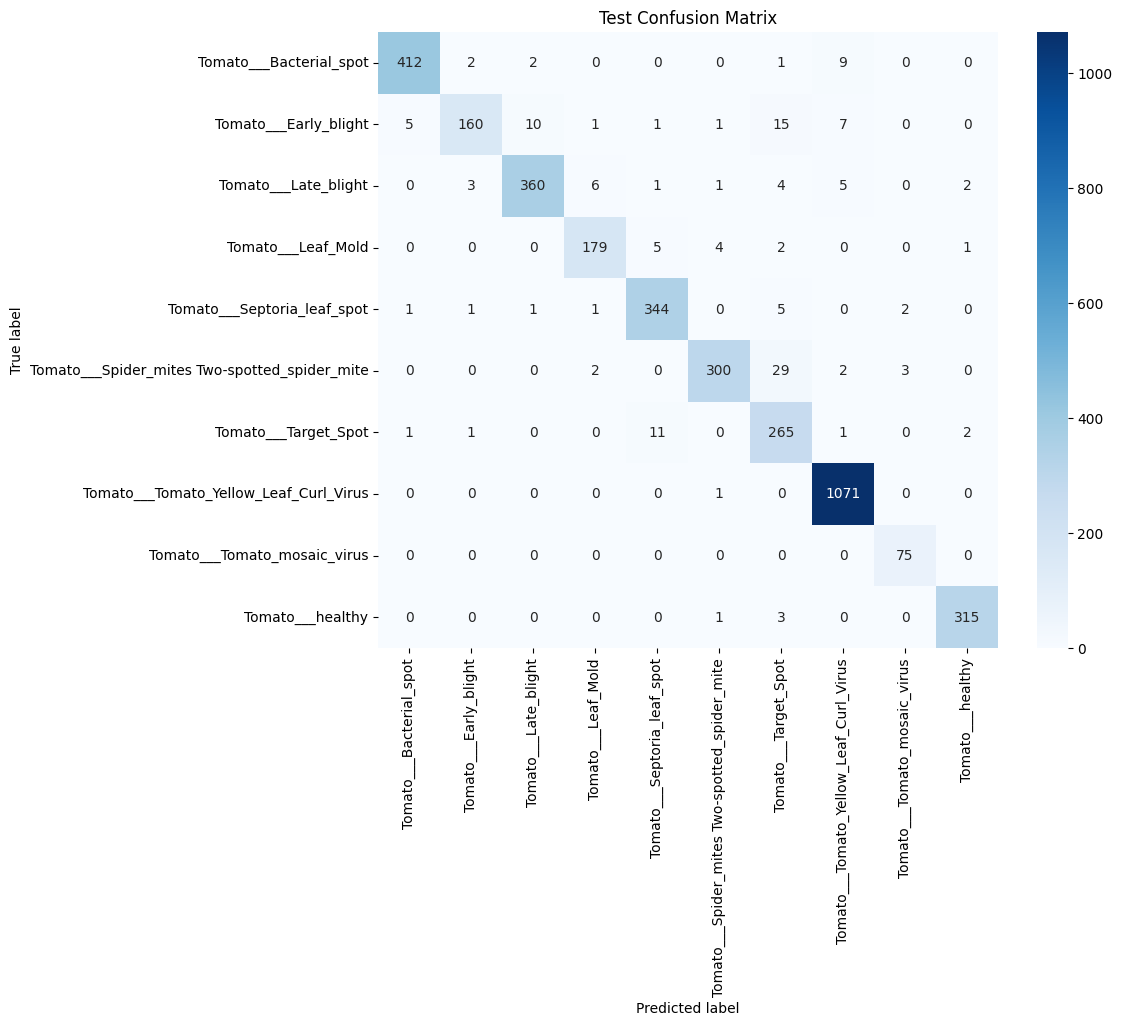

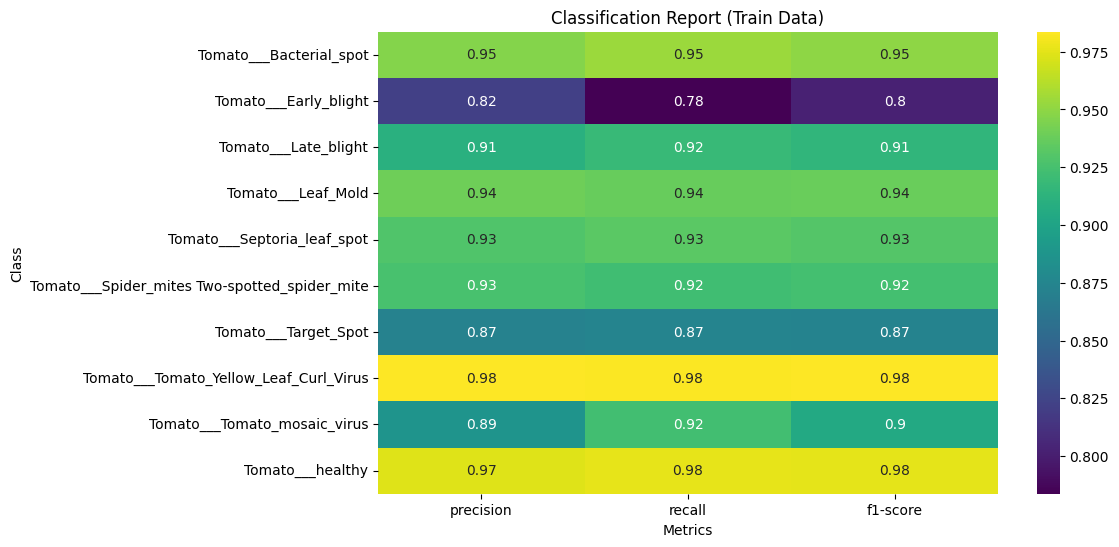

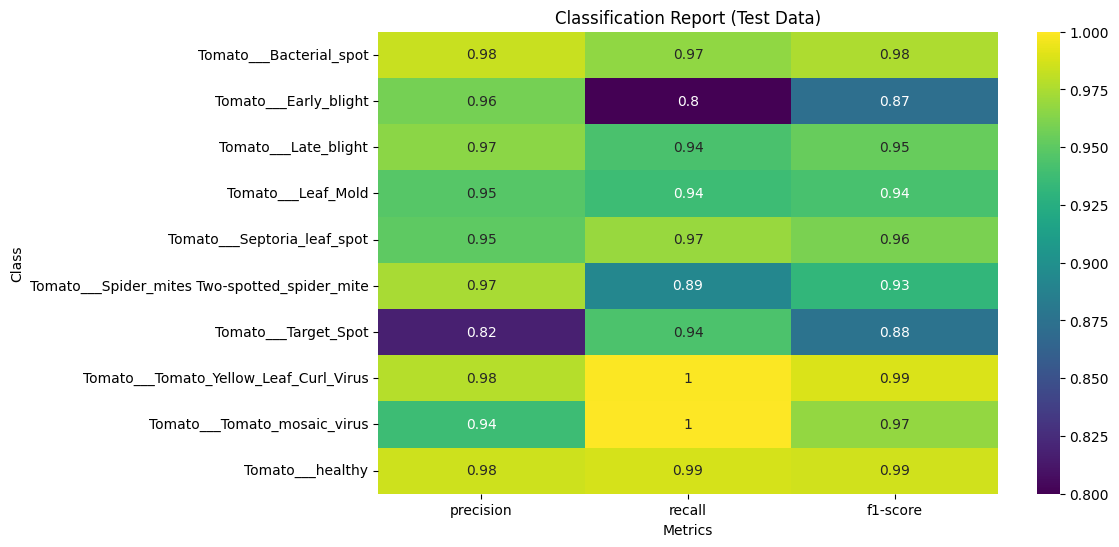

In [ ]:
# Po uruchomieniu funkcji train i zebraniu wyników w results
results = alex_64_adam_color_results
# Wyświetlenie tabel z wynikami
display_metrics(results)

# Narysowanie wykresów loss i accuracy
plot_curves(results)

# Wyświetlenie macierzy pomyłek
display_confusion_matrices(results, class_names)

plot_classification_reports(results, class_names)

### 10.1.2 AlexNet | batch=64 | optim=sgd | zdjęcia=kolor

     Metric     Train      Test
0      Loss  0.074346  0.058355
1  Accuracy  0.975283  0.979384
2    Recall  0.966703  0.972921
3  F1-score  0.967638  0.971865


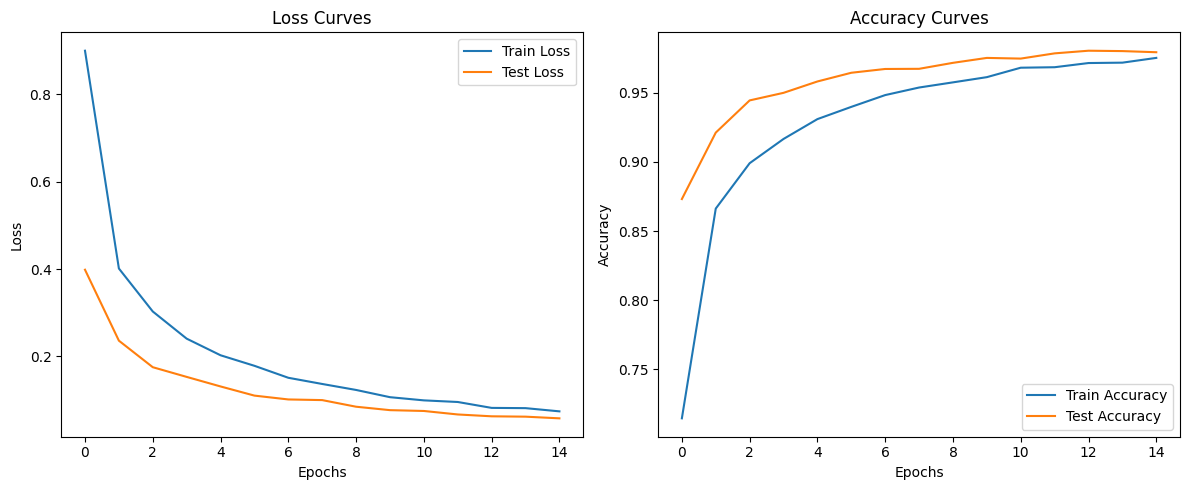

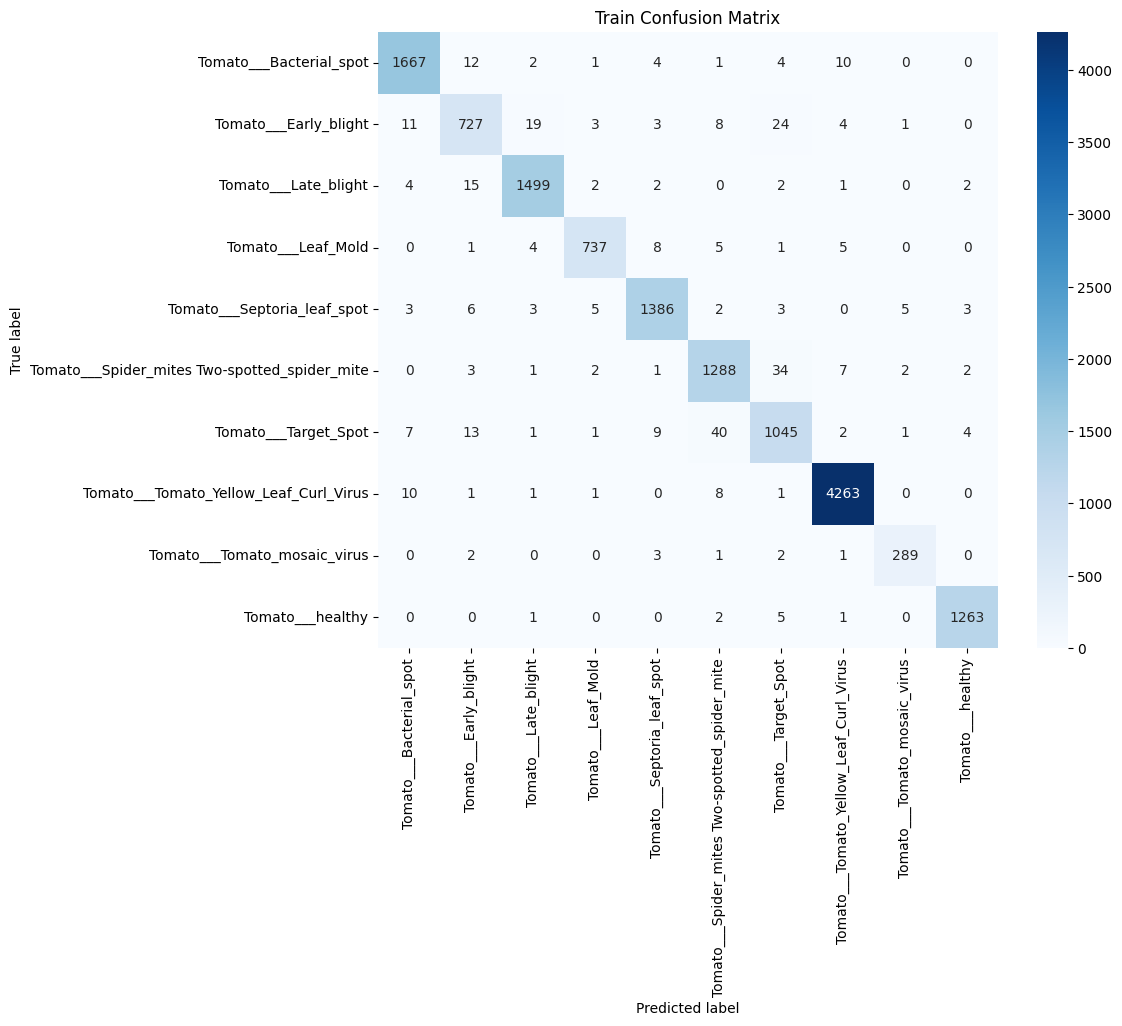

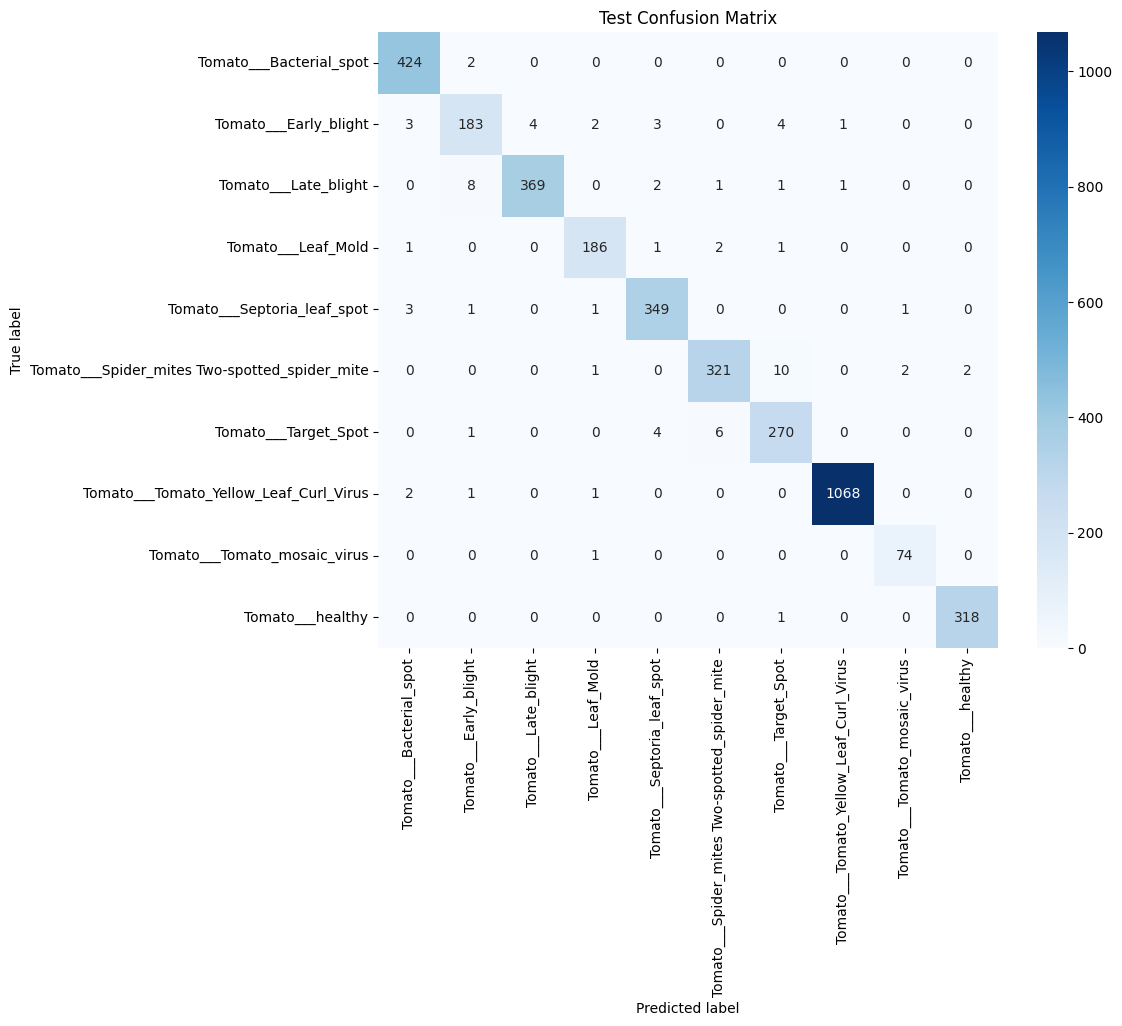

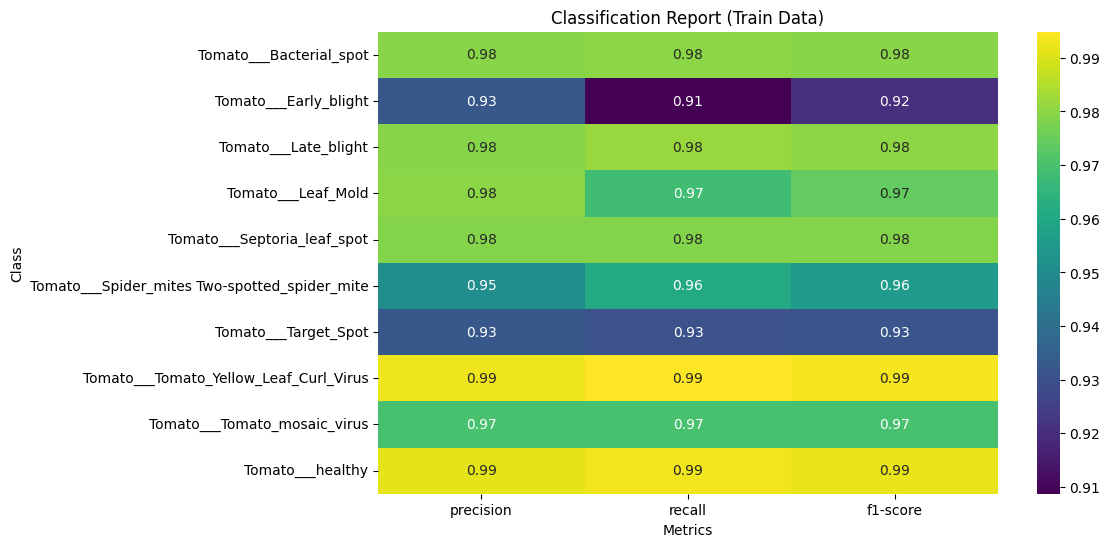

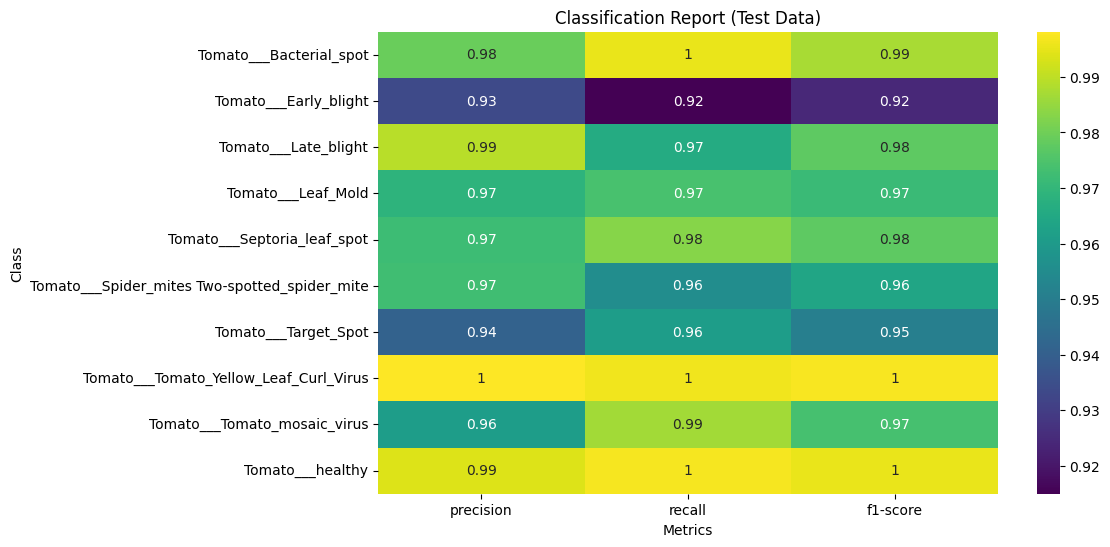

In [ ]:
# Po uruchomieniu funkcji train i zebraniu wyników w results
results = alex_64_sgd_color_results
# Wyświetlenie tabel z wynikami
display_metrics(results)

# Narysowanie wykresów loss i accuracy
plot_curves(results)

# Wyświetlenie macierzy pomyłek
display_confusion_matrices(results, class_names)
plot_classification_reports(results, class_names)

### 10.1.3 AlexNet | batch=64 | optim=adam | zdjęcia=szarość

     Metric     Train      Test
0      Loss  0.163470  0.171054
1  Accuracy  0.939966  0.940733
2    Recall  0.921243  0.918118
3  F1-score  0.922662  0.917249


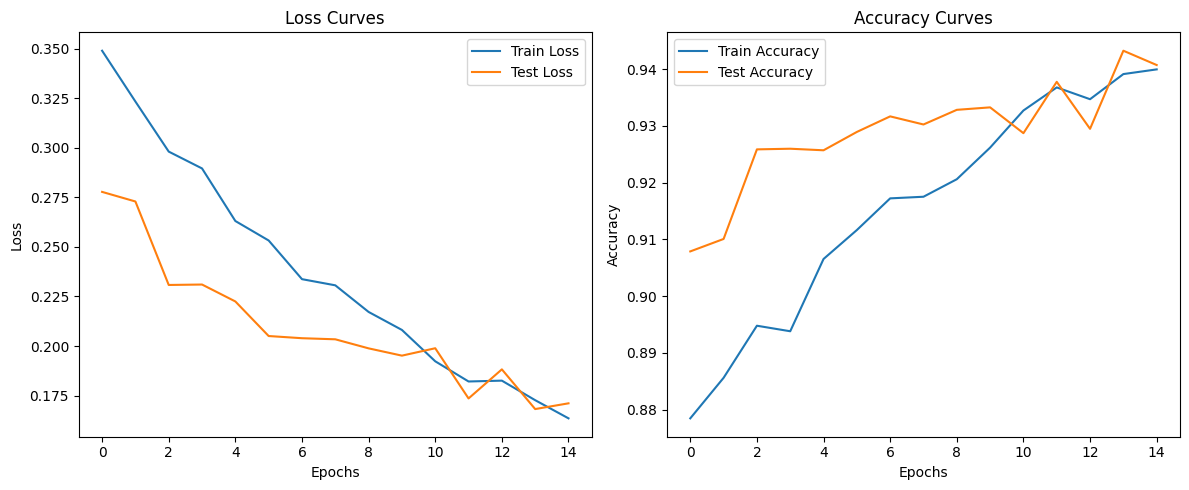

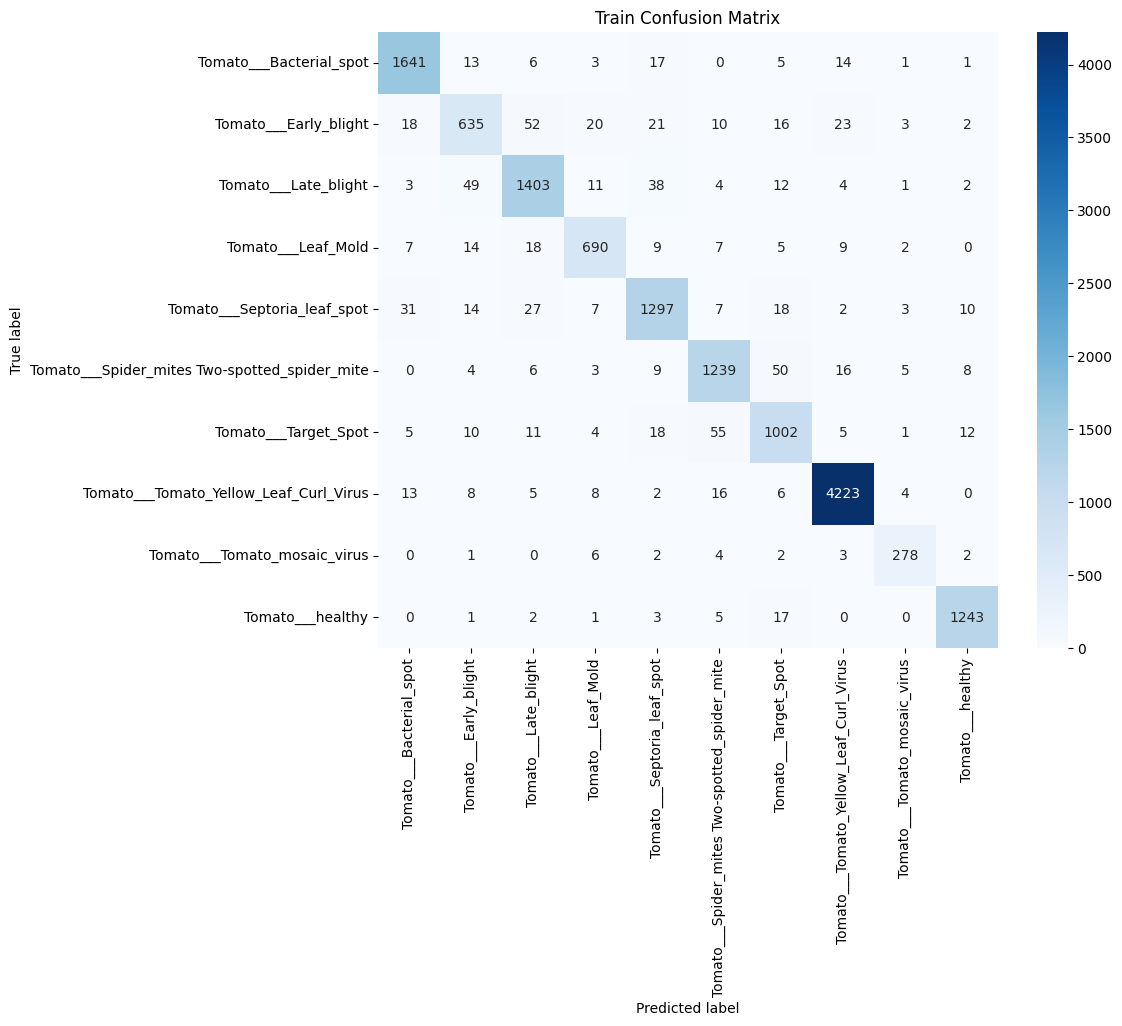

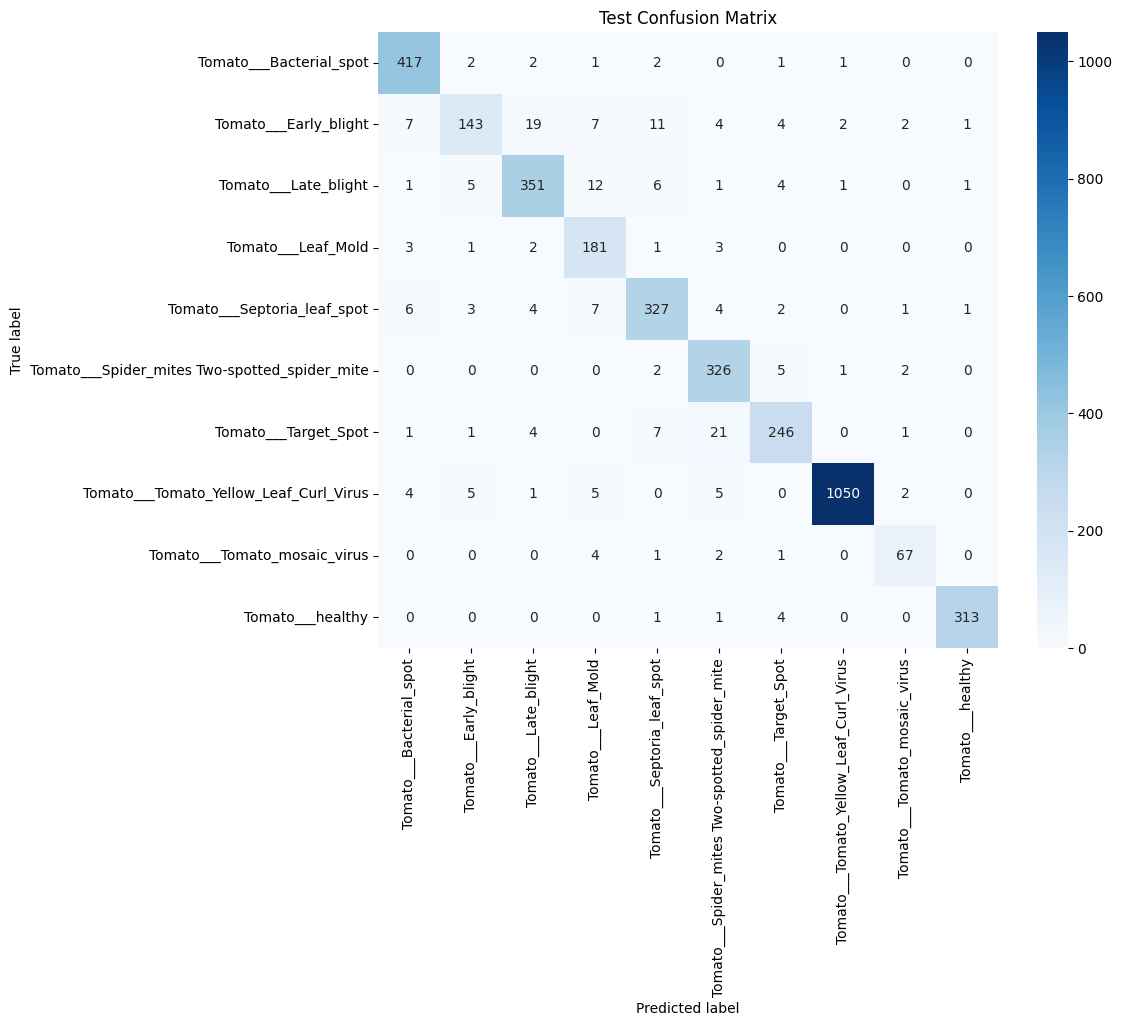

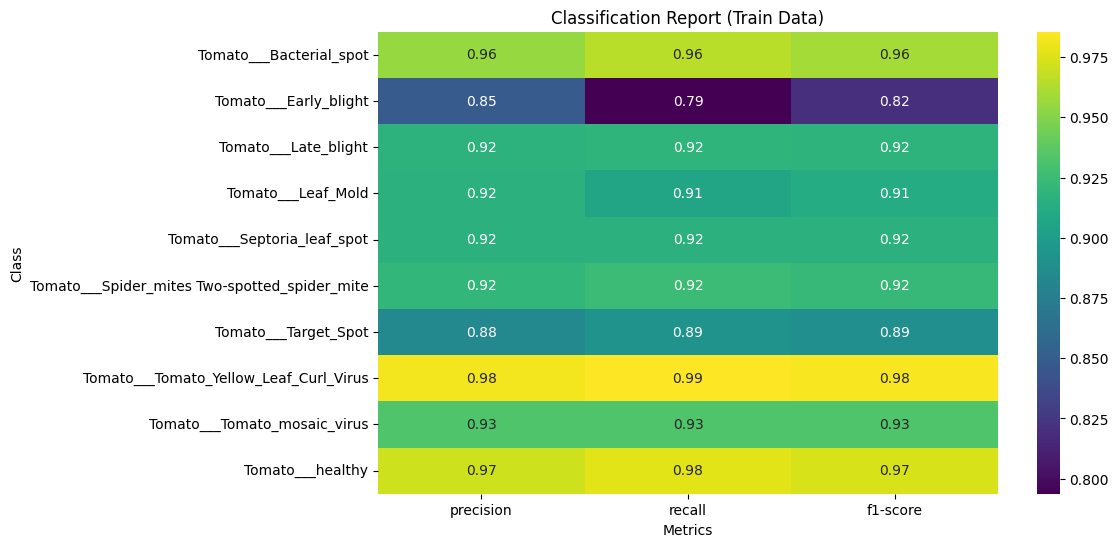

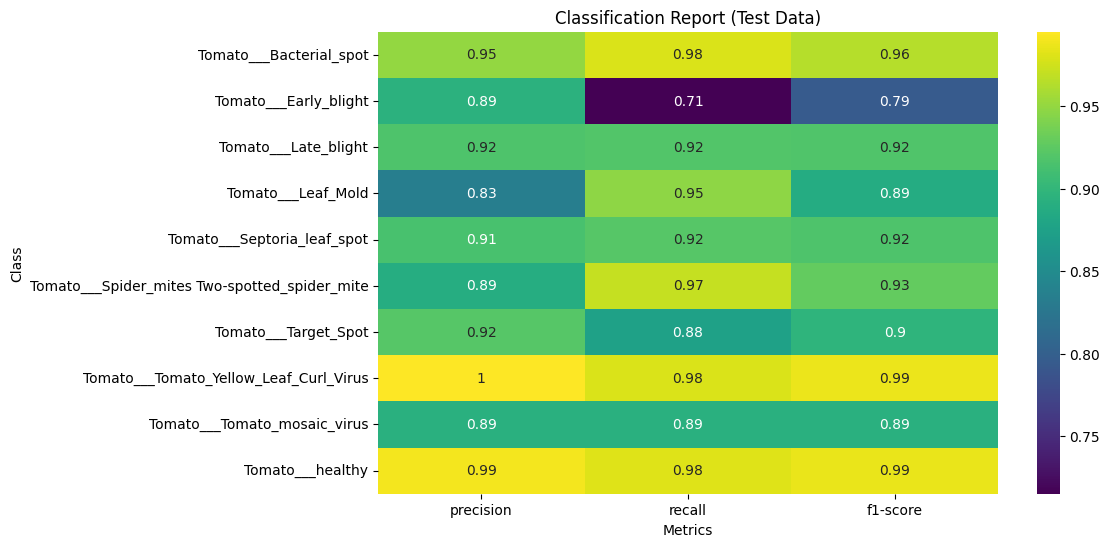

In [ ]:
# Po uruchomieniu funkcji train i zebraniu wyników w results
results = alex_64_adam_gray_results
# Wyświetlenie tabel z wynikami
display_metrics(results)

# Narysowanie wykresów loss i accuracy
plot_curves(results)

# Wyświetlenie macierzy pomyłek
display_confusion_matrices(results, class_names)

plot_classification_reports(results, class_names)

### 10.1.4 AlexNet | batch=64 | optim=sgd | zdjęcia=szarość

     Metric     Train      Test
0      Loss  0.211426  0.194075
1  Accuracy  0.924685  0.929711
2    Recall  0.900409  0.904135
3  F1-score  0.901834  0.905290


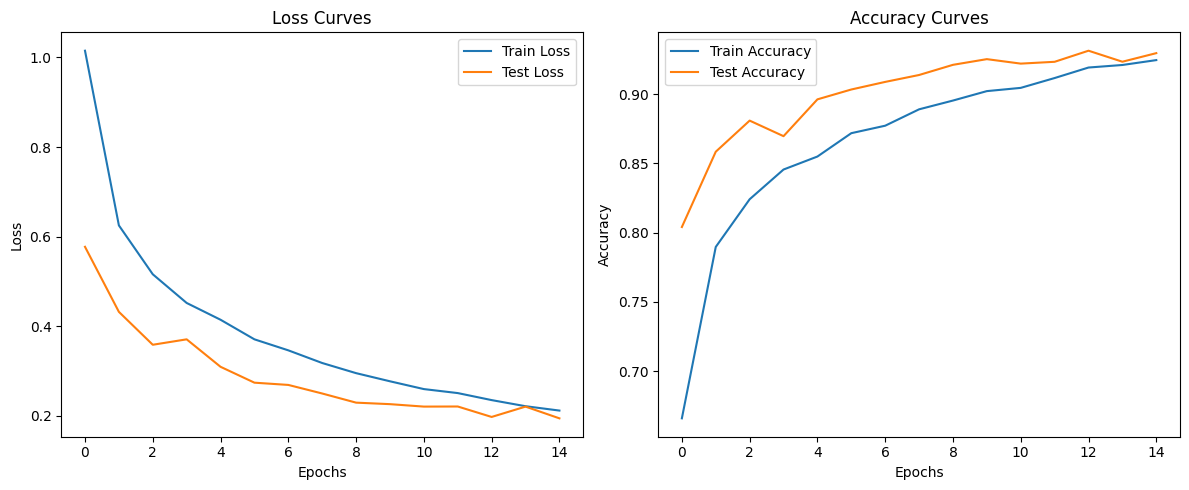

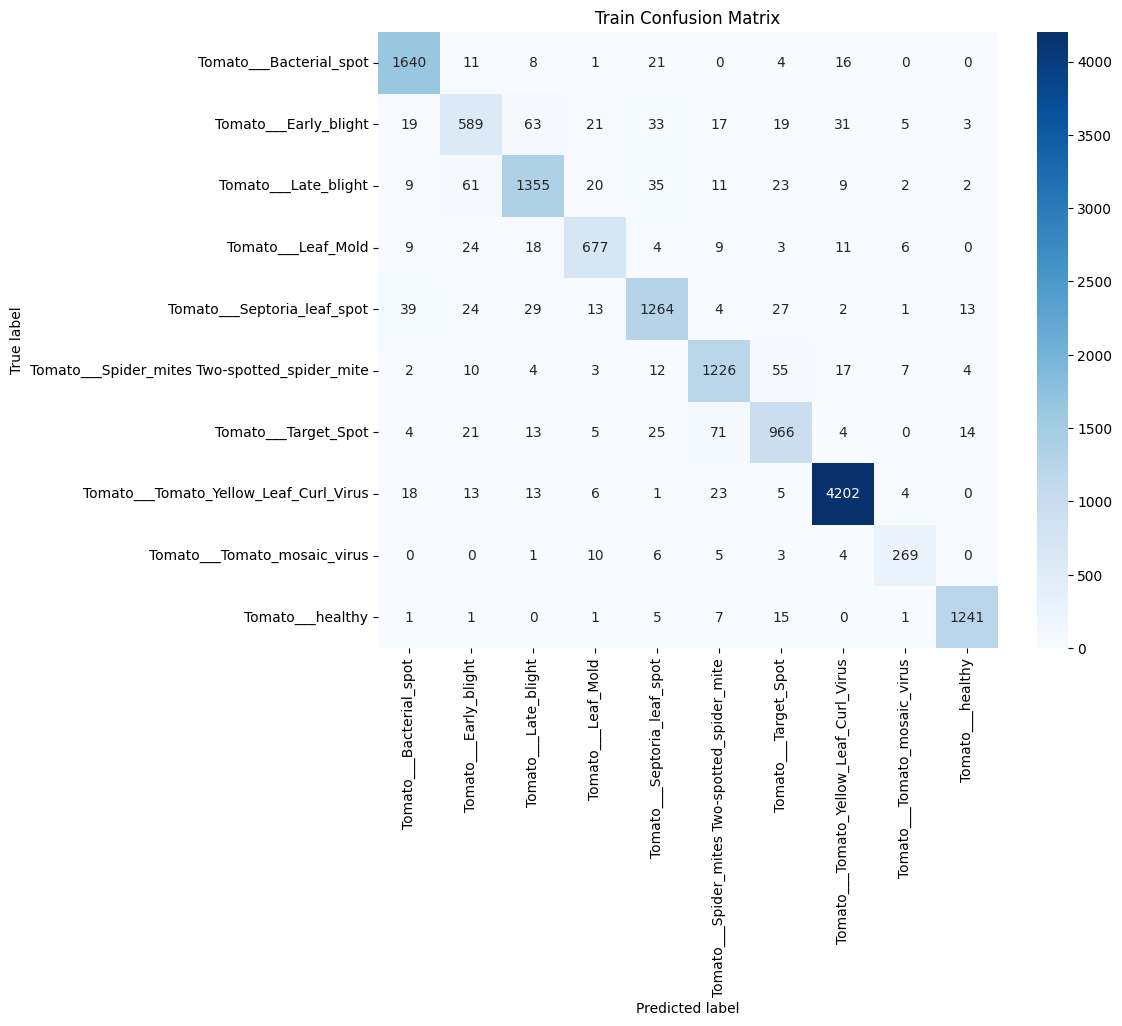

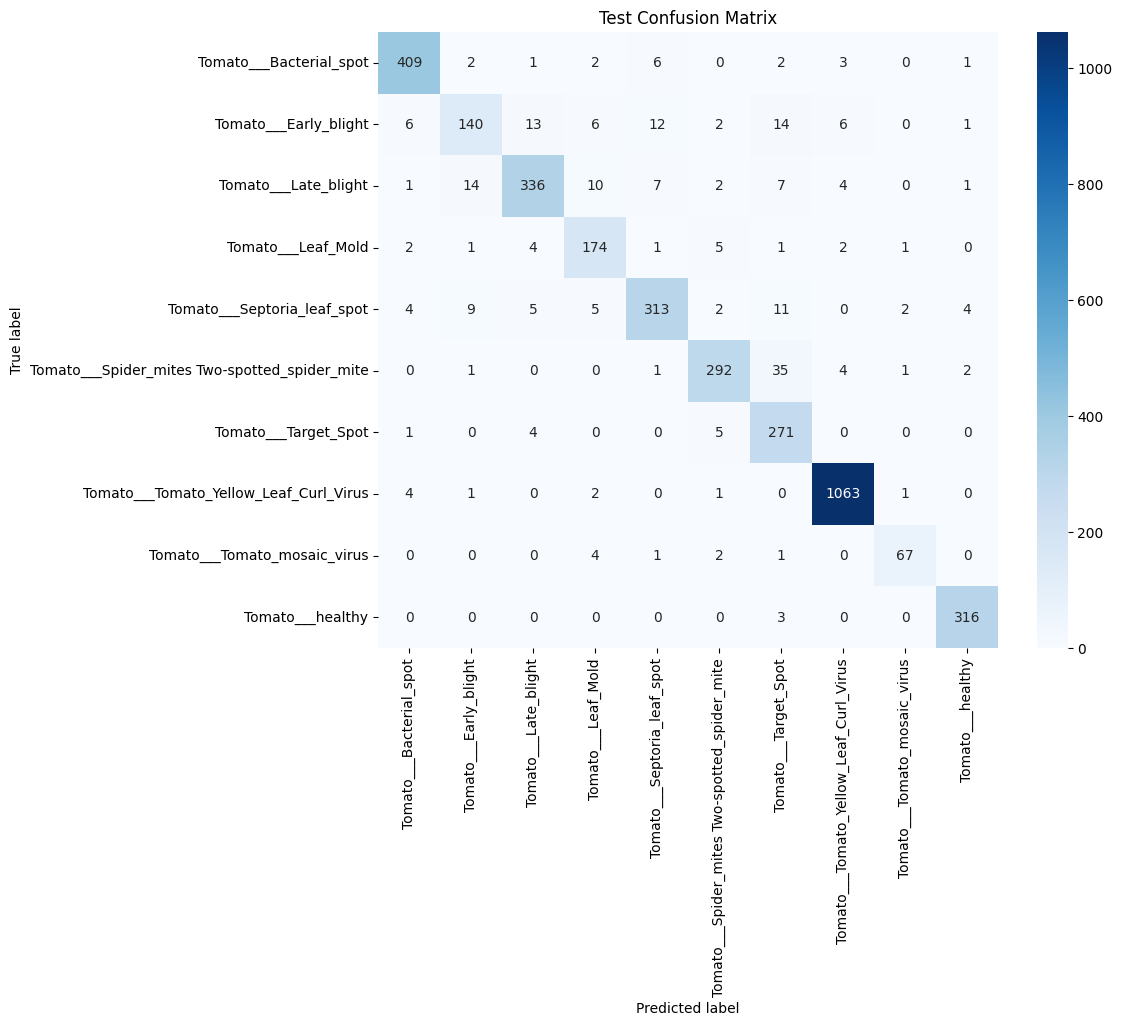

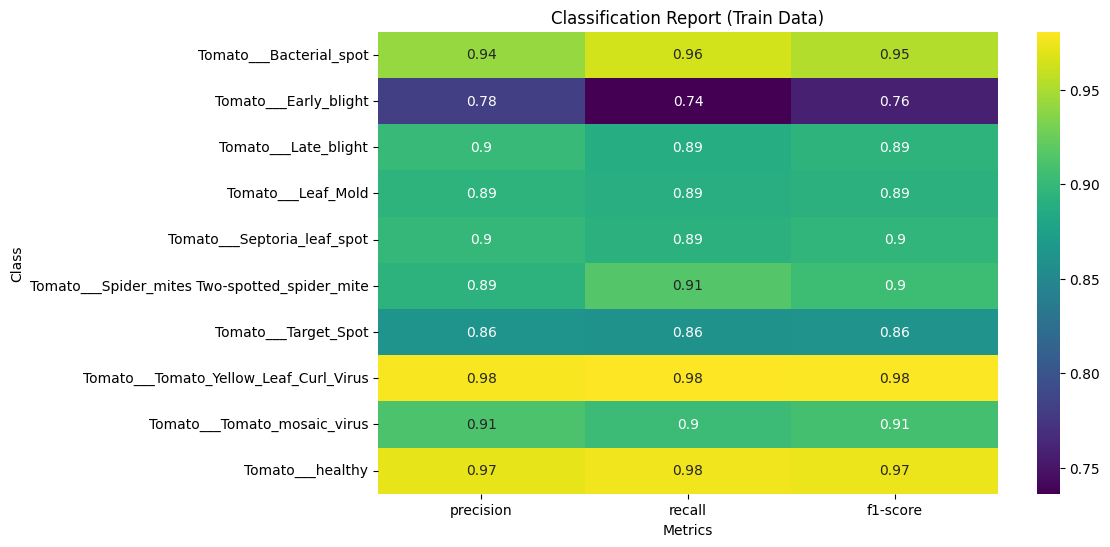

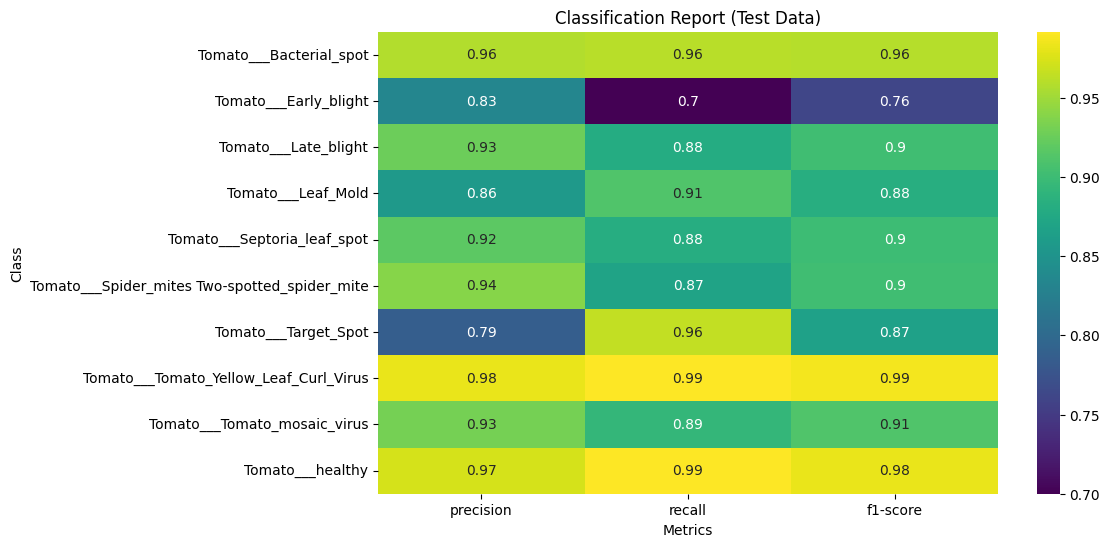

In [ ]:
# Po uruchomieniu funkcji train i zebraniu wyników w results
results = alex_64_sgd_gray_results
# Wyświetlenie tabel z wynikami
display_metrics(results)

# Narysowanie wykresów loss i accuracy
plot_curves(results)

# Wyświetlenie macierzy pomyłek
display_confusion_matrices(results, class_names)

plot_classification_reports(results, class_names)

## 10.2 GoogLeNet

### 10.2.1 GoogLeNet | batch=64 | optim=adam | zdjęcia=kolor

     Metric     Train      Test
0      Loss  0.020293  0.053020
1  Accuracy  0.993254  0.985632
2    Recall  0.991371  0.981168
3  F1-score  0.991365  0.981911


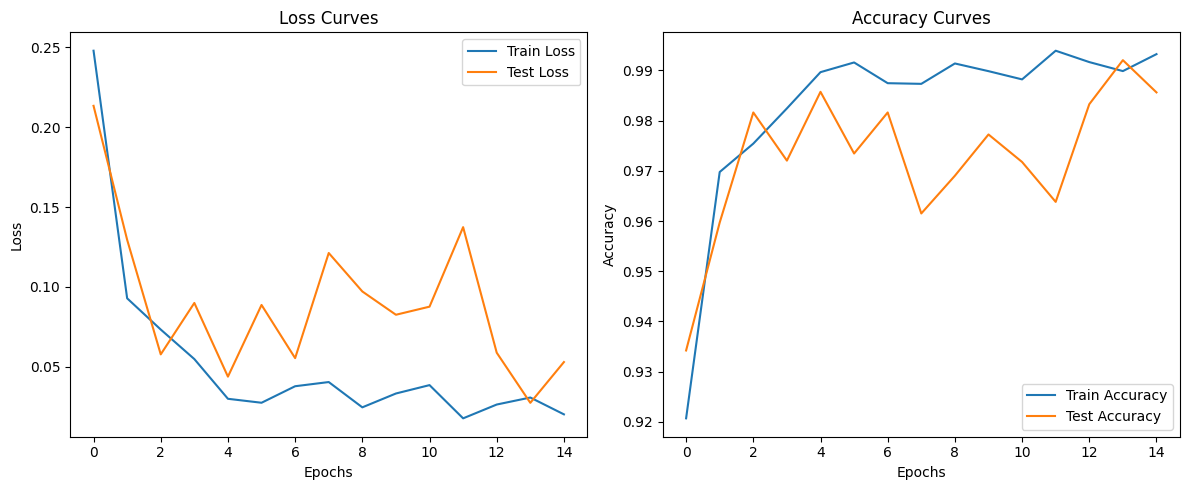

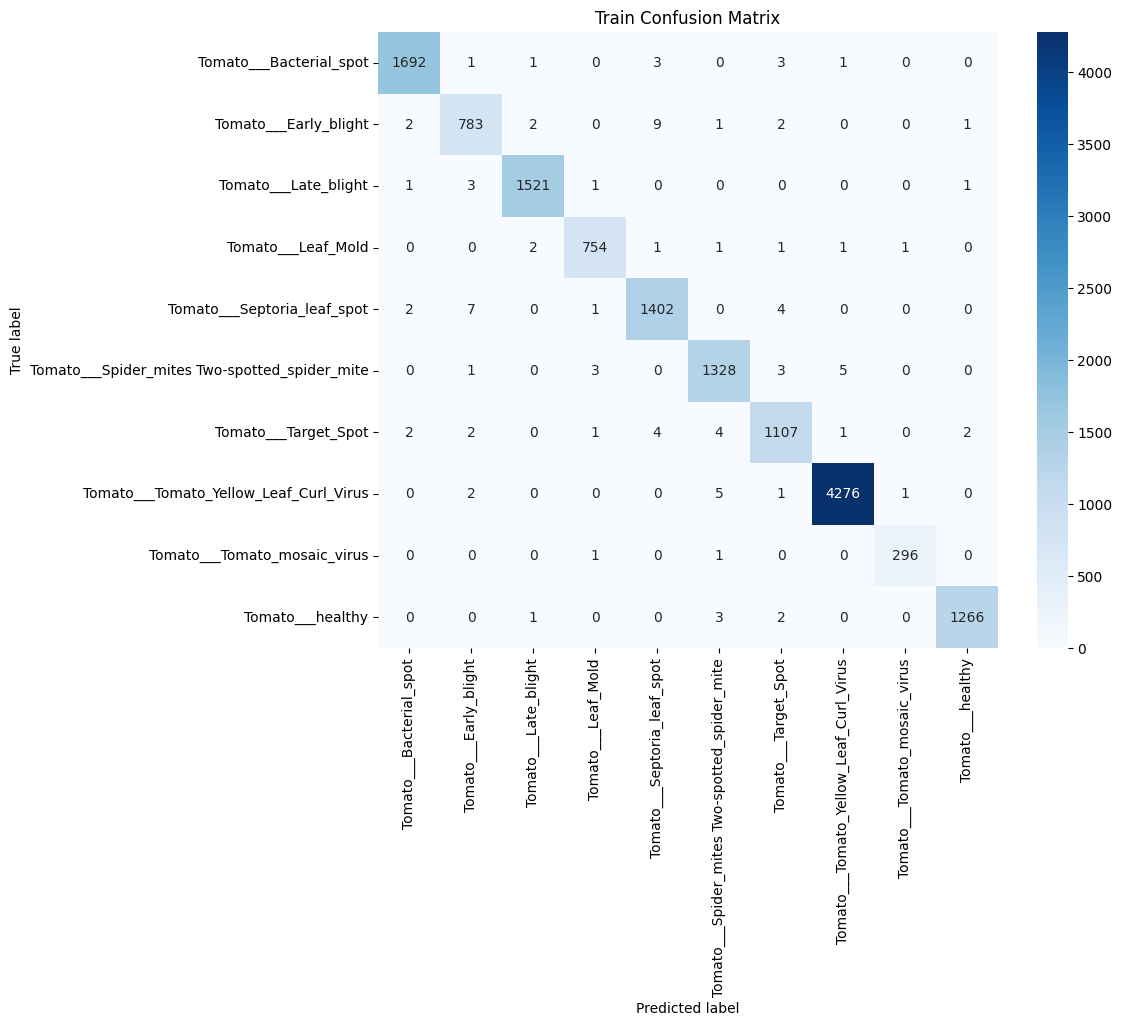

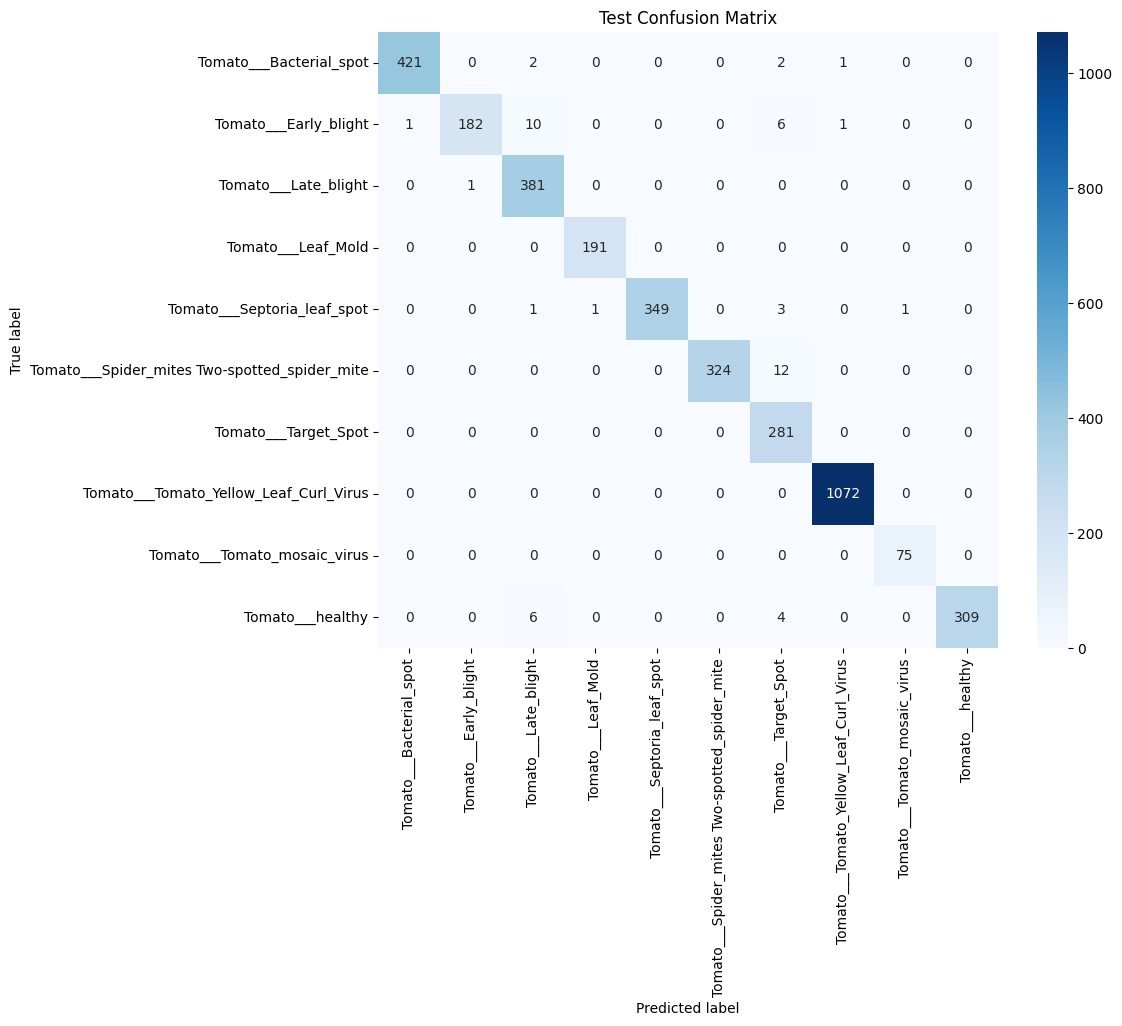

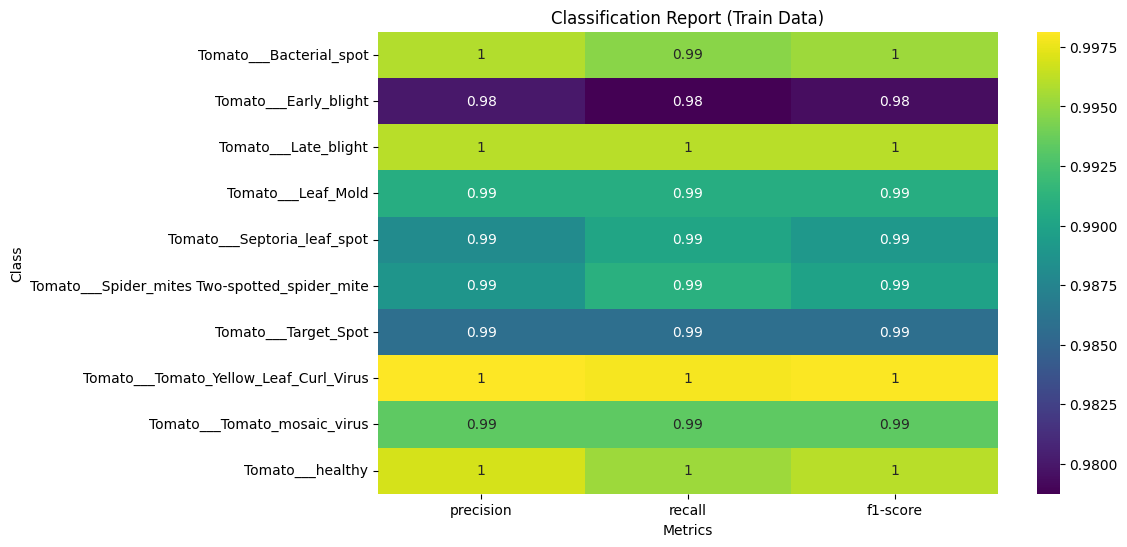

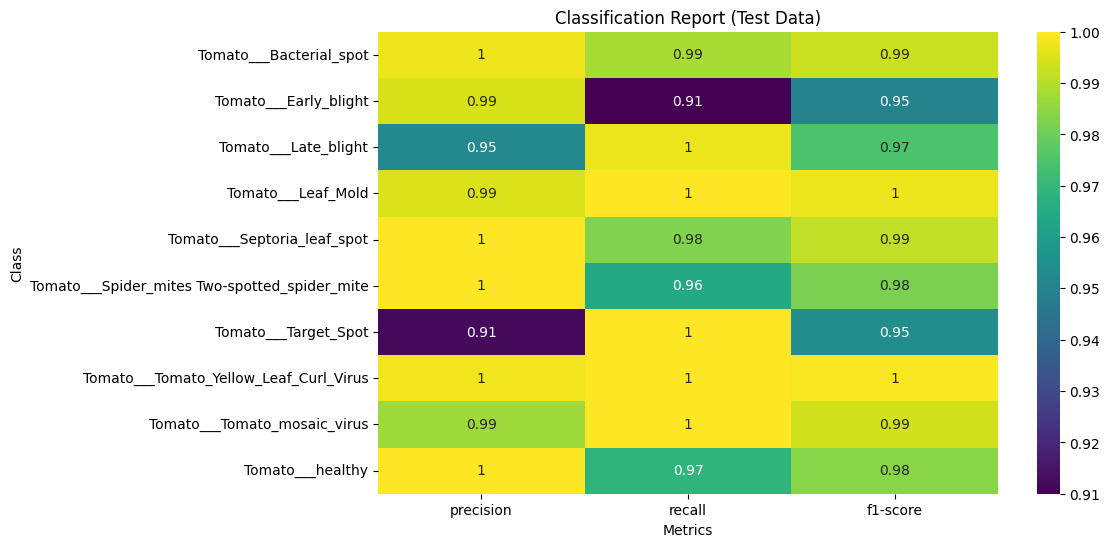

In [ ]:
# Po uruchomieniu funkcji train i zebraniu wyników w results
results = google_64_adam_color_results
# Wyświetlenie tabel z wynikami
display_metrics(results)

# Narysowanie wykresów loss i accuracy
plot_curves(results)

# Wyświetlenie macierzy pomyłek
display_confusion_matrices(results, class_names)

plot_classification_reports(results, class_names)

### 10.2.2 GoogLeNet | batch=64 | optim=sgd | zdjęcia=kolor

     Metric     Train      Test
0      Loss  0.390690  0.342904
1  Accuracy  0.901127  0.912772
2    Recall  0.812340  0.831424
3  F1-score  0.826433  0.847613


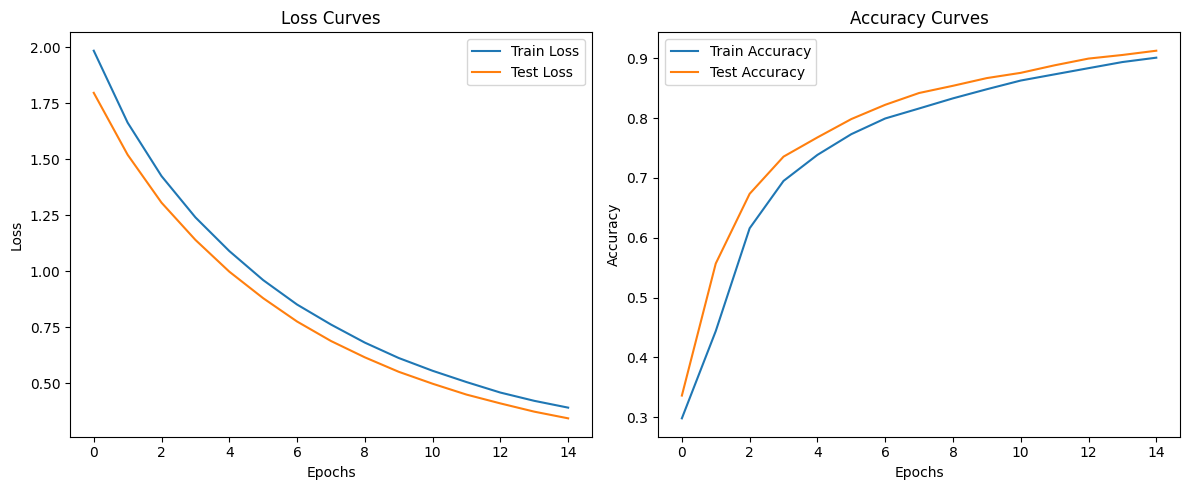

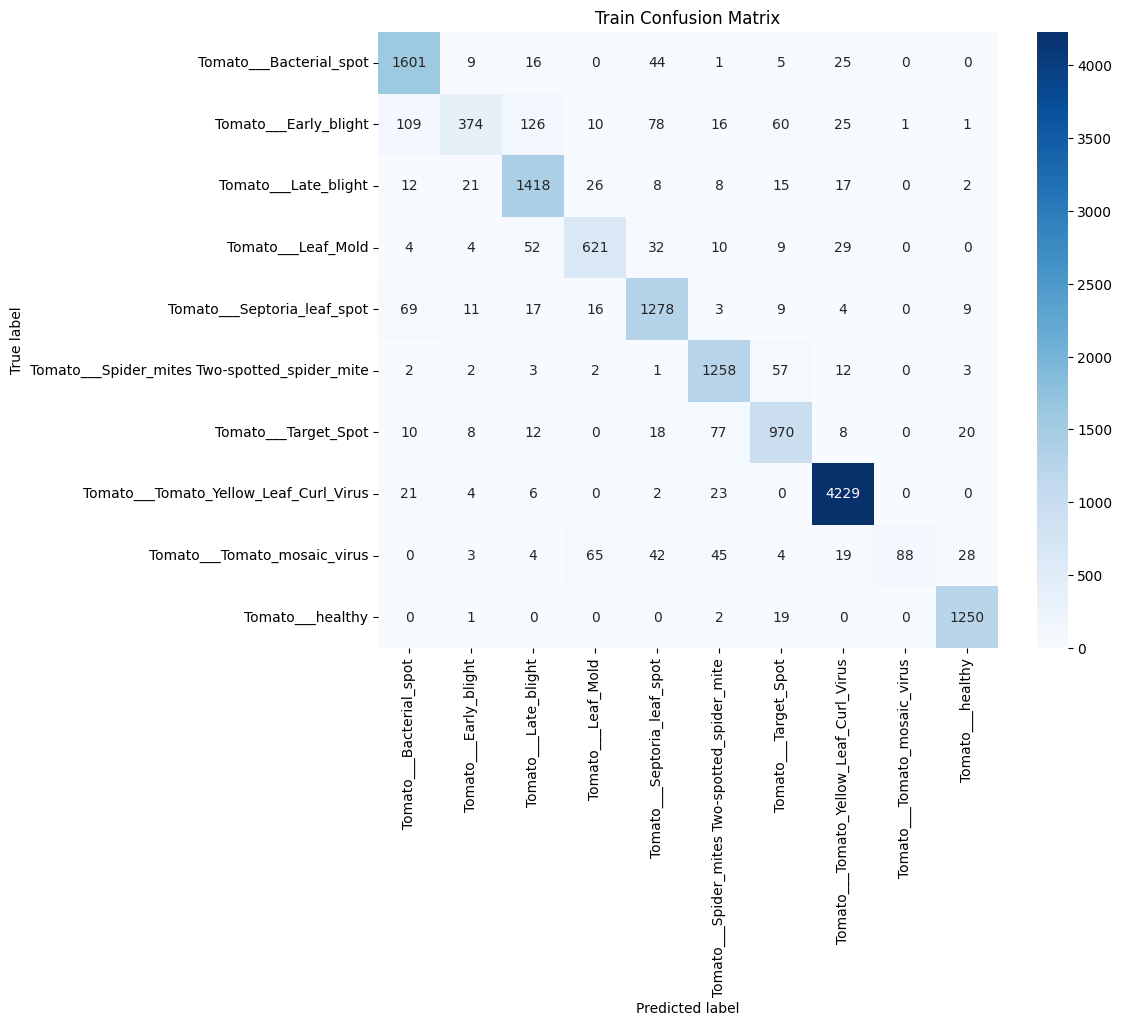

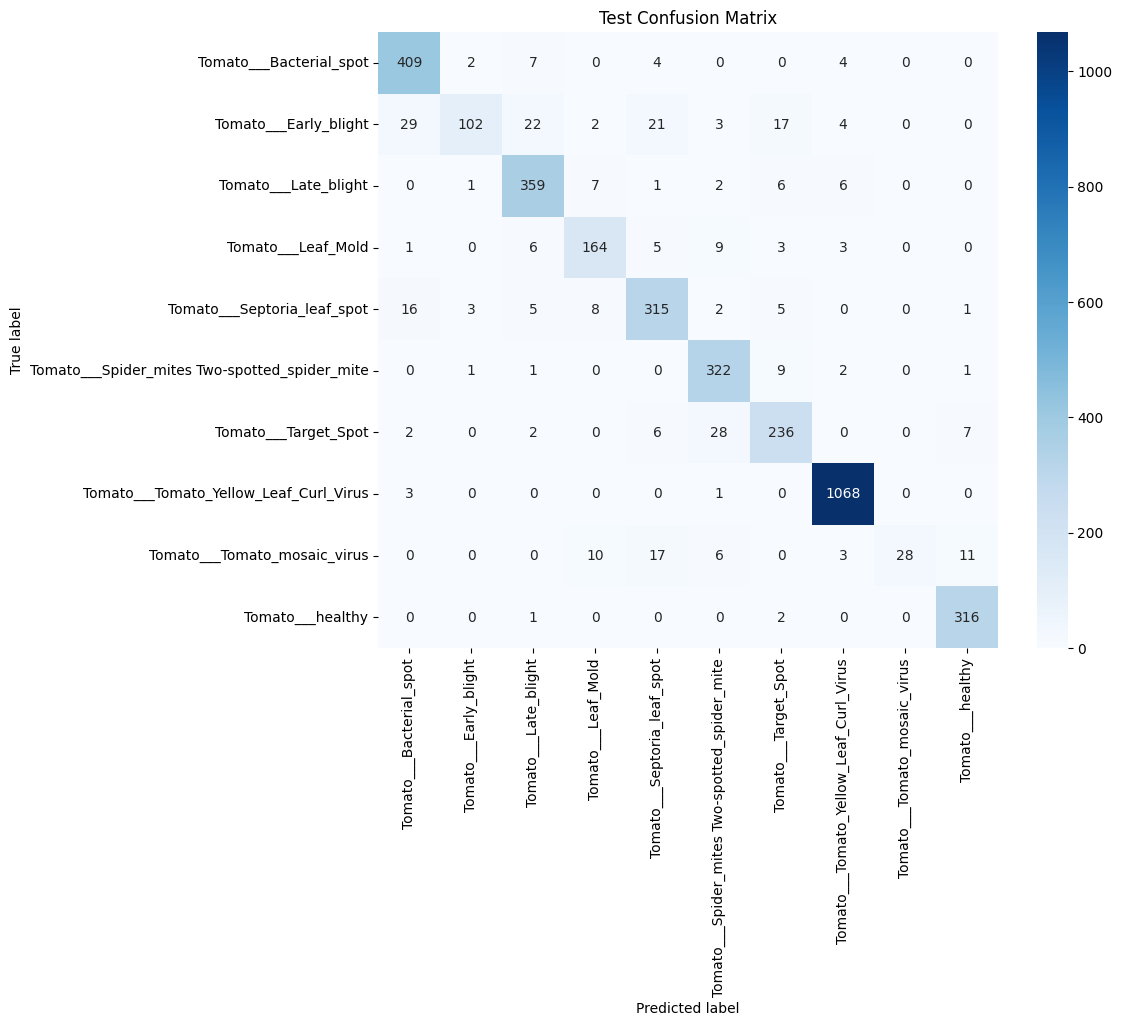

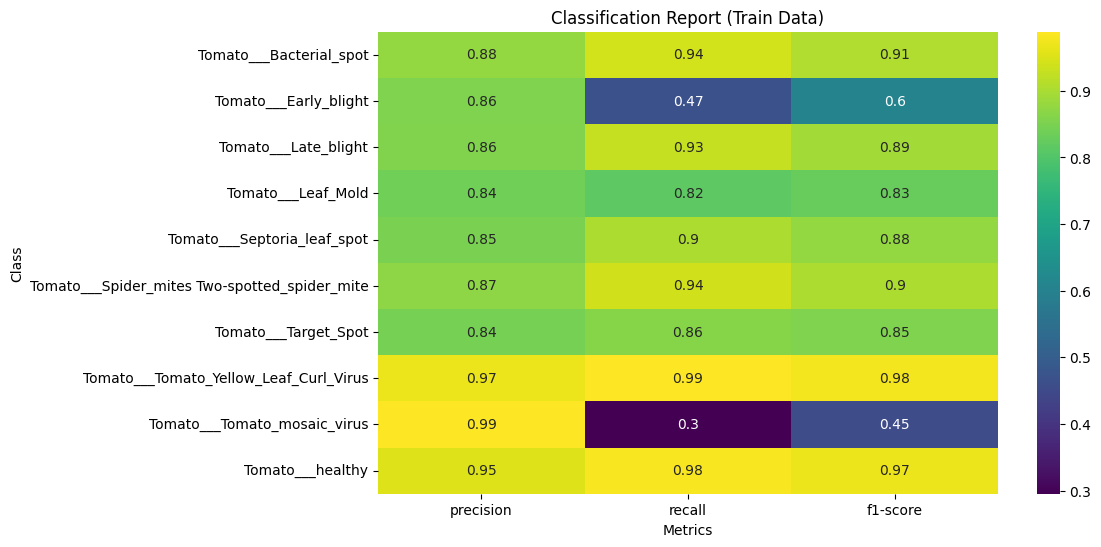

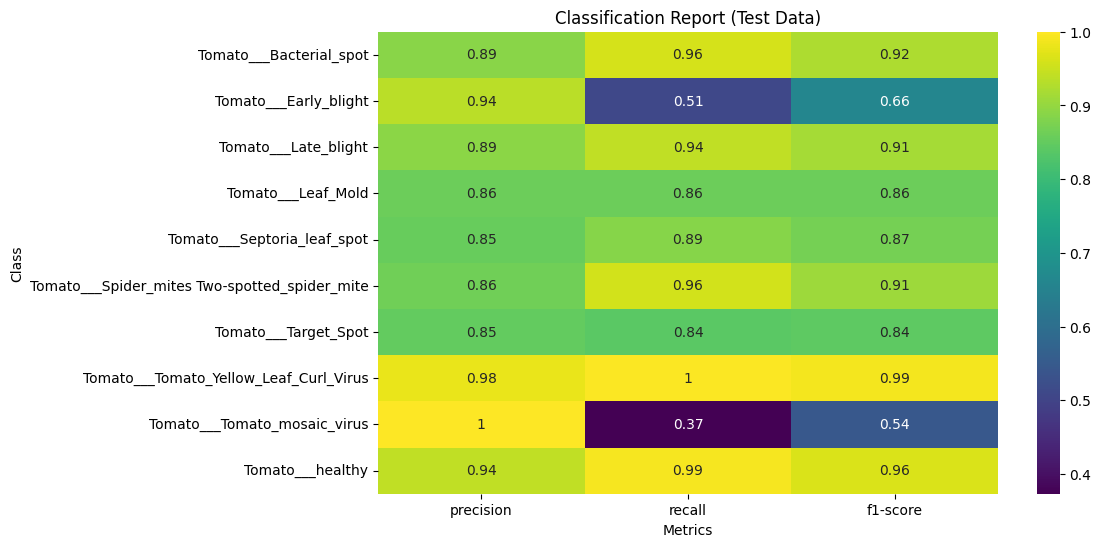

In [ ]:
# Po uruchomieniu funkcji train i zebraniu wyników w results
results = google_64_sgd_color_results
# Wyświetlenie tabel z wynikami
display_metrics(results)

# Narysowanie wykresów loss i accuracy
plot_curves(results)

# Wyświetlenie macierzy pomyłek
display_confusion_matrices(results, class_names)

plot_classification_reports(results, class_names)

### 10.2.3 GoogLeNet | batch=64 | optim=adam | zdjęcia=szarość

     Metric     Train      Test
0      Loss  0.029376  0.178345
1  Accuracy  0.990570  0.946546
2    Recall  0.987098  0.929313
3  F1-score  0.987886  0.930029


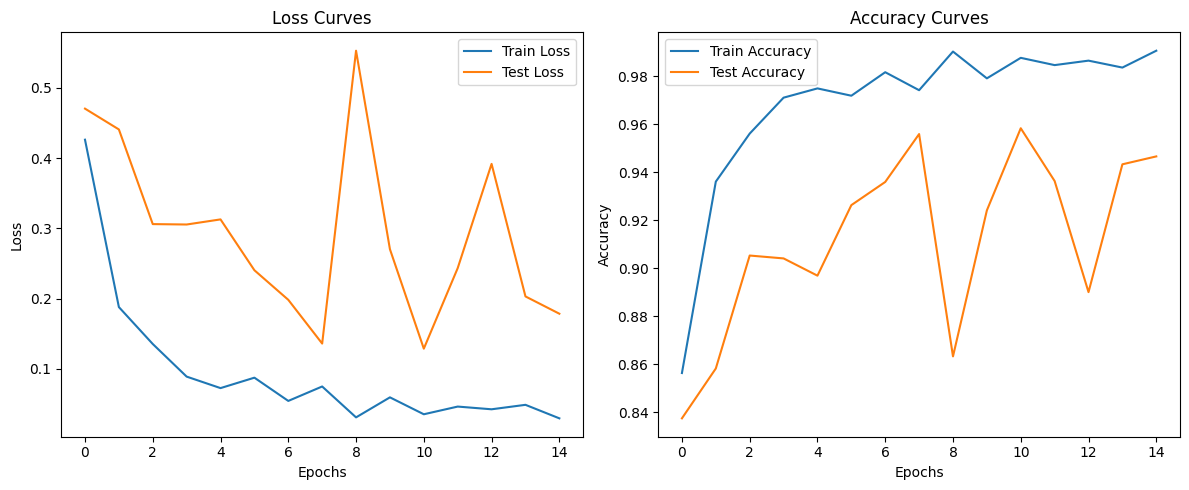

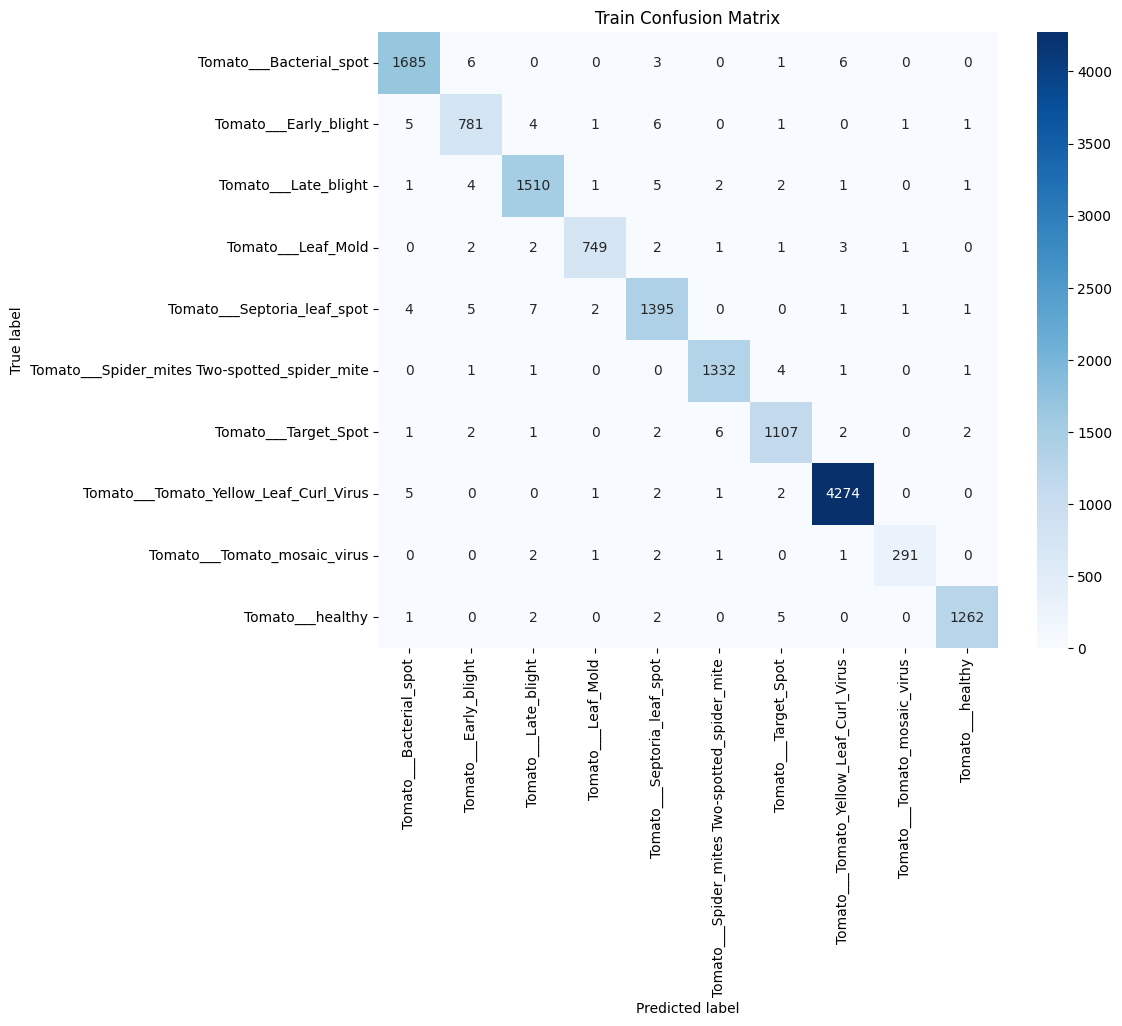

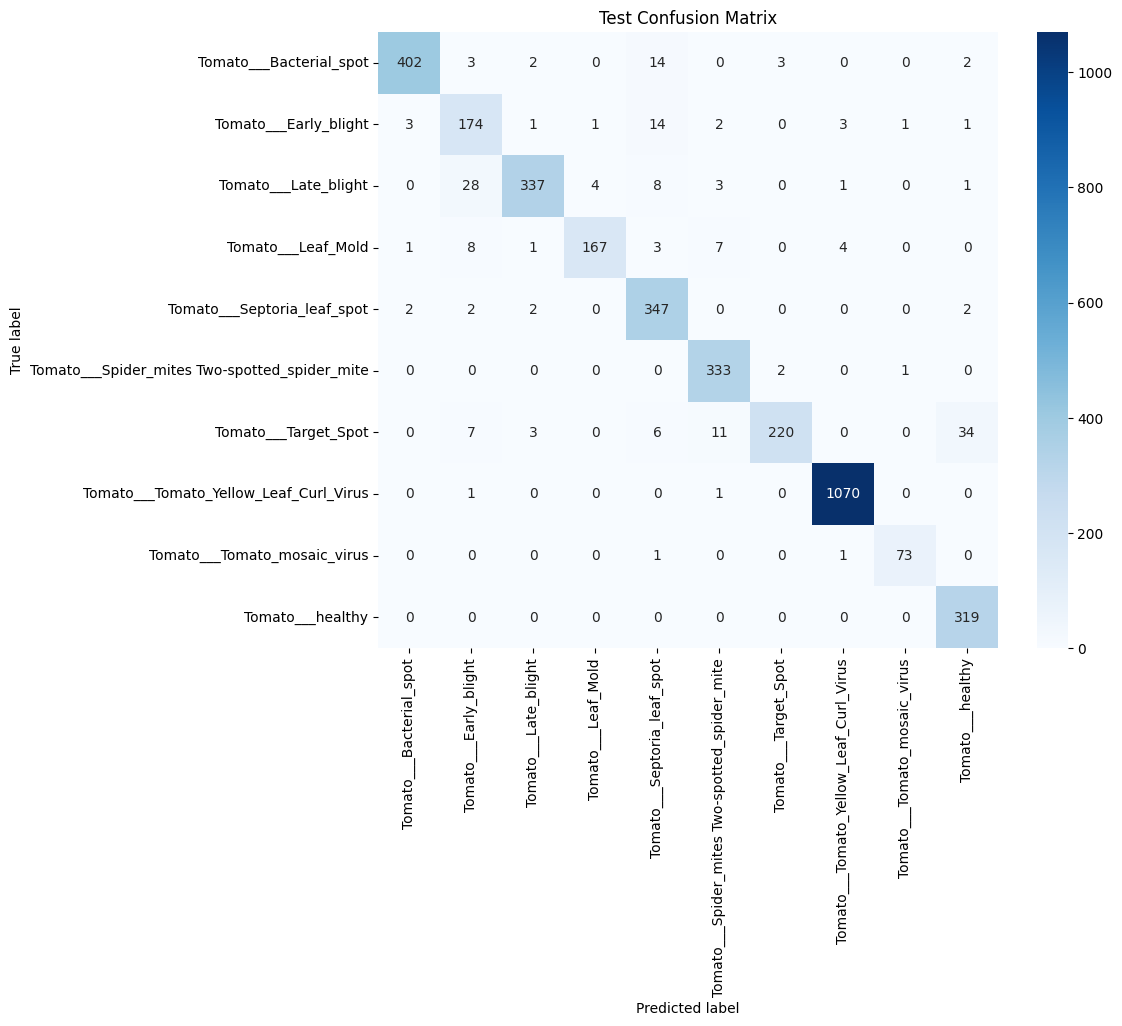

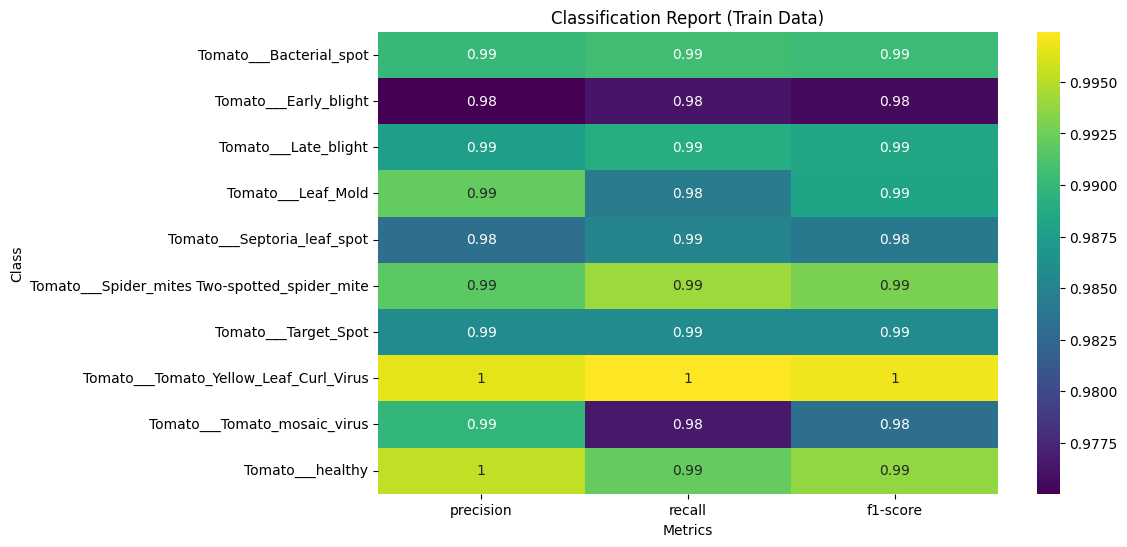

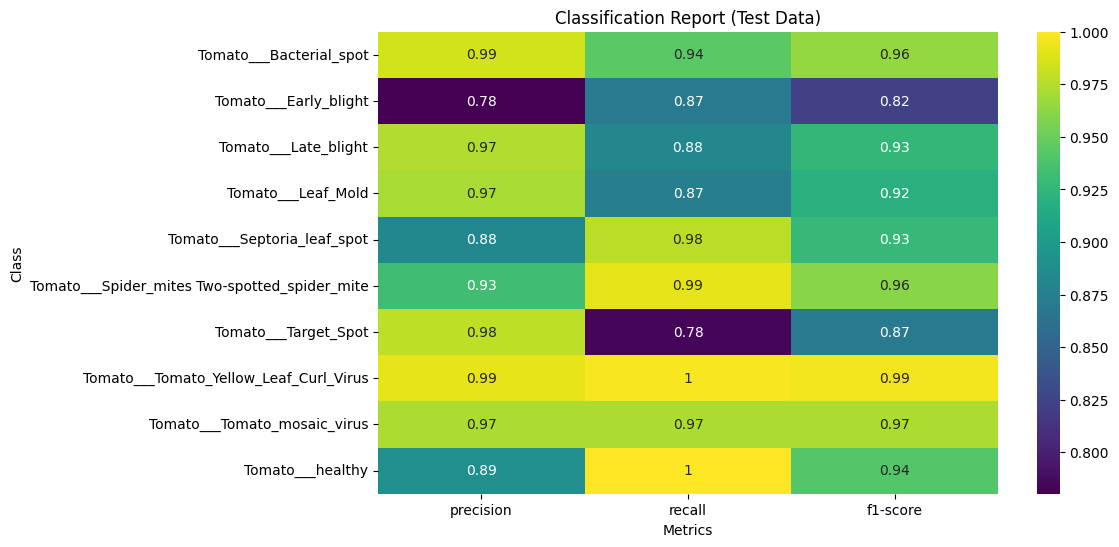

In [ ]:
# Po uruchomieniu funkcji train i zebraniu wyników w results
results = google_64_adam_gray_results
# Wyświetlenie tabel z wynikami
display_metrics(results)

# Narysowanie wykresów loss i accuracy
plot_curves(results)

# Wyświetlenie macierzy pomyłek
display_confusion_matrices(results, class_names)

plot_classification_reports(results, class_names)

### 10.2.4 GoogLeNet | batch=64 | optim=sgd | zdjęcia=szarość

     Metric     Train      Test
0      Loss  0.029376  0.178345
1  Accuracy  0.990570  0.946546
2    Recall  0.987098  0.929313
3  F1-score  0.987886  0.930029


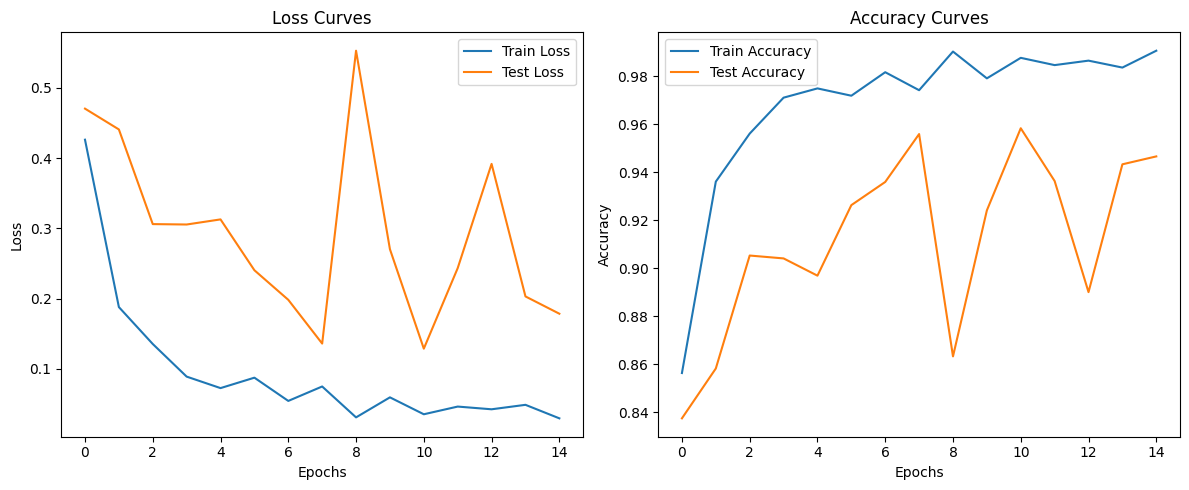

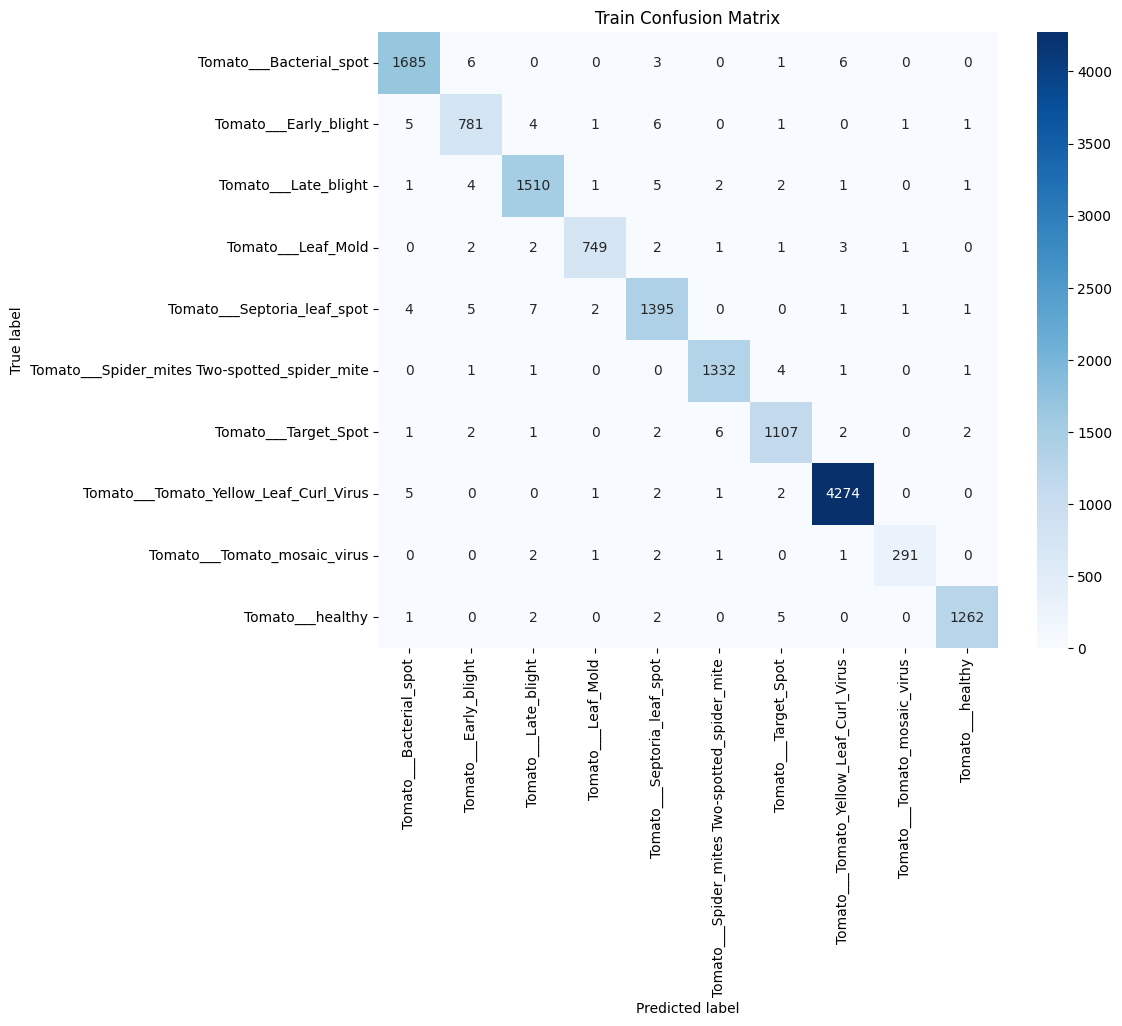

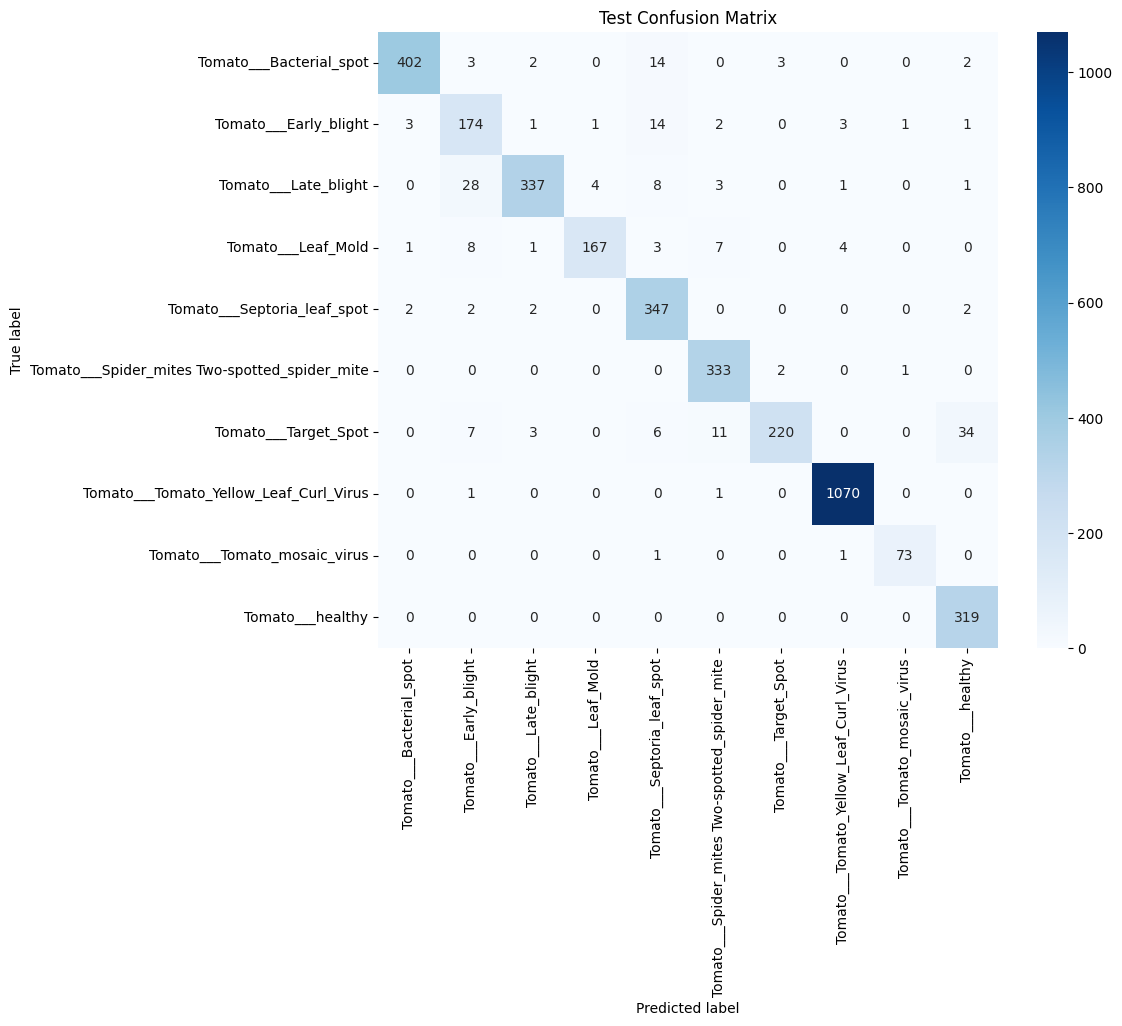

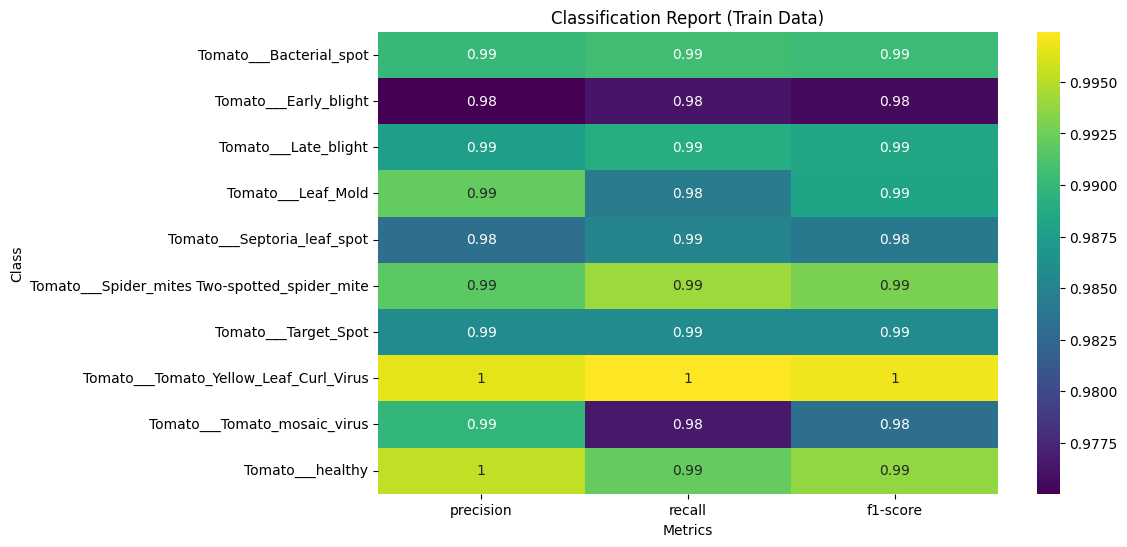

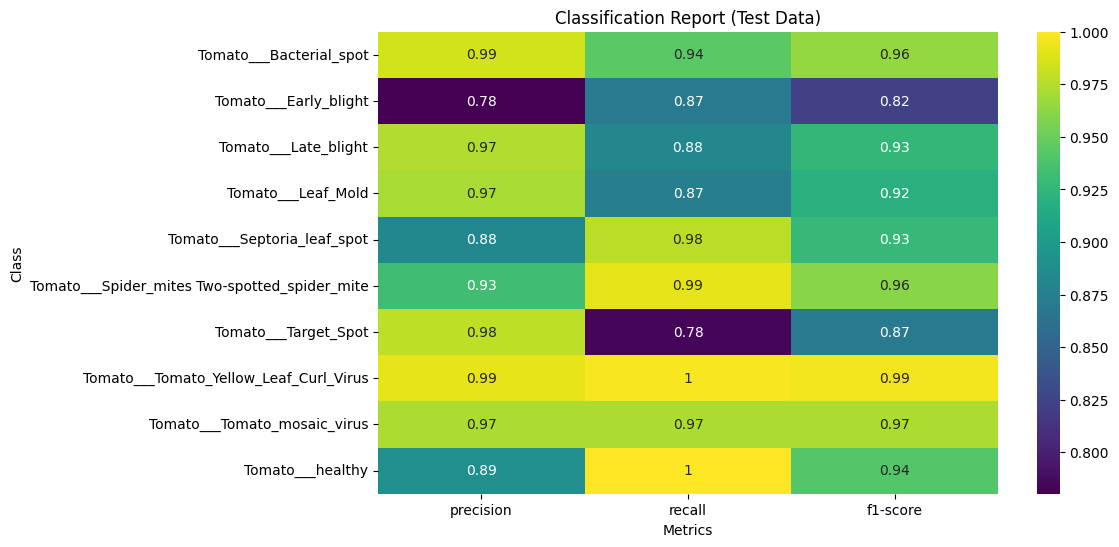

In [ ]:
# Po uruchomieniu funkcji train i zebraniu wyników w results
results = google_64_adam_gray_results
# Wyświetlenie tabel z wynikami
display_metrics(results)

# Narysowanie wykresów loss i accuracy
plot_curves(results)

# Wyświetlenie macierzy pomyłek
display_confusion_matrices(results, class_names)

plot_classification_reports(results, class_names)

## 10.3 VGG16

### 10.3.1 | batch = 64 | optymalizator = SGD | barwa = w kolorze

     Metric     Train      Test
0      Loss  0.038673  0.047972
1  Accuracy  0.987817  0.984375
2    Recall  0.983148  0.979230
3  F1-score  0.983981  0.978993


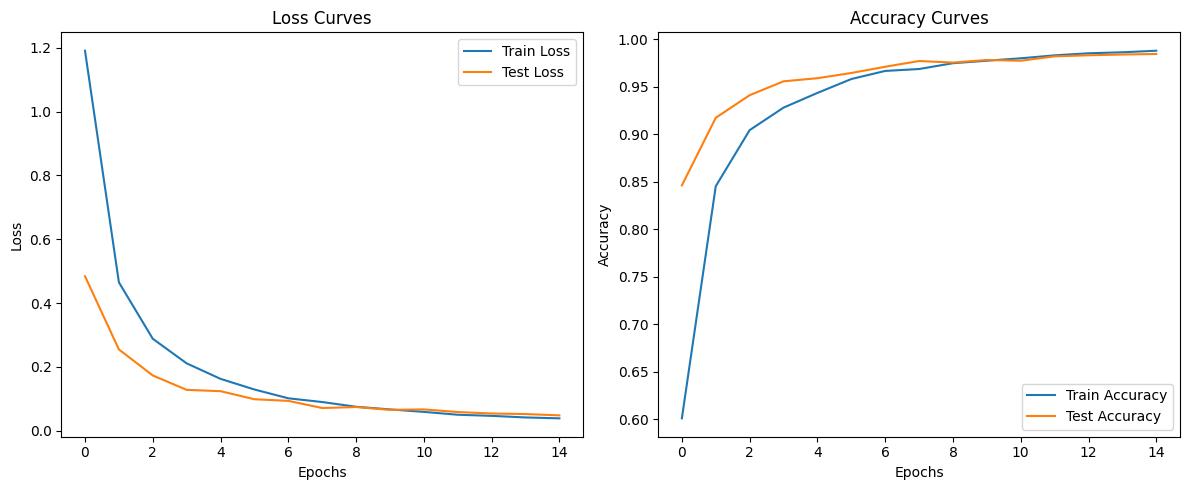

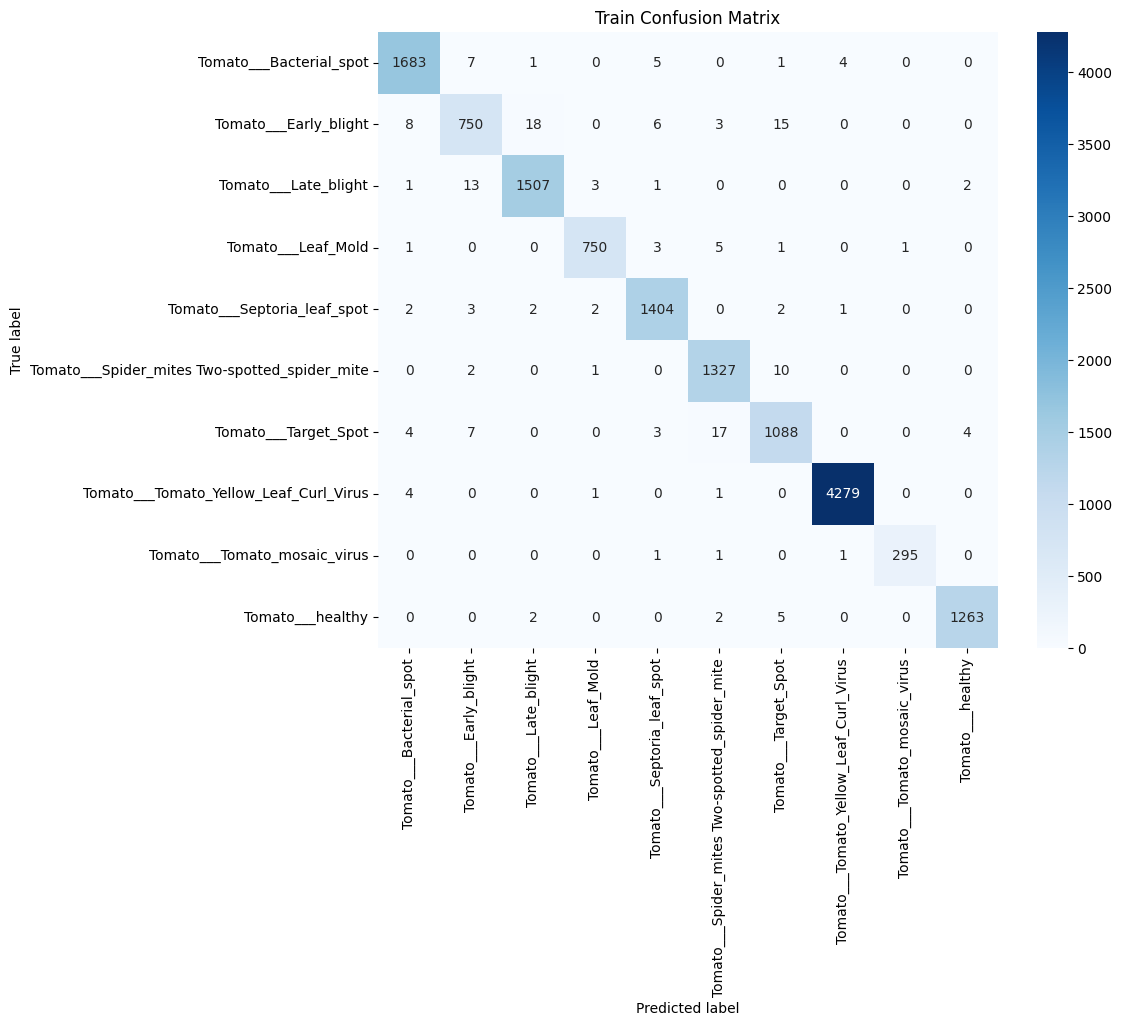

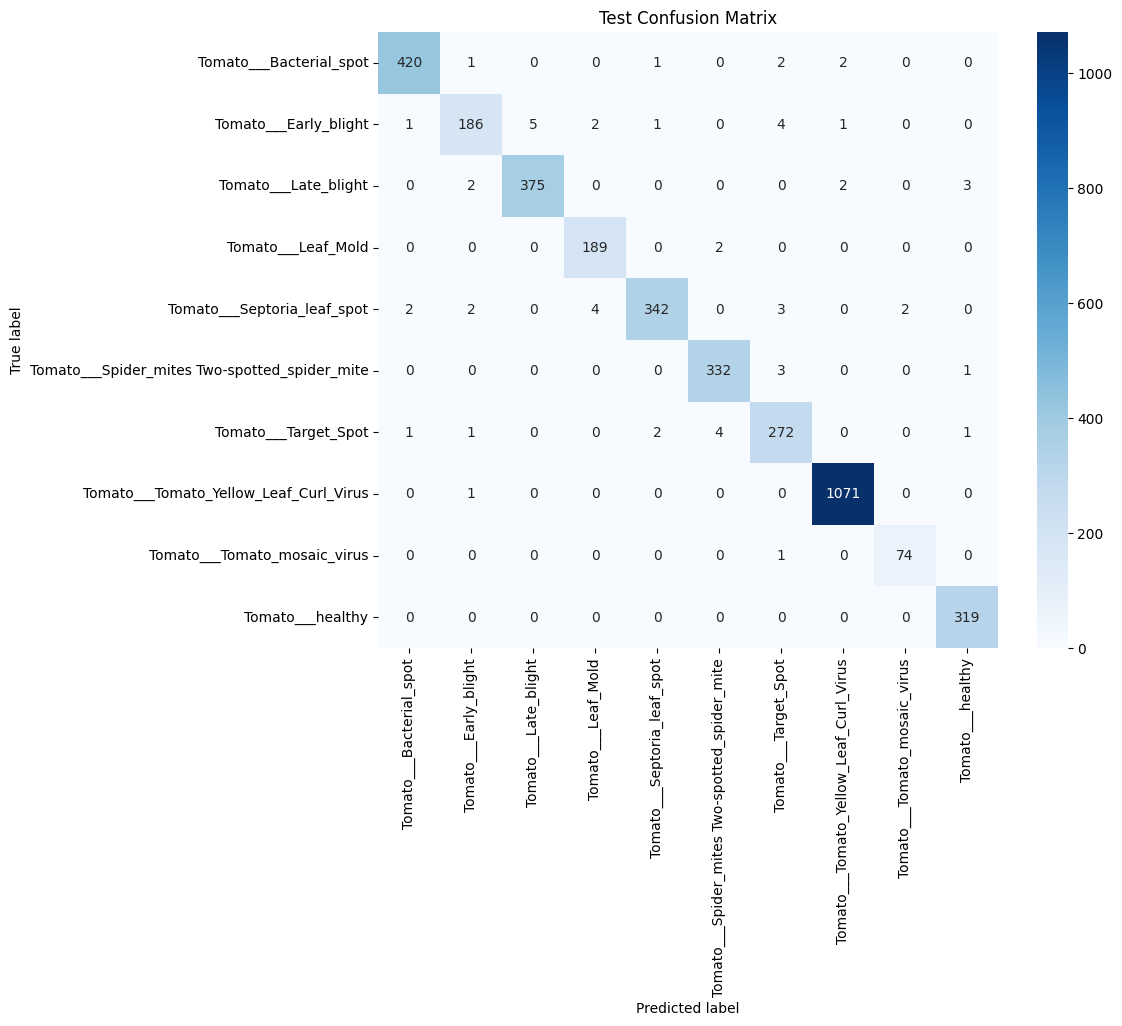

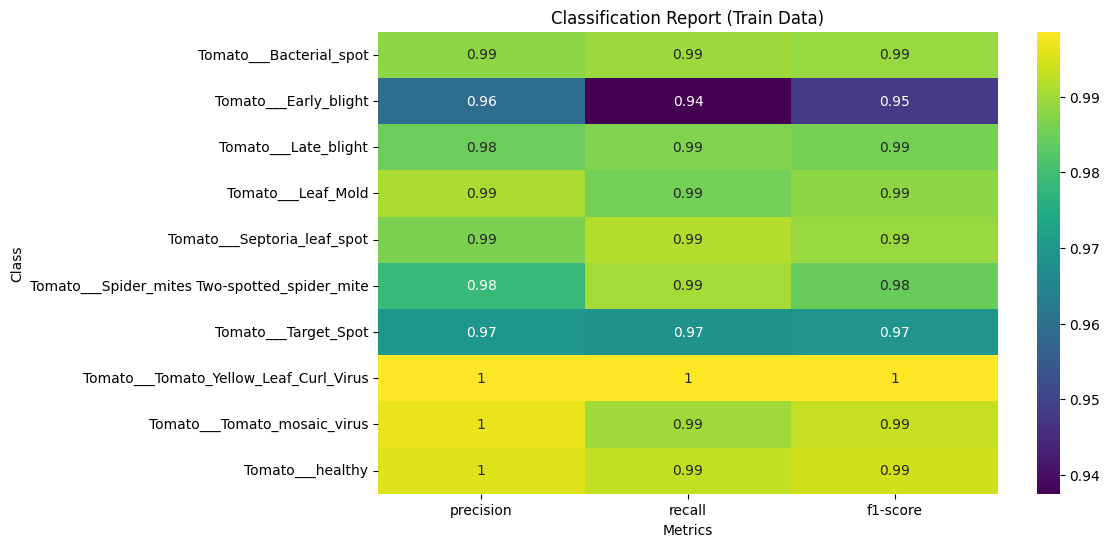

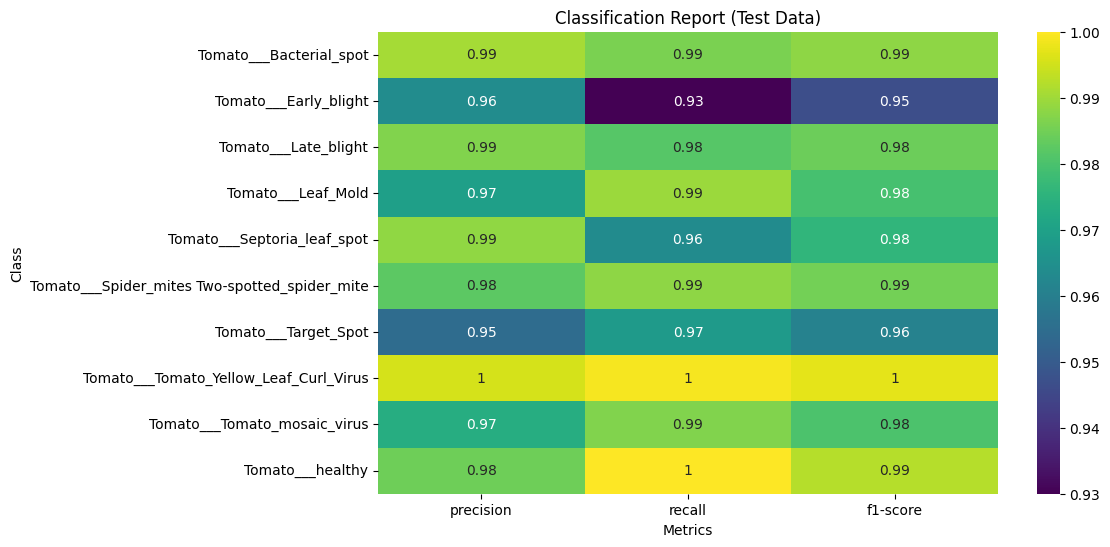

In [ ]:
# Po uruchomieniu funkcji train i zebraniu wyników w results
results = vgg_64_adam_color_results
# Wyświetlenie tabel z wynikami
display_metrics(results)

# Narysowanie wykresów loss i accuracy
plot_curves(results)

# Wyświetlenie macierzy pomyłek
display_confusion_matrices(results, class_names)

plot_classification_reports(results, class_names)

### 10.3.2 | batch = 64 | optymalizator = Adam | barwa = w kolorze

     Metric     Train      Test
0      Loss  2.103742  2.104298
1  Accuracy  0.295035  0.293860
2    Recall  0.100000  0.100000
3  F1-score  0.045566  0.045530


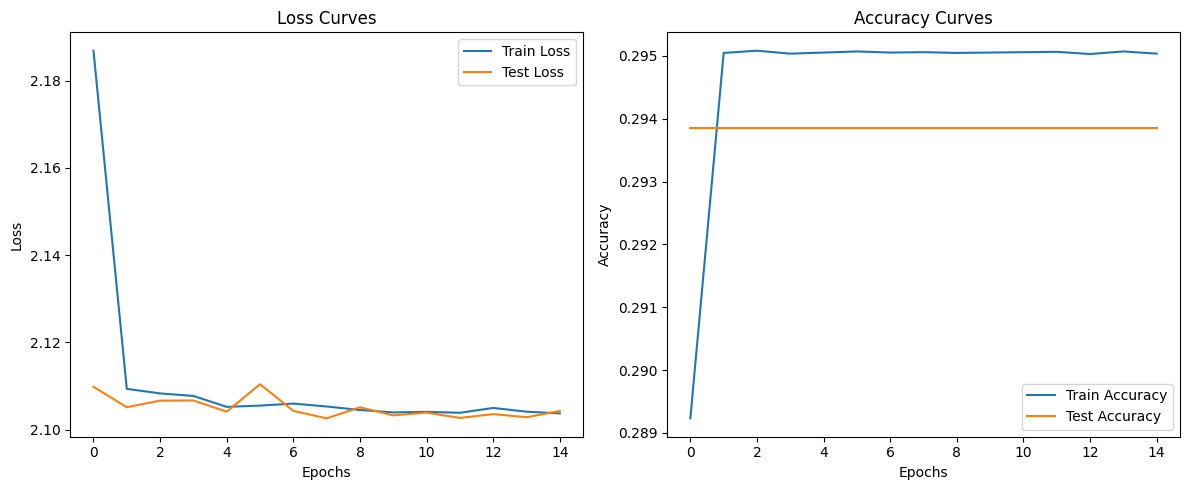

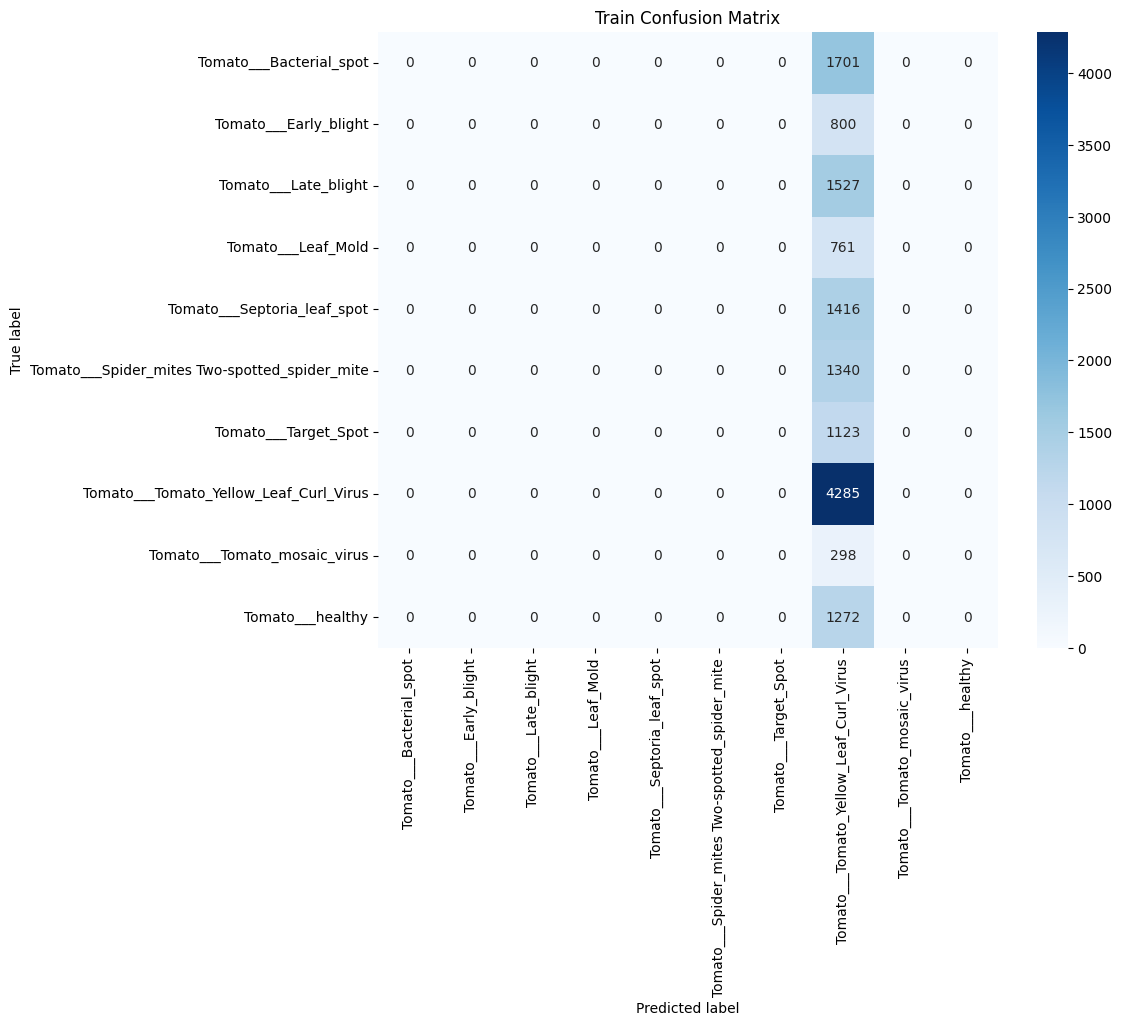

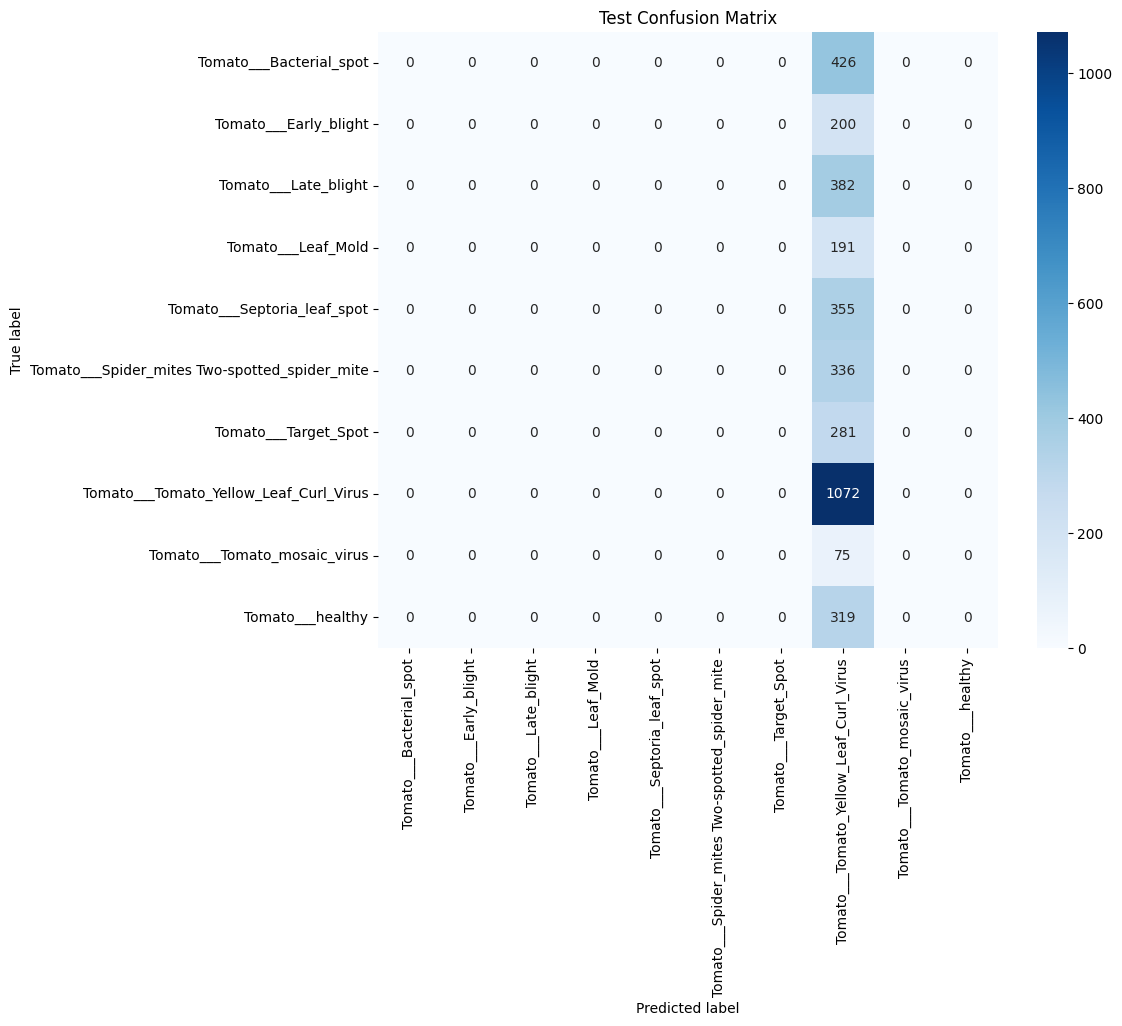

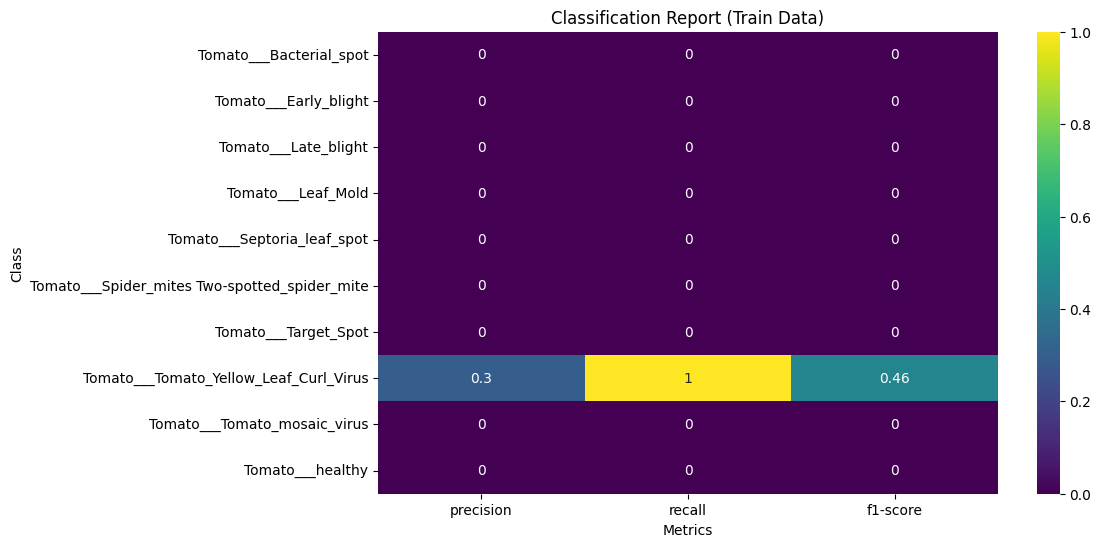

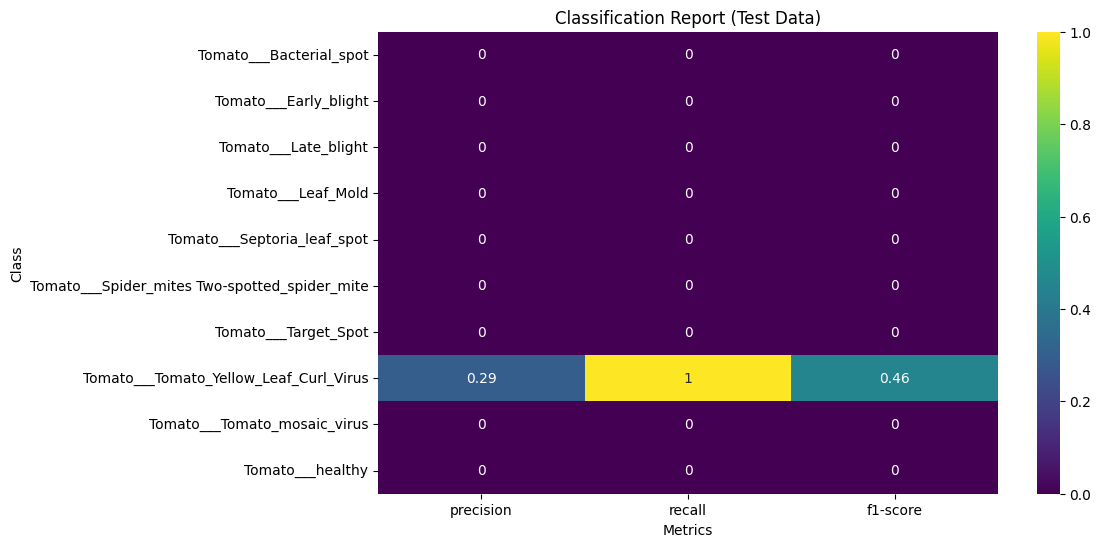

In [ ]:
# Po uruchomieniu funkcji train i zebraniu wyników w results
results = vgg_64_sgd_color_results
# Wyświetlenie tabel z wynikami
display_metrics(results)

# Narysowanie wykresów loss i accuracy
plot_curves(results)

# Wyświetlenie macierzy pomyłek
display_confusion_matrices(results, class_names)

plot_classification_reports(results, class_names)

### 10.3.3 | batch = 64 | optymalizator = Adam | barwa = szarość

     Metric     Train      Test
0      Loss  0.238414  0.509001
1  Accuracy  0.918967  0.847531
2    Recall  0.892023  0.784085
3  F1-score  0.893055  0.783844


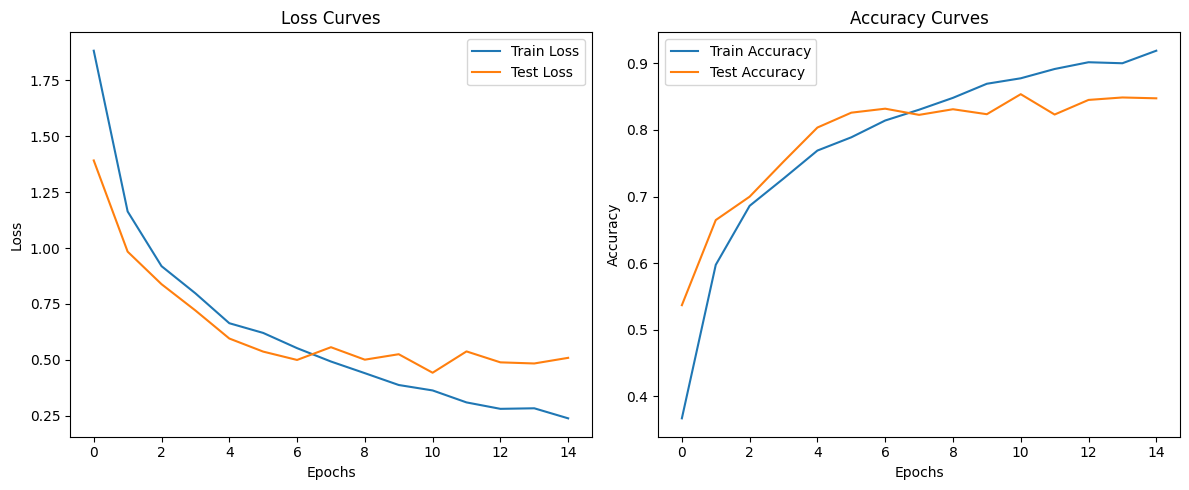

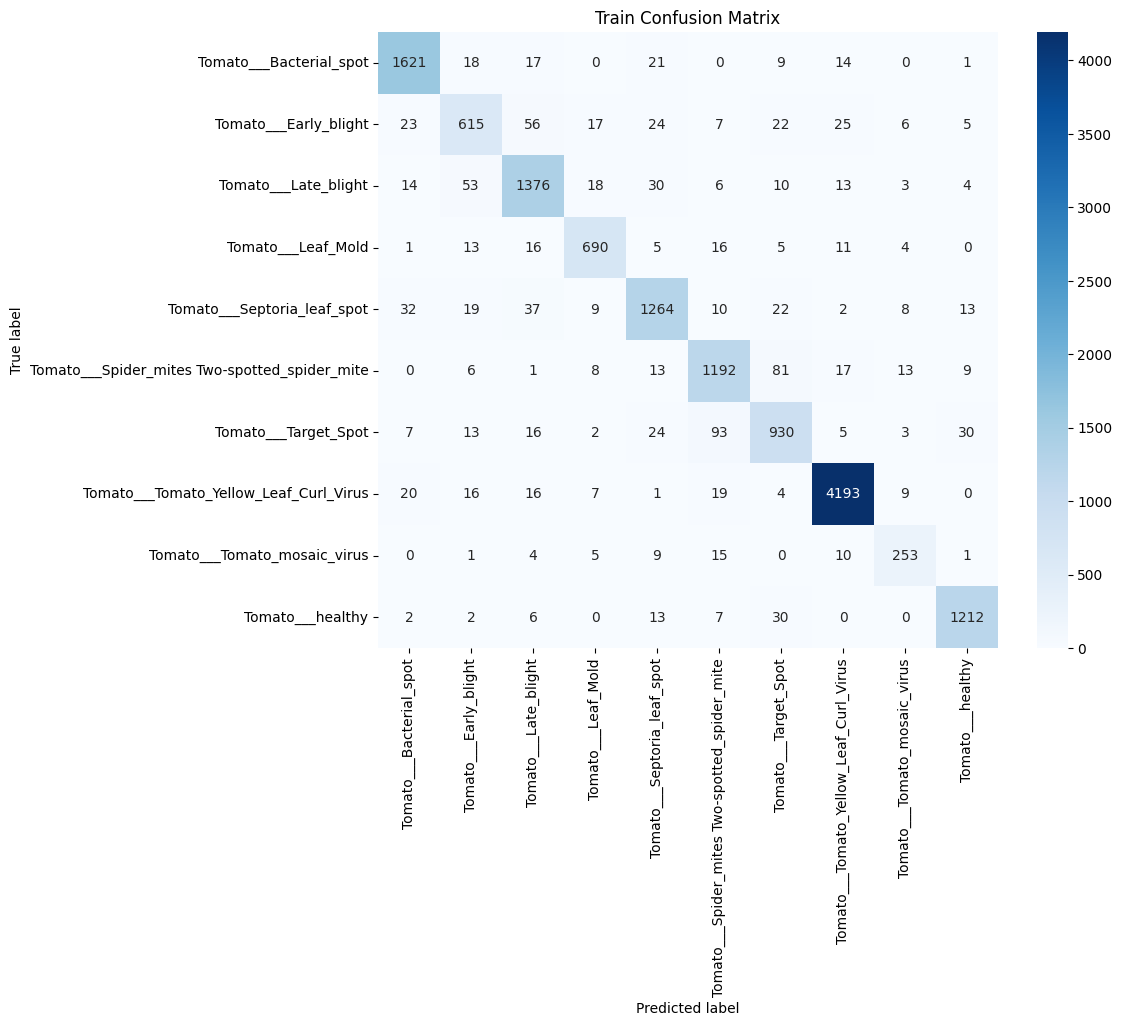

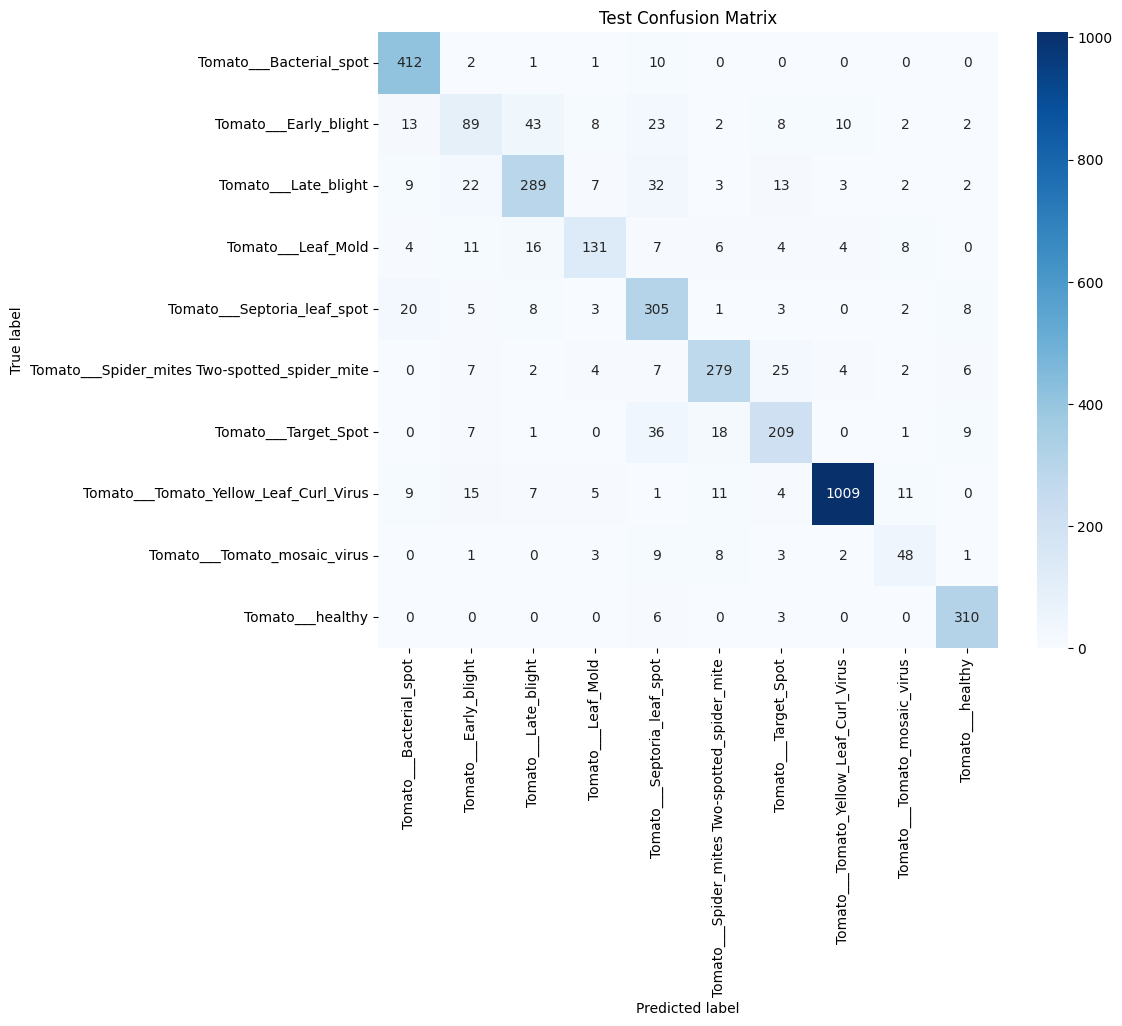

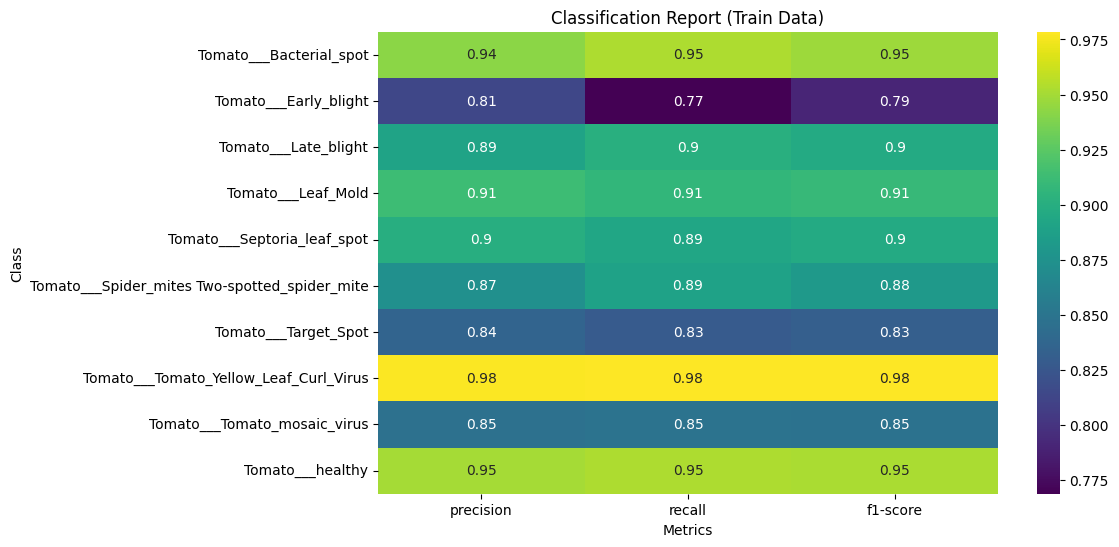

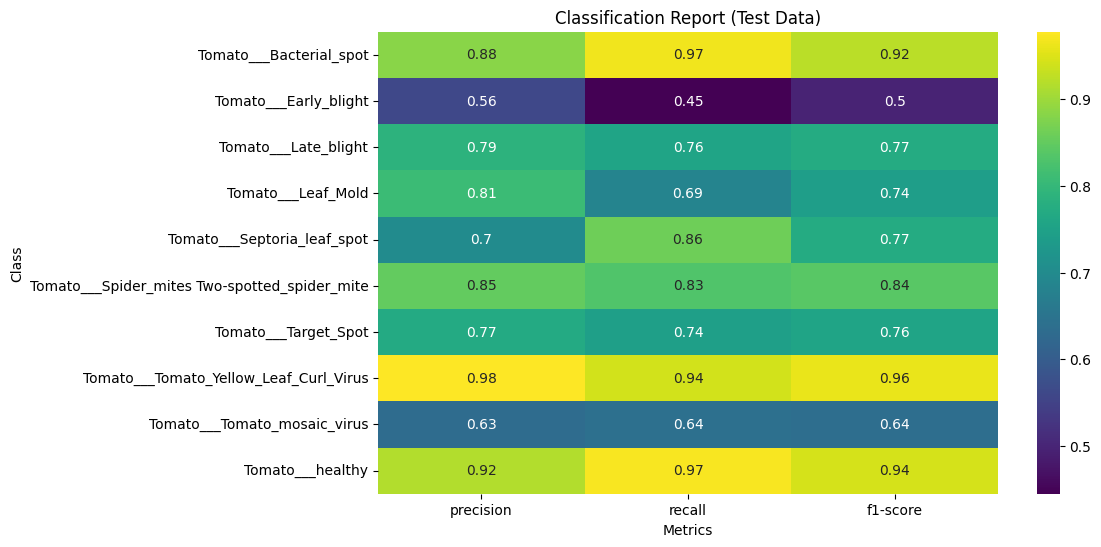

In [ ]:
# Po uruchomieniu funkcji train i zebraniu wyników w results
results = vgg_64_adam_gray_results
# Wyświetlenie tabel z wynikami
display_metrics(results)

# Narysowanie wykresów loss i accuracy
plot_curves(results)

# Wyświetlenie macierzy pomyłek
display_confusion_matrices(results, class_names)

plot_classification_reports(results, class_names)

### 10.3.4 | batch = 64 | optymalizator = SGD | barwa = szarość

     Metric     Train      Test
0      Loss  0.112462  0.142191
1  Accuracy  0.960415  0.948625
2    Recall  0.946009  0.924073
3  F1-score  0.946173  0.927863


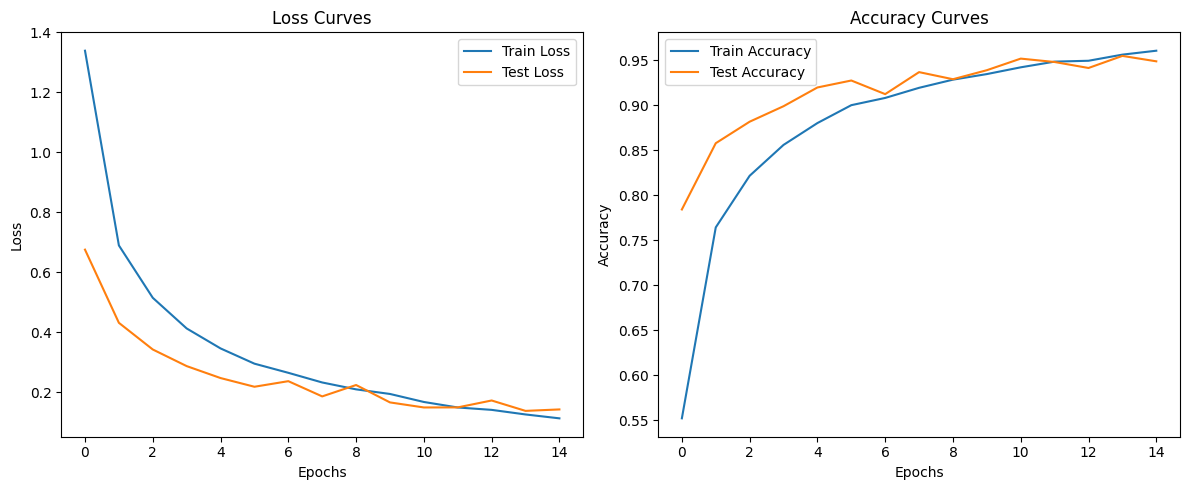

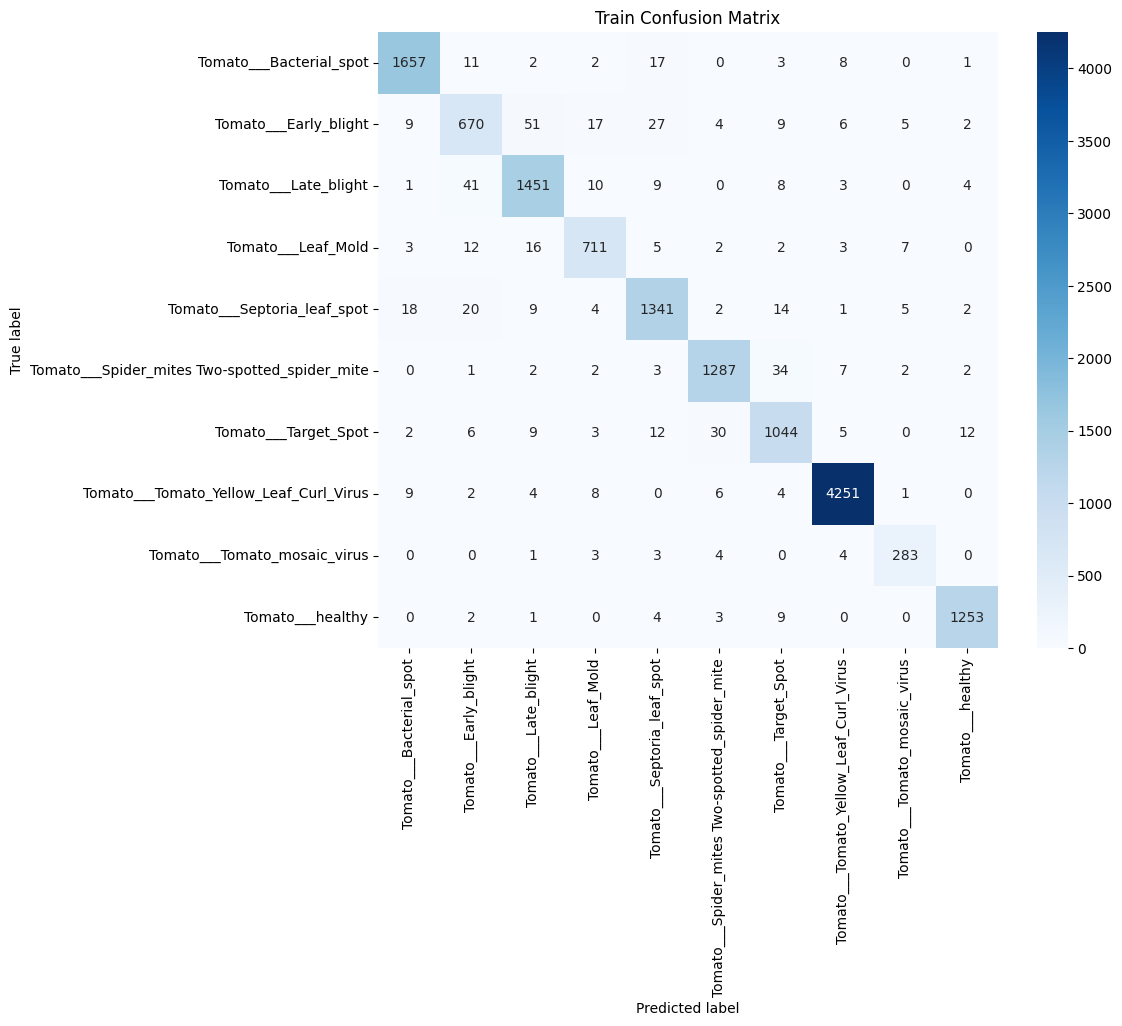

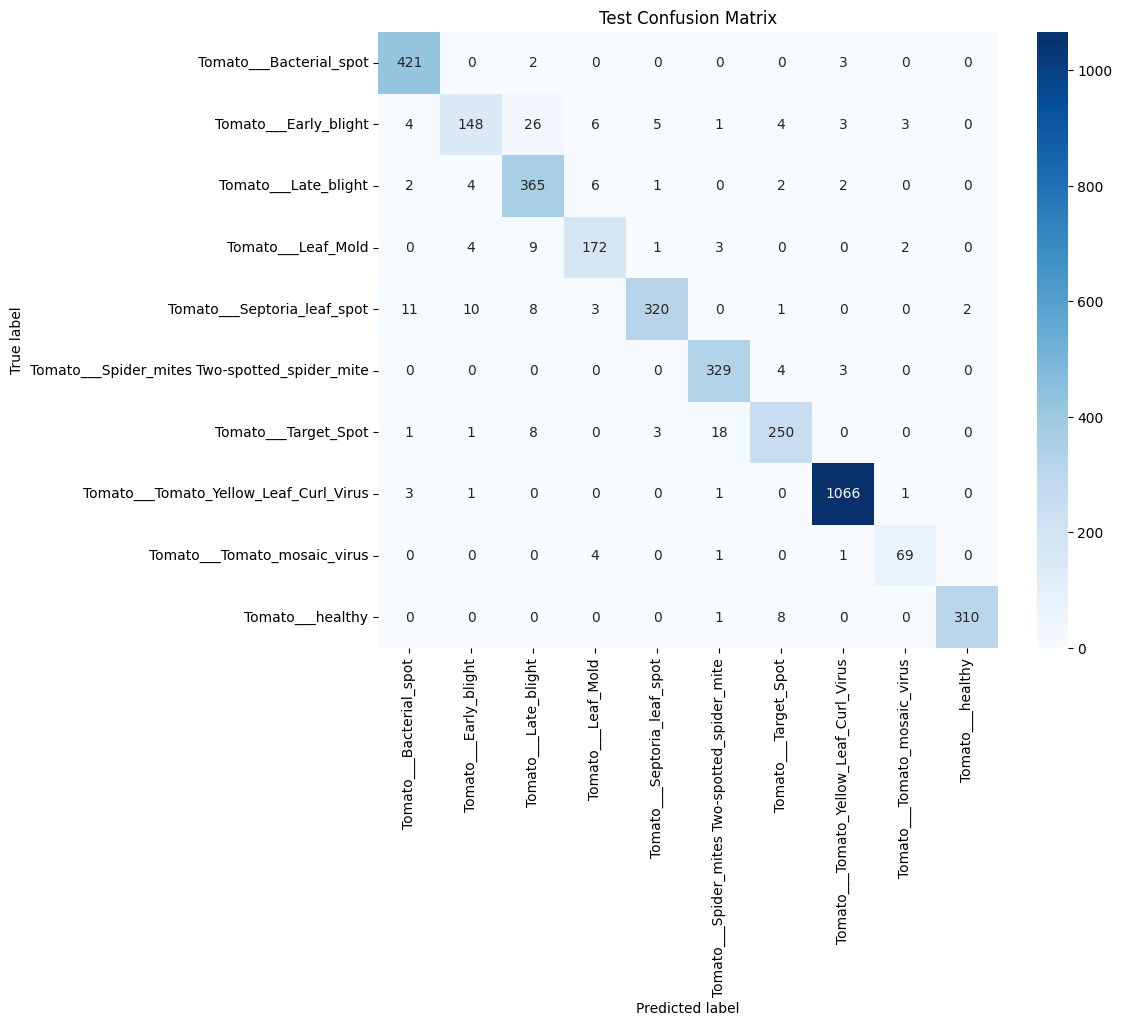

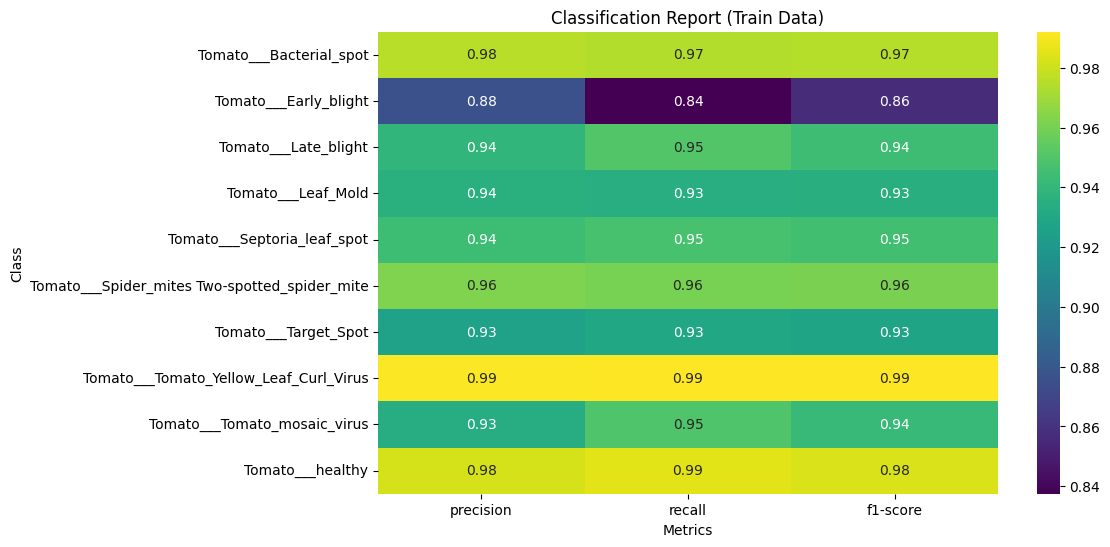

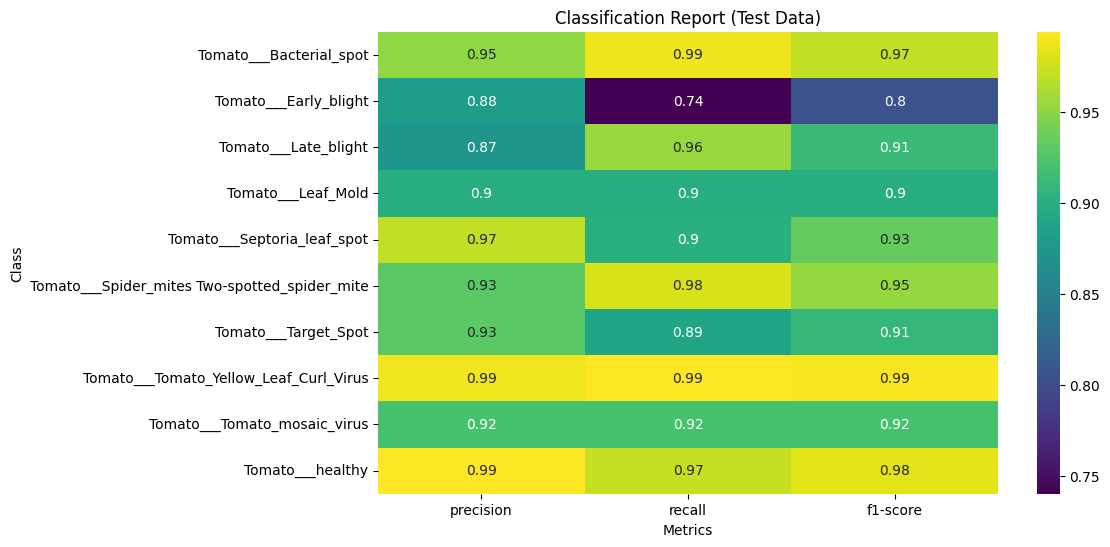

In [ ]:
# Po uruchomieniu funkcji train i zebraniu wyników w results
results = vgg_64_sgd_gray_results
# Wyświetlenie tabel z wynikami
display_metrics(results)

# Narysowanie wykresów loss i accuracy
plot_curves(results)

# Wyświetlenie macierzy pomyłek
display_confusion_matrices(results, class_names)

plot_classification_reports(results, class_names)

## 10.4 Vision Transformer

### 10.4.1 | batch = 64 | optymalizator = Adam | barwa = w kolorze

     Metric     Train      Test
0      Loss  0.103296  0.155010
1  Accuracy  0.963983  0.949561
2    Recall  0.959039  0.939716
3  F1-score  0.958865  0.934896


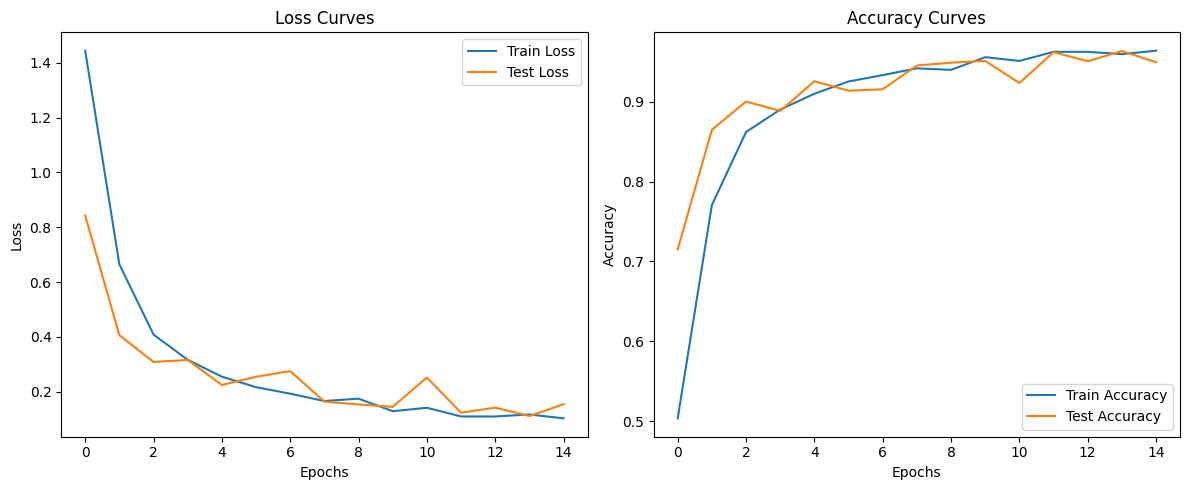

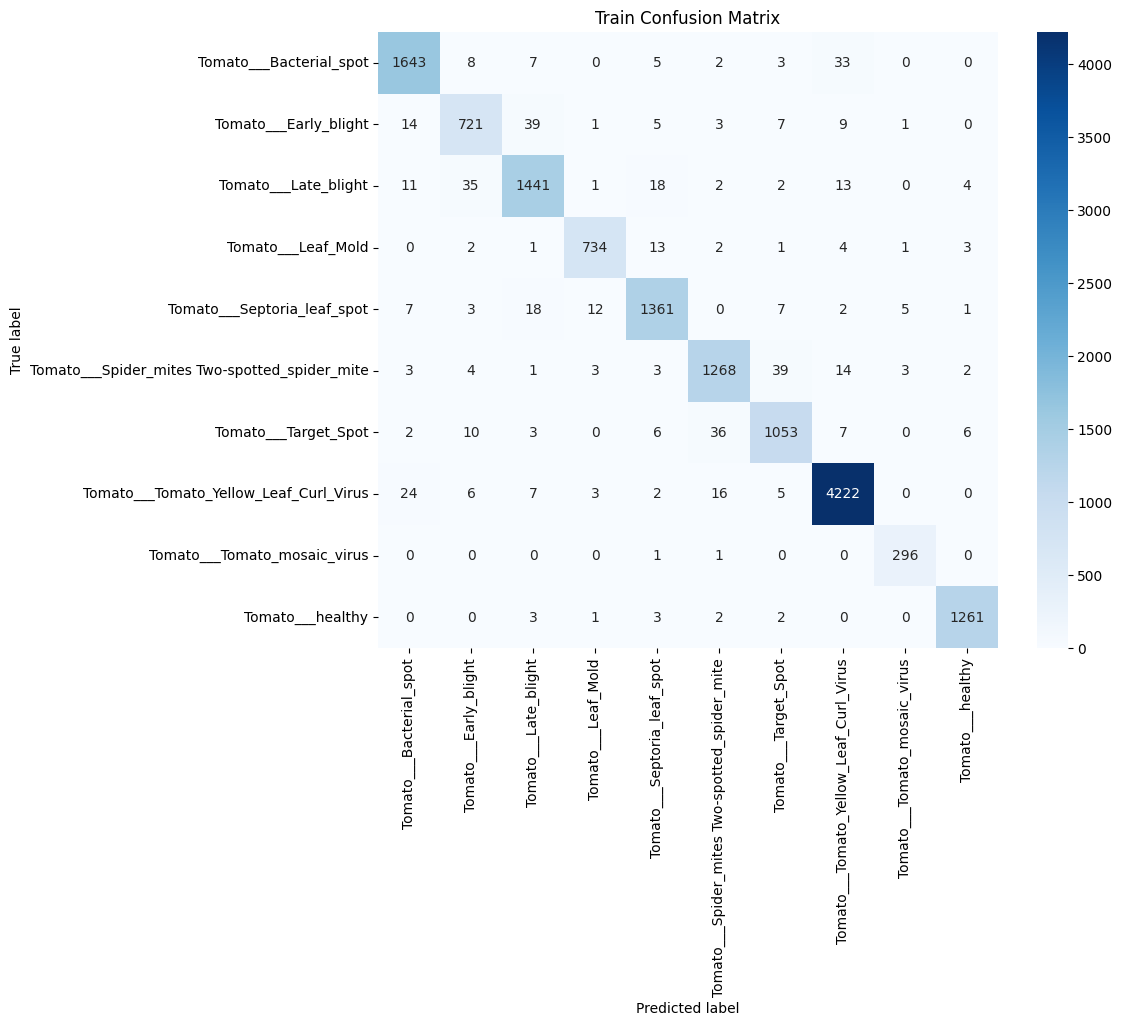

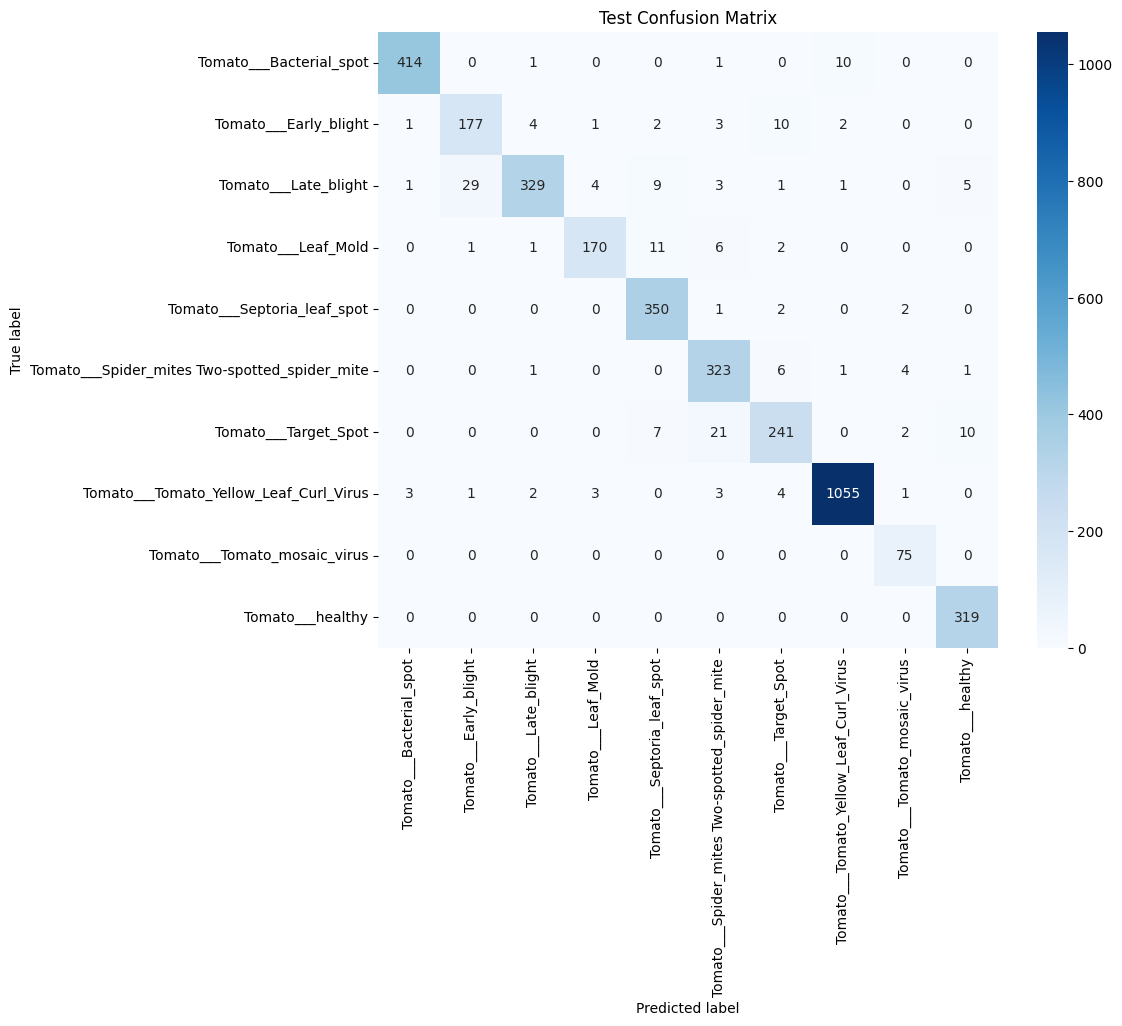

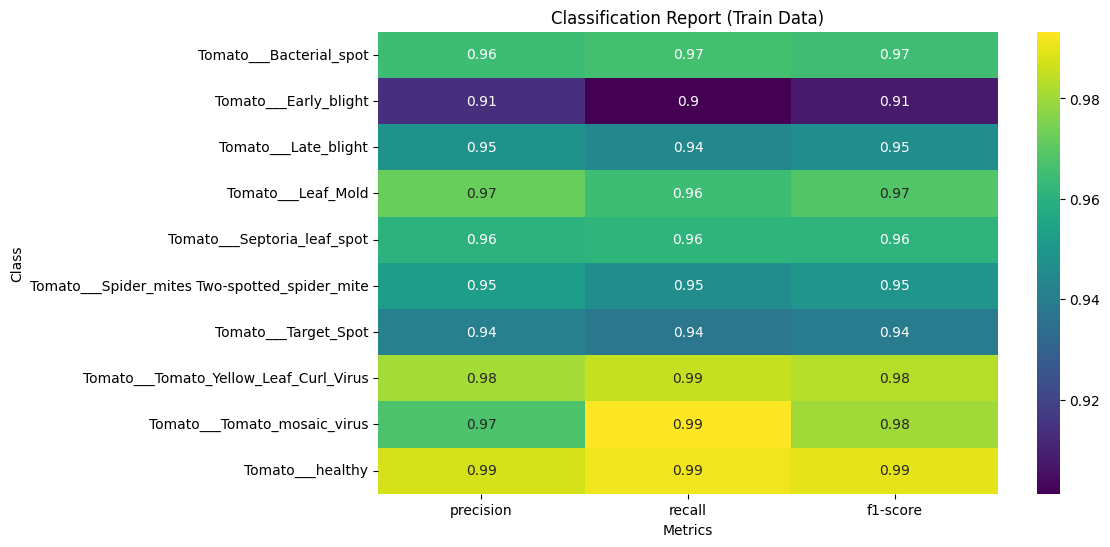

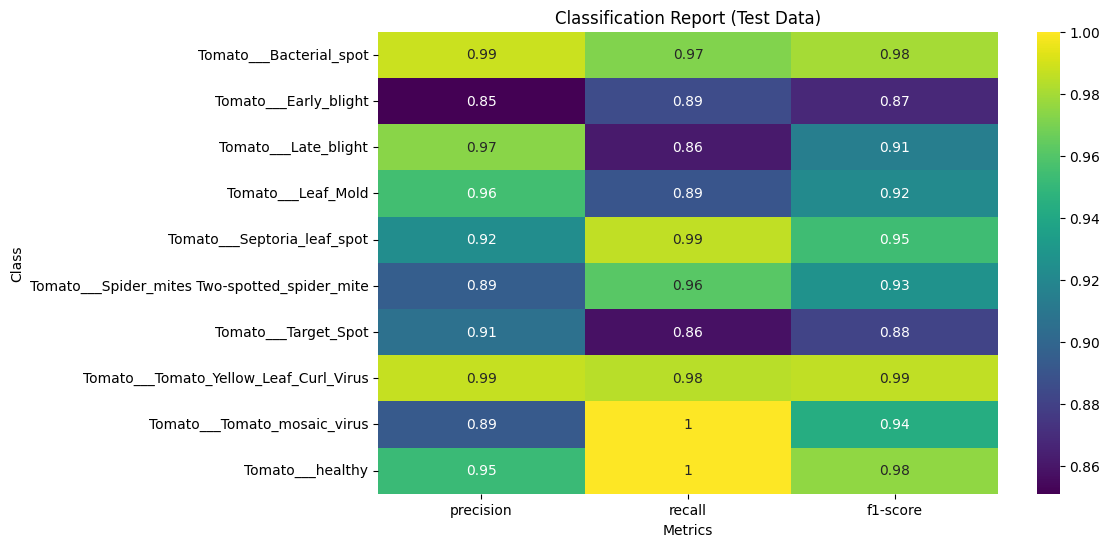

In [ ]:
# Po uruchomieniu funkcji train i zebraniu wyników w results
results = vit_64_adam_color_results
# Wyświetlenie tabel z wynikami
display_metrics(results)

# Narysowanie wykresów loss i accuracy
plot_curves(results)

# Wyświetlenie macierzy pomyłek
display_confusion_matrices(results, class_names)

plot_classification_reports(results, class_names)

### 10.4.2 | batch = 64 | optymalizator = SGD | barwa = w kolorze

     Metric     Train      Test
0      Loss  0.022533  0.046170
1  Accuracy  0.998417  0.988761
2    Recall  0.998003  0.985483
3  F1-score  0.997913  0.985409


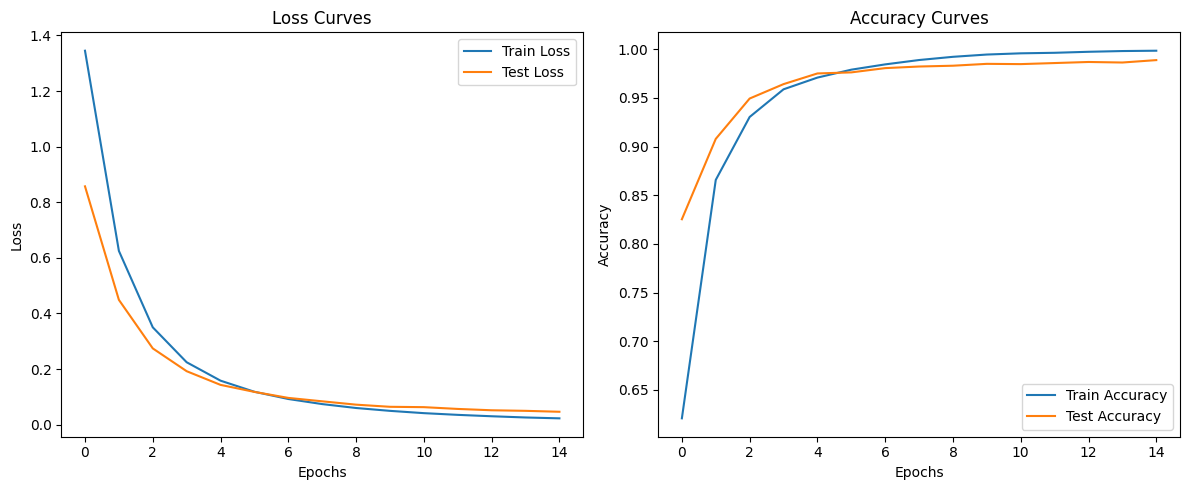

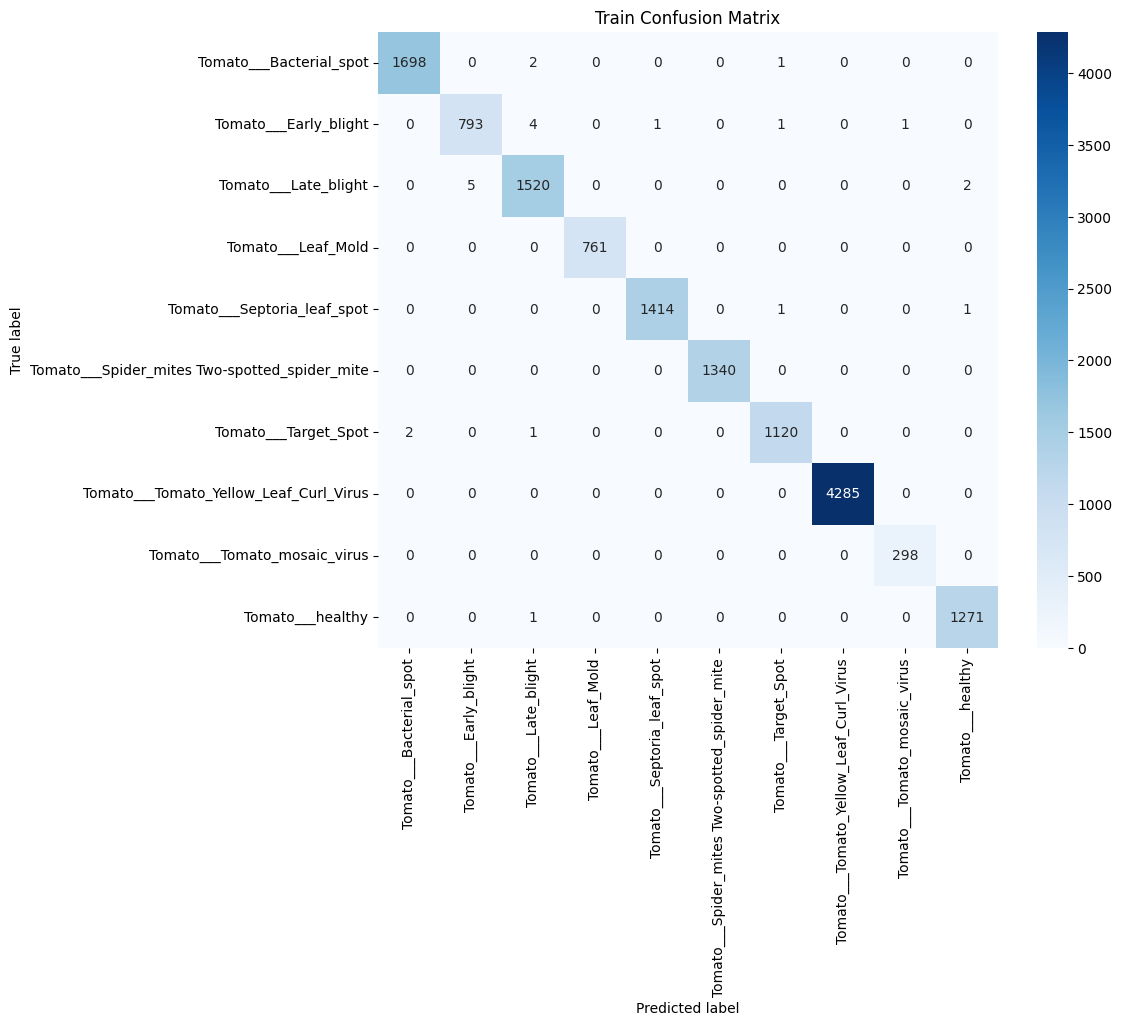

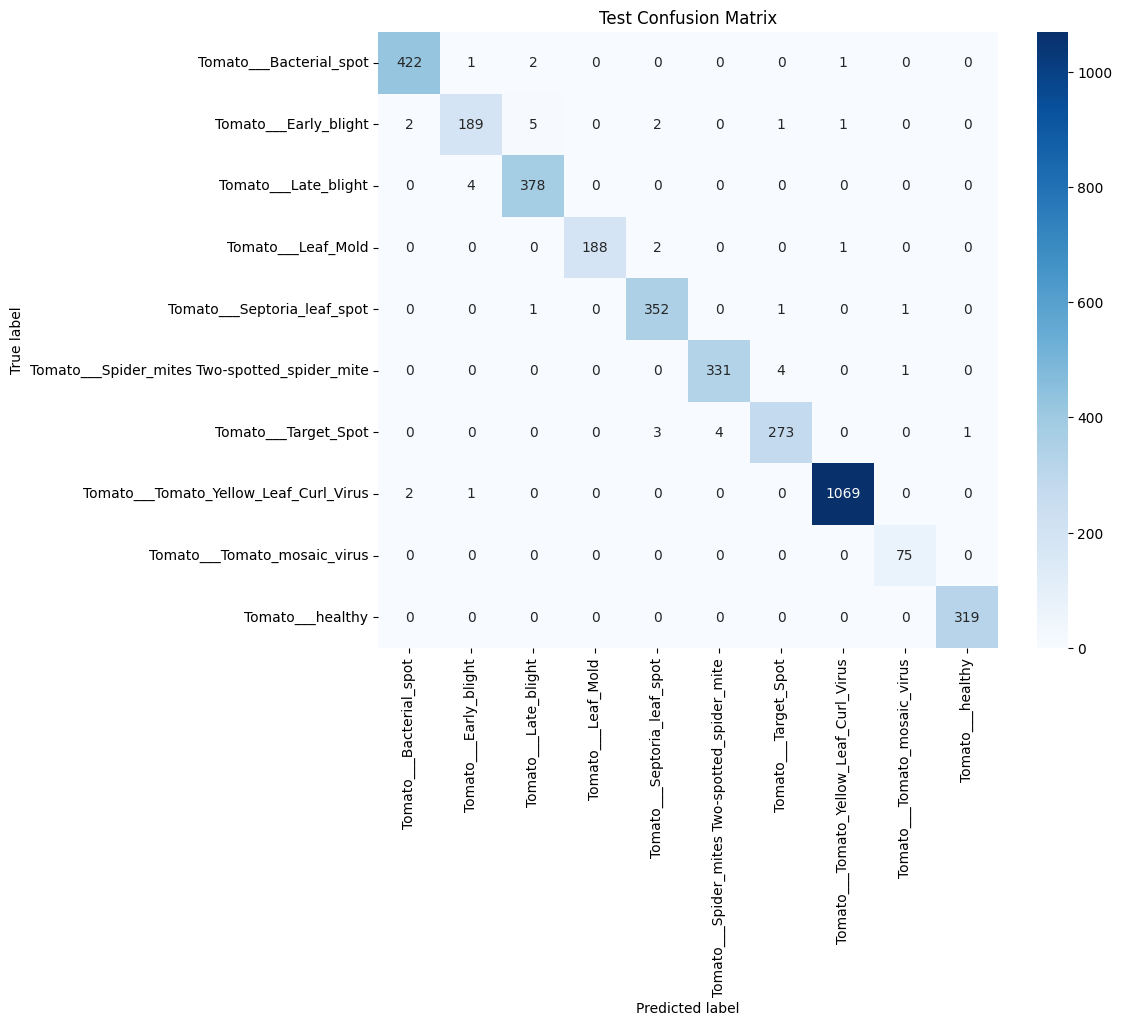

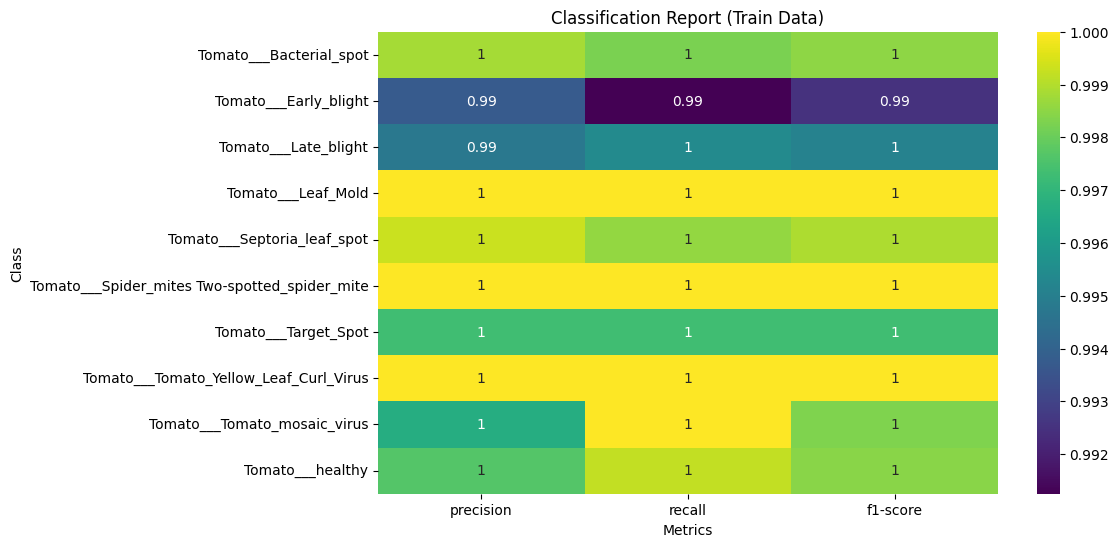

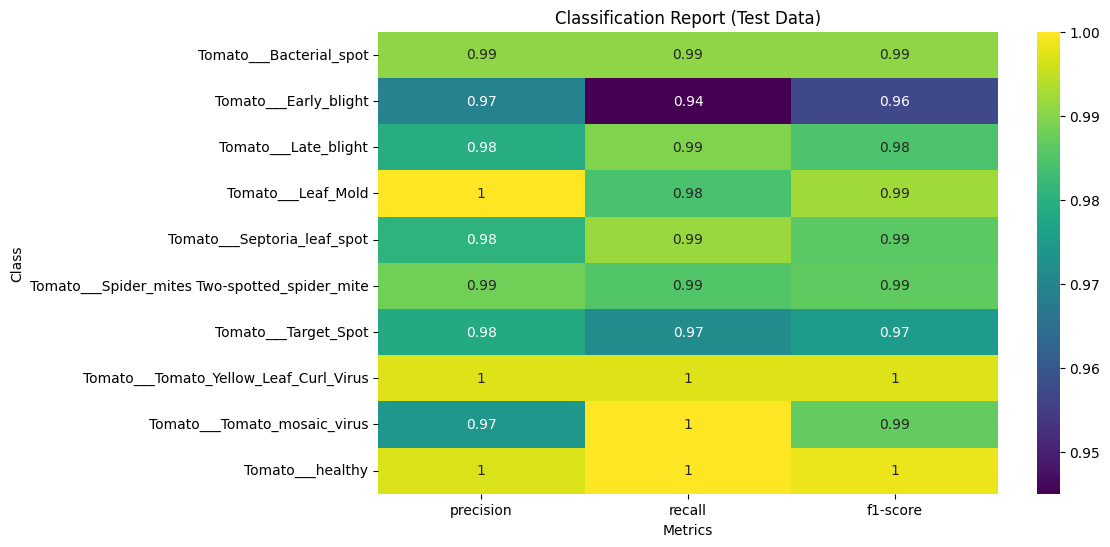

In [ ]:
# Po uruchomieniu funkcji train i zebraniu wyników w results
results = vit_64_sgd_color_results
# Wyświetlenie tabel z wynikami
display_metrics(results)

# Narysowanie wykresów loss i accuracy
plot_curves(results)

# Wyświetlenie macierzy pomyłek
display_confusion_matrices(results, class_names)

plot_classification_reports(results, class_names)

### 10.4.3 | batch = 64 | optymalizator = Adam | barwa = w szarości

     Metric     Train      Test
0      Loss  0.545411  0.716532
1  Accuracy  0.805810  0.748014
2    Recall  0.759221  0.689834
3  F1-score  0.763220  0.701835


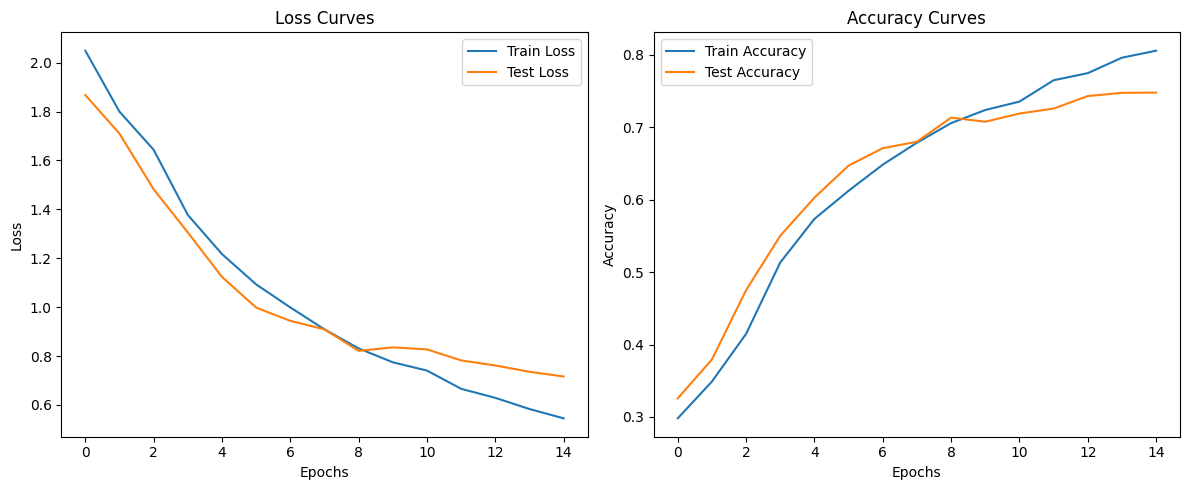

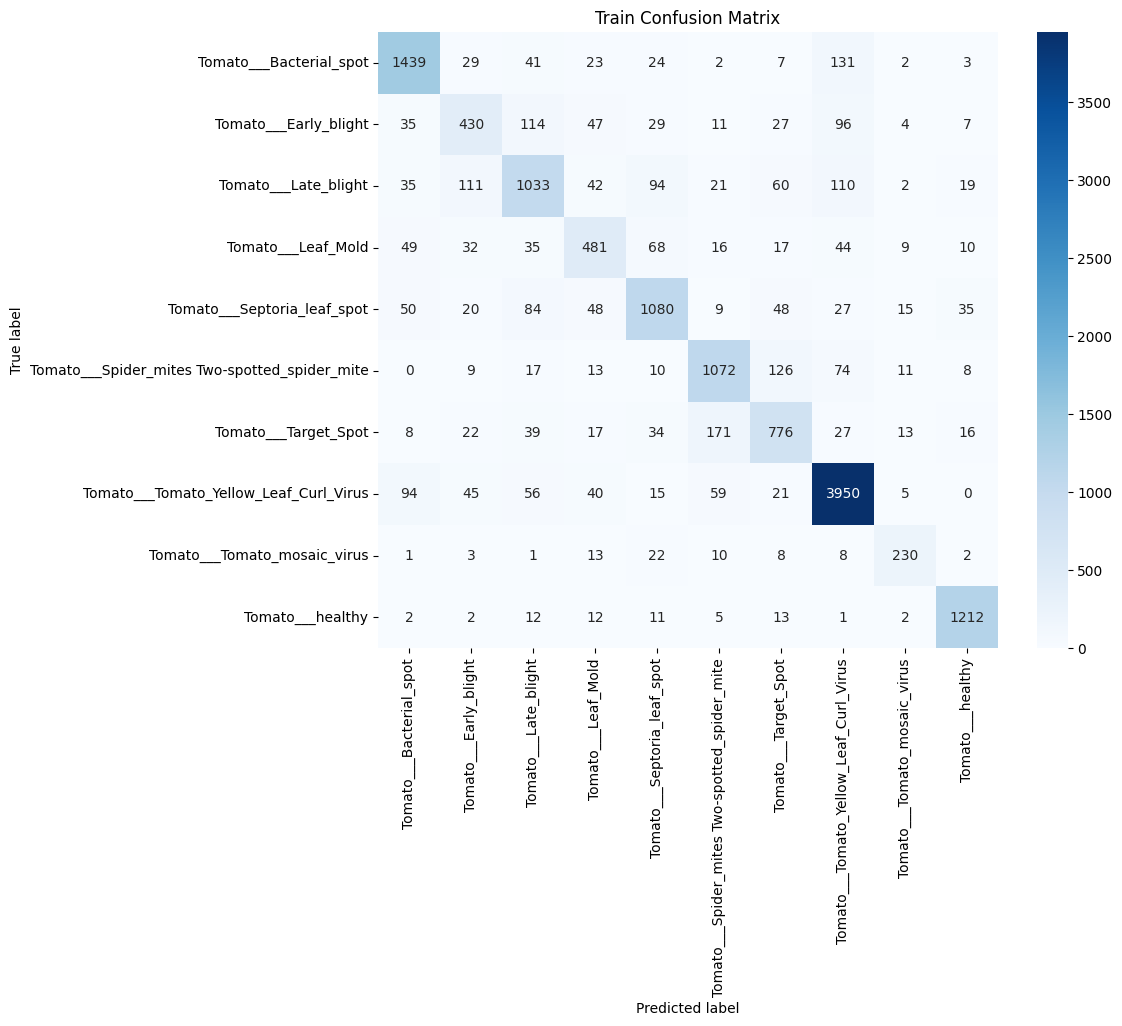

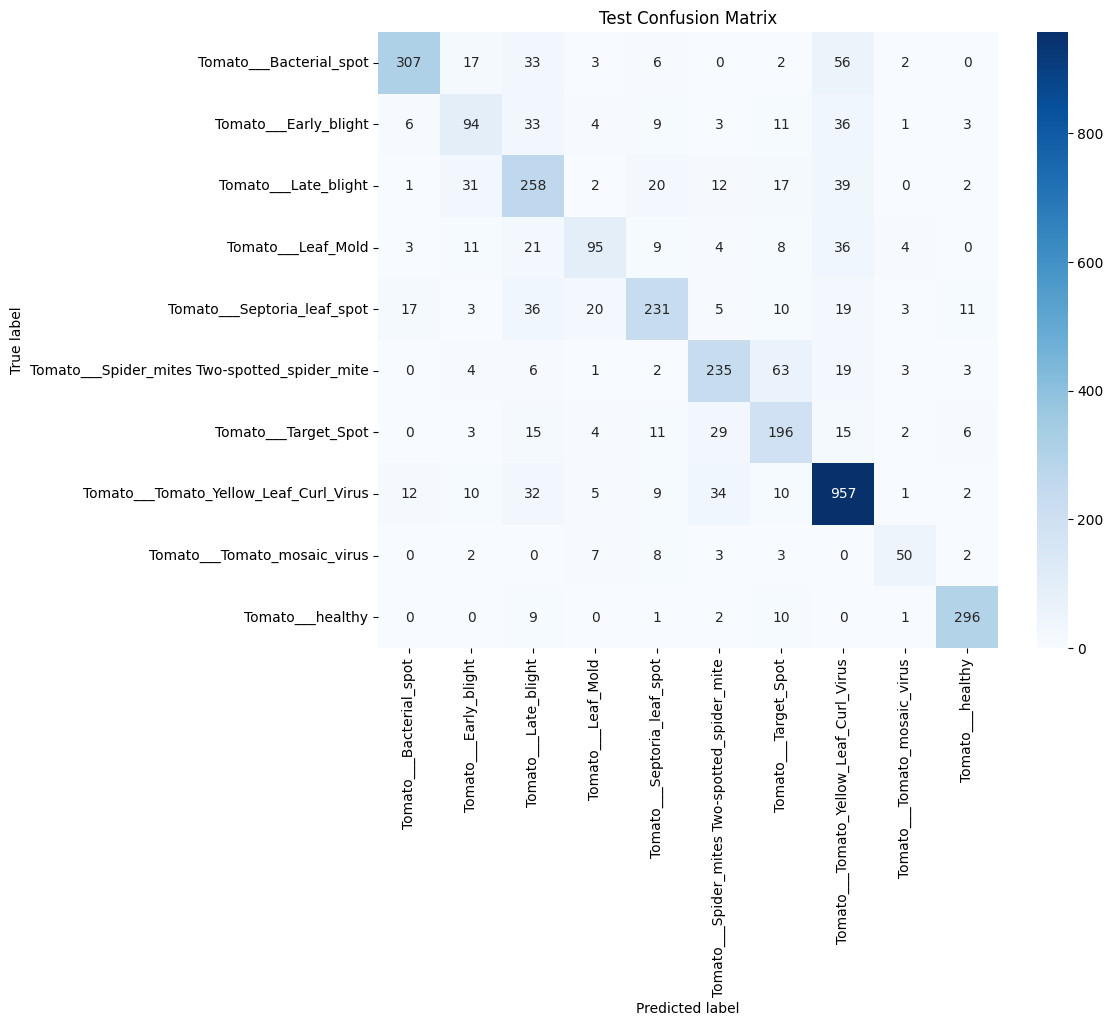

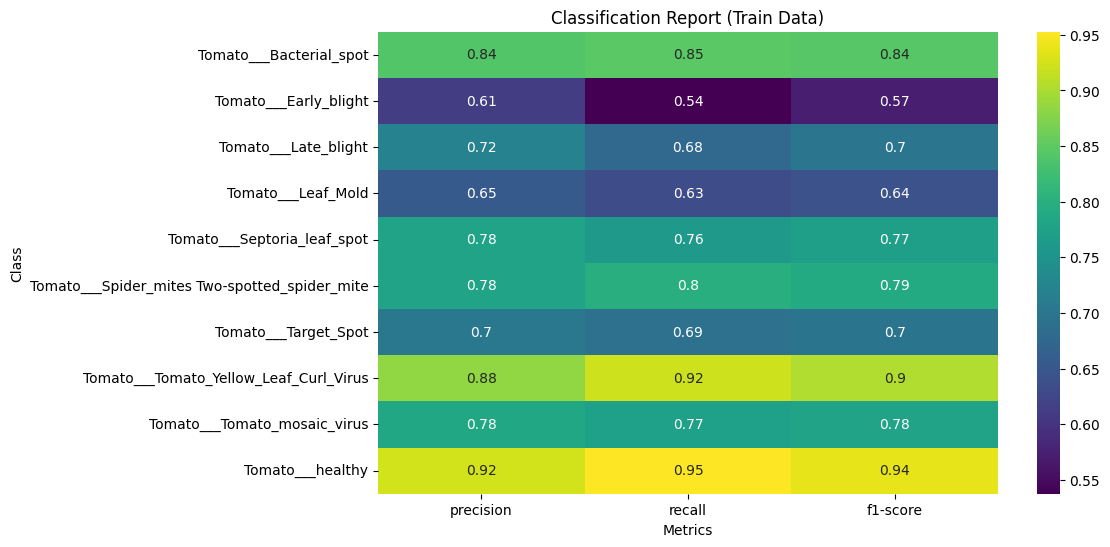

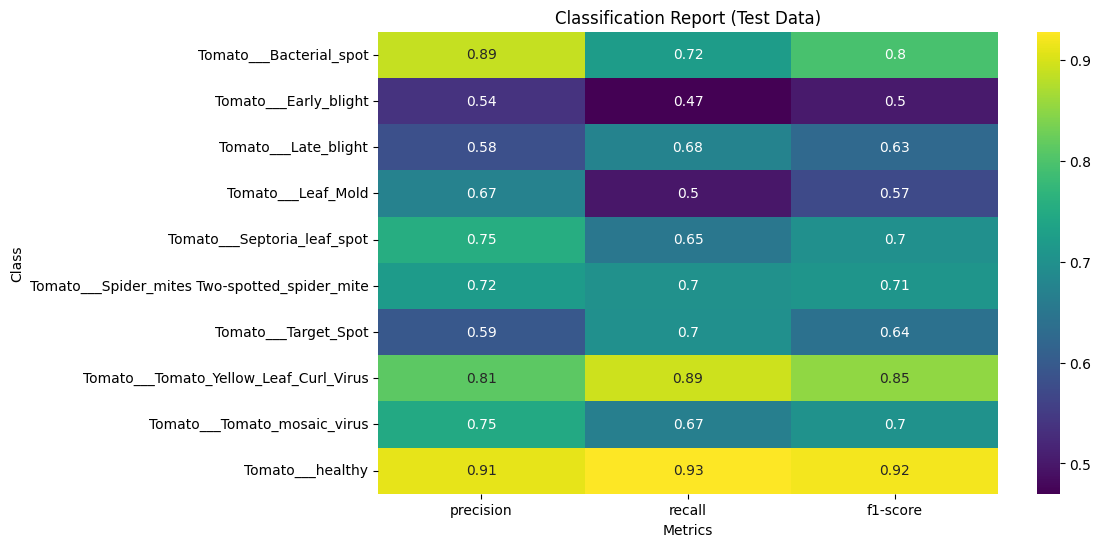

In [ ]:
# Po uruchomieniu funkcji train i zebraniu wyników w results
results = vit_64_adam_gray_results
# Wyświetlenie tabel z wynikami
display_metrics(results)

# Narysowanie wykresów loss i accuracy
plot_curves(results)

# Wyświetlenie macierzy pomyłek
display_confusion_matrices(results, class_names)

plot_classification_reports(results, class_names)

### 10.4.4 | batch = 64 | optymalizator = SGD | barwa = w szarości

     Metric     Train      Test
0      Loss  0.077043  0.157592
1  Accuracy  0.986291  0.950053
2    Recall  0.980040  0.931318
3  F1-score  0.981430  0.930802


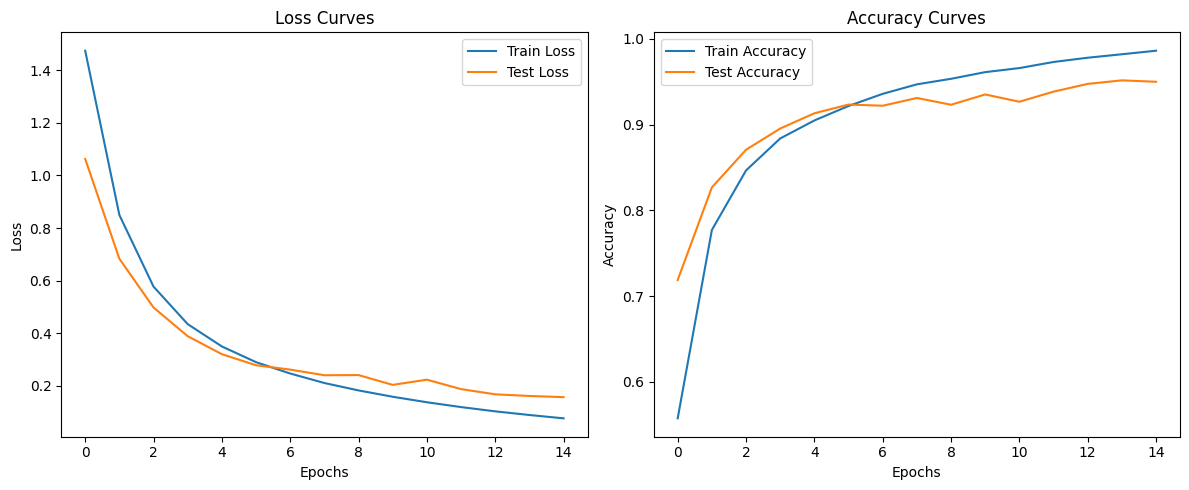

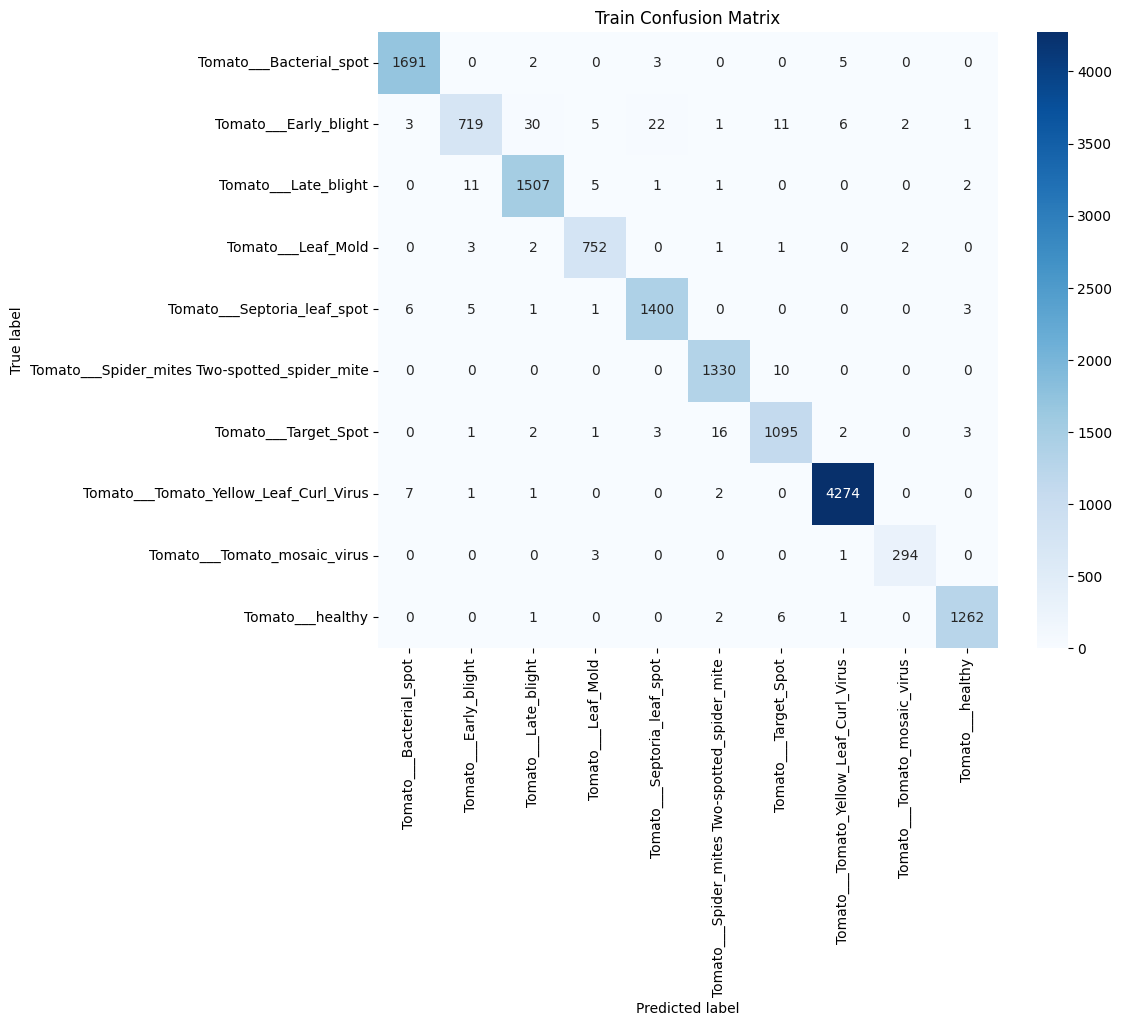

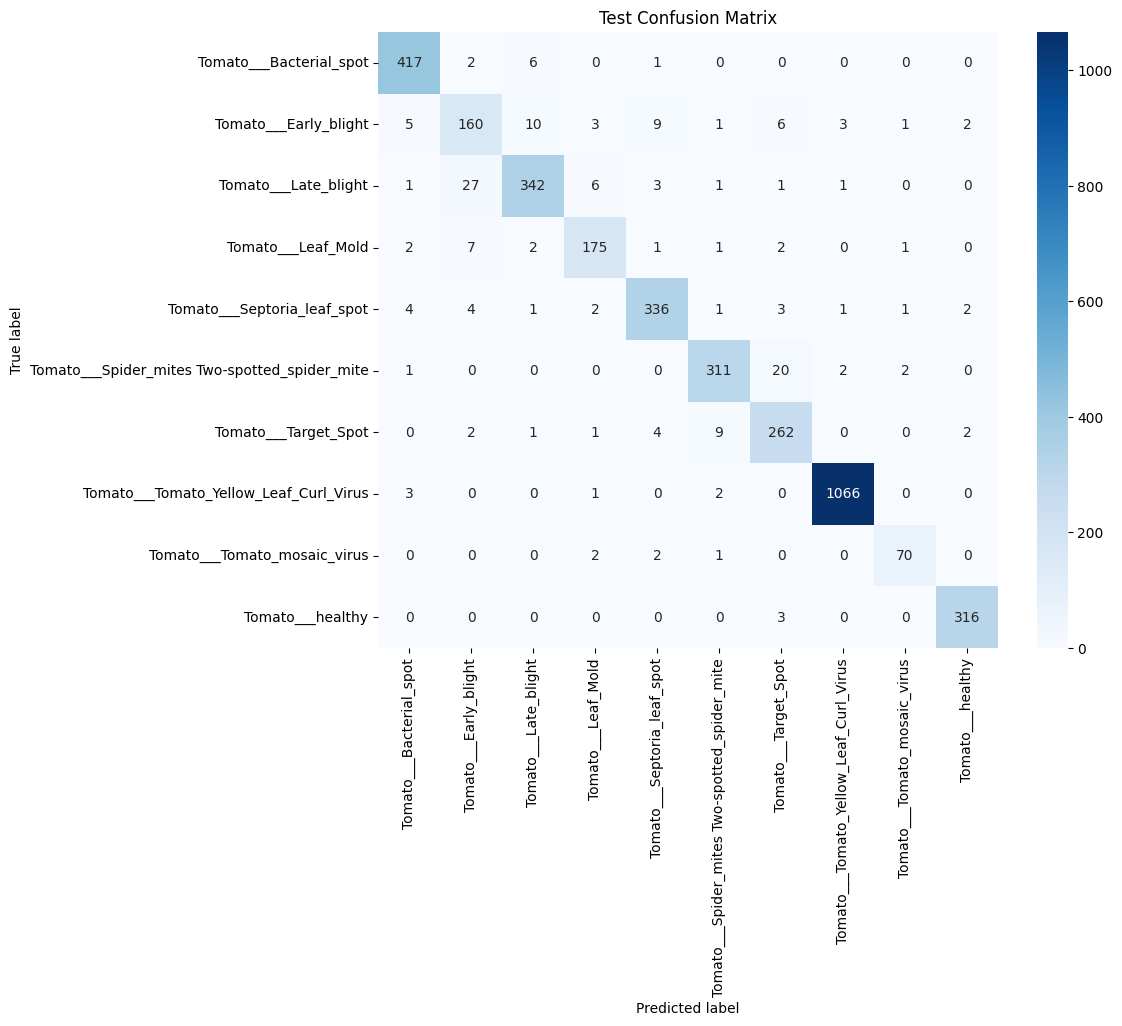

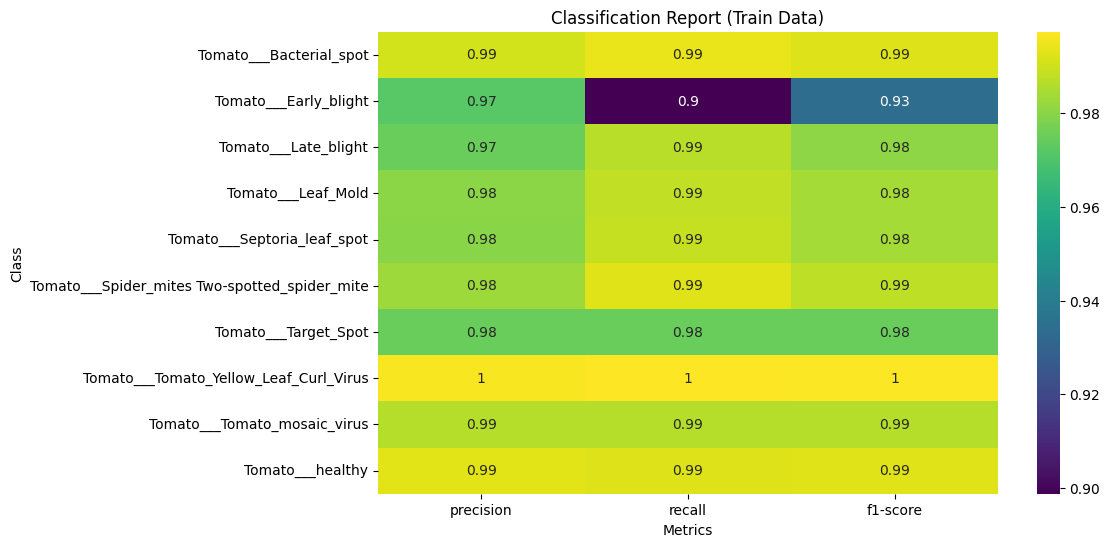

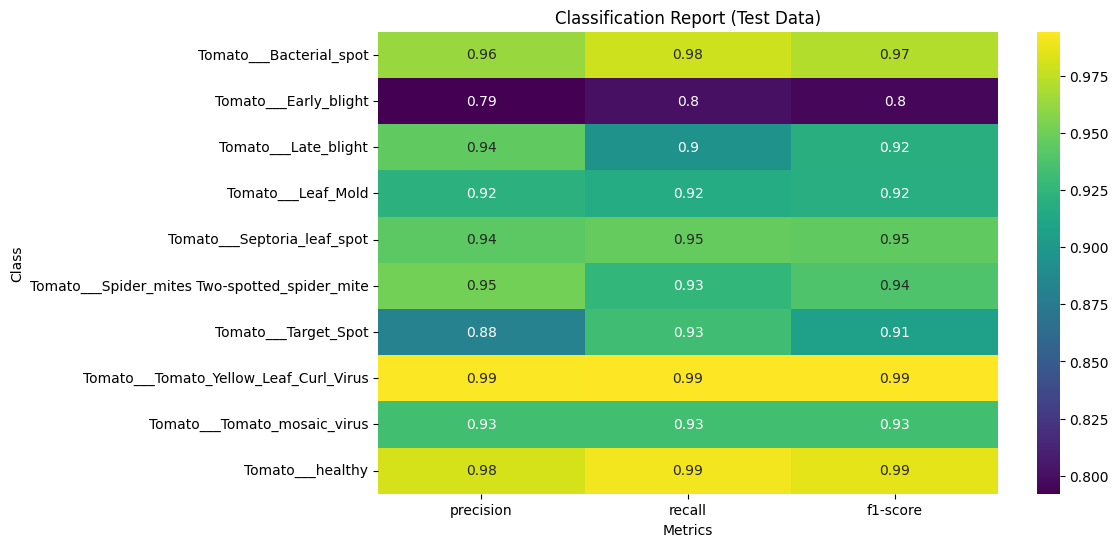

In [ ]:
# Po uruchomieniu funkcji train i zebraniu wyników w results
results = vit_64_sgd_gray_results
# Wyświetlenie tabel z wynikami
display_metrics(results)

# Narysowanie wykresów loss i accuracy
plot_curves(results)

# Wyświetlenie macierzy pomyłek
display_confusion_matrices(results, class_names)

plot_classification_reports(results, class_names)